# This is a fork/duplicate from Nicolas Maignan's Notebook

Original source: https://www.kaggle.com/c0conuts/unet-imagedatagenerator-lb-0-336

Modified as needed, using smaller batch and 224 x 224 instead of 256 x 256 to fit the available computing resource.

### Importing the needed libraries

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras import backend as K
from keras import metrics

import tensorflow as tf

# Set some parameters
BATCH_SIZE = 8 # the higher the better
IMG_WIDTH = 224 # for faster computing on kaggle
IMG_HEIGHT = 224 # for faster computing on kaggle
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seeds = [42, 84, 126, 168, 210, 252]
bag_percentage = 0.6
train_step_size = 400
val_step_size = 20
epochs = 25

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


###  1. Preparing the data

In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
np.random.seed(10)

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [03:42<00:00,  3.01it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 31.22it/s]


Done!


In [4]:
# Get samples defined by percentage of all training data
def sample_data(X_train, Y_train, percentage):
    dim = np.arange(0, X_train.shape[0])
    np.random.shuffle(dim)
    dim = dim[:int(dim.shape[0]*percentage)]
    print('dim[0:20] = ' + str(dim[0:20]))
    return X_train[dim], Y_train[dim]

###  2. Data Augmentation

In [5]:
# Modified as a function to return generated images given the sample data
from keras.preprocessing import image

def get_batch_generator(X_train, Y_train, rand_seed):
    # Creating the training Image and Mask generator
    image_datagen = image.ImageDataGenerator(shear_range=0.75, rotation_range=75, zoom_range=0.75, width_shift_range=0.75, height_shift_range=0.75, fill_mode='reflect')
    mask_datagen = image.ImageDataGenerator(shear_range=0.75, rotation_range=75, zoom_range=0.75, width_shift_range=0.75, height_shift_range=0.75, fill_mode='reflect')

    # Keep the same seed for image and mask generators so they fit together

    image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=rand_seed)
    mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=rand_seed)

    x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=rand_seed)
    y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=rand_seed)



    # Creating the validation Image and Mask generator
    image_datagen_val = image.ImageDataGenerator()
    mask_datagen_val = image.ImageDataGenerator()

    image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=rand_seed)
    mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=rand_seed)

    x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=rand_seed)
    y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=rand_seed)
    
    return x,y,x_val,y_val

In [6]:
# Checking batch generator

x,y,x_val,y_val = get_batch_generator(X_train, Y_train, 12345)

C:\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


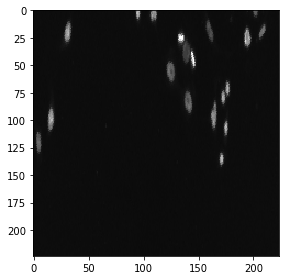

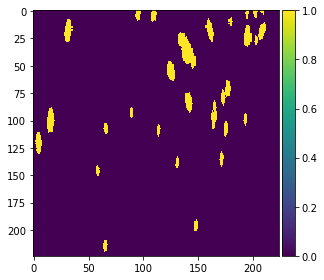

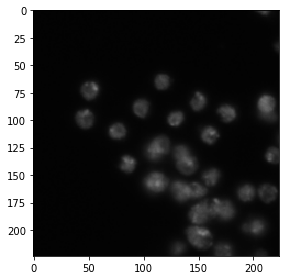

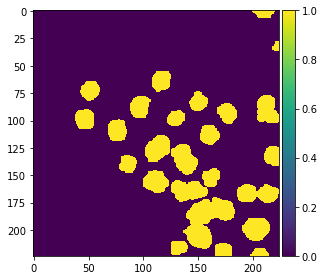

In [7]:
# Checking if the images fit

from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [11]:
# Zip (x,y) for training and validation

def get_train_val_generator(x,y,x_val,y_val):
    #creating a training and validation generator that generate masks and images
    train_generator = zip(x, y)
    val_generator = zip(x_val, y_val)
    return train_generator, val_generator

###  3. Creating the U-net model

In [12]:
# Define IoU metric

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [18]:
# Get UNet model

def get_unet():
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou, metrics.binary_accuracy])
    #model.summary()
    return model

###  4. Training

In [16]:
# Checking how good the functions so far

sd=12345
X_train0, Y_train0 = sample_data(X_train, Y_train, 0.6)
x0, y0, x_val0, y_val0 = get_batch_generator(X_train0, Y_train0, sd)
train_generator0, val_generator0 = get_train_val_generator(x0, y0, x_val0, y_val0)

dim[0:20] = [541 384 314 641 106 244 649 661 198 135 117 195 150 560 533 386 216 636
   4 357]


C:\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


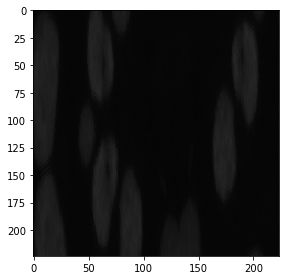

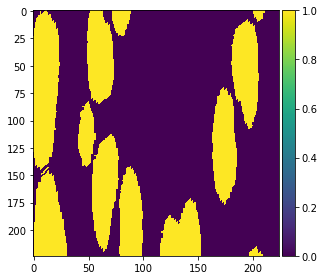

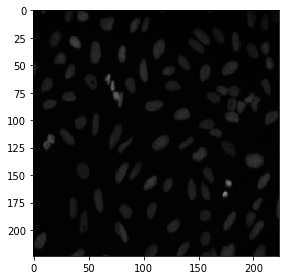

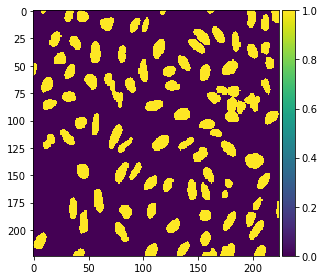

In [17]:
# Checking if the images fit

from matplotlib import pyplot as plt
%matplotlib inline

imshow(x0.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y0.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val0.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val0.next()[0].astype(np.uint8)))
plt.show()

In [ ]:
# Perform a checking by creating one model

model = get_unet()
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-0.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator0, validation_data=val_generator0, validation_steps=10, steps_per_epoch=350,
                              epochs=30, callbacks=[earlystopper, checkpointer])

In [19]:
# Now, the following trains ensemble for each seed

for s in seeds:
    # Get sample data
    X_train_tmp, Y_train_tmp = sample_data(X_train, Y_train, bag_percentage)
    x_tmp, y_tmp, x_val_tmp, y_val_tmp = get_batch_generator(X_train_tmp, Y_train_tmp, s)
    train_generator_tmp, val_generator_tmp = get_train_val_generator(x_tmp, y_tmp, x_val_tmp, y_val_tmp)
    
    model = get_unet()
    earlystopper = EarlyStopping(patience=5, verbose=0)
    checkpointer = ModelCheckpoint('model-dsbowl2018-' + str(s) + '.h5', verbose=1, save_best_only=True)
    csvlogger = CSVLogger(filename='log-dsbowl-'+ str(s) + '.csv', separator=',', append=True)
    results = model.fit_generator(train_generator_tmp, validation_data=val_generator_tmp, validation_steps=val_step_size, steps_per_epoch=train_step_size,
                              epochs=epochs, verbose=1, callbacks=[earlystopper, checkpointer, csvlogger])

dim[0:20] = [541 384 314 641 106 244 649 661 198 135 117 195 150 560 533 386 216 636
   4 357]
Epoch 1/25


115/400 [=======>......................] - ETA: 51:13 - loss: 0.6435 - mean_iou: 0.0000e+00 - binary_accuracy: 0.641 - ETA: 29:41 - loss: 0.6327 - mean_iou: 0.2041 - binary_accuracy: 0.6971    - ETA: 22:26 - loss: 0.6068 - mean_iou: 0.2722 - binary_accuracy: 0.742 - ETA: 18:50 - loss: 0.5912 - mean_iou: 0.3081 - binary_accuracy: 0.765 - ETA: 16:39 - loss: 0.5513 - mean_iou: 0.3300 - binary_accuracy: 0.790 - ETA: 15:11 - loss: 0.5281 - mean_iou: 0.3457 - binary_accuracy: 0.803 - ETA: 14:08 - loss: 0.5269 - mean_iou: 0.3572 - binary_accuracy: 0.805 - ETA: 13:21 - loss: 0.5294 - mean_iou: 0.3654 - binary_accuracy: 0.804 - ETA: 12:43 - loss: 0.5150 - mean_iou: 0.3716 - binary_accuracy: 0.811 - ETA: 12:13 - loss: 0.4963 - mean_iou: 0.3767 - binary_accuracy: 0.819 - ETA: 11:49 - loss: 0.4876 - mean_iou: 0.3811 - binary_accuracy: 0.822 - ETA: 11:27 - loss: 0.4719 - mean_iou: 0.3848 - binary_accuracy: 0.828 - ETA: 11:10 - loss: 0.4679 - mean_iou: 0.3881 - binary_accuracy: 0.828 - ETA: 10:54 - 

349/400 [=========================>....] - ETA: 3:27 - loss: 0.2146 - mean_iou: 0.5315 - binary_accuracy: 0.91 - ETA: 3:26 - loss: 0.2142 - mean_iou: 0.5320 - binary_accuracy: 0.91 - ETA: 3:25 - loss: 0.2139 - mean_iou: 0.5324 - binary_accuracy: 0.91 - ETA: 3:24 - loss: 0.2135 - mean_iou: 0.5329 - binary_accuracy: 0.91 - ETA: 3:22 - loss: 0.2129 - mean_iou: 0.5333 - binary_accuracy: 0.91 - ETA: 3:21 - loss: 0.2124 - mean_iou: 0.5338 - binary_accuracy: 0.91 - ETA: 3:20 - loss: 0.2119 - mean_iou: 0.5342 - binary_accuracy: 0.91 - ETA: 3:19 - loss: 0.2122 - mean_iou: 0.5347 - binary_accuracy: 0.91 - ETA: 3:17 - loss: 0.2118 - mean_iou: 0.5351 - binary_accuracy: 0.91 - ETA: 3:16 - loss: 0.2116 - mean_iou: 0.5355 - binary_accuracy: 0.91 - ETA: 3:15 - loss: 0.2116 - mean_iou: 0.5360 - binary_accuracy: 0.91 - ETA: 3:14 - loss: 0.2111 - mean_iou: 0.5364 - binary_accuracy: 0.91 - ETA: 3:12 - loss: 0.2111 - mean_iou: 0.5369 - binary_accuracy: 0.91 - ETA: 3:11 - loss: 0.2110 - mean_iou: 0.5373 - b

399/400 [============================>.] - ETA: 1:01 - loss: 0.1895 - mean_iou: 0.5741 - binary_accuracy: 0.92 - ETA: 1:00 - loss: 0.1892 - mean_iou: 0.5744 - binary_accuracy: 0.92 - ETA: 59s - loss: 0.1889 - mean_iou: 0.5747 - binary_accuracy: 0.9247 - ETA: 58s - loss: 0.1887 - mean_iou: 0.5750 - binary_accuracy: 0.924 - ETA: 56s - loss: 0.1885 - mean_iou: 0.5753 - binary_accuracy: 0.924 - ETA: 55s - loss: 0.1882 - mean_iou: 0.5756 - binary_accuracy: 0.925 - ETA: 54s - loss: 0.1880 - mean_iou: 0.5759 - binary_accuracy: 0.925 - ETA: 53s - loss: 0.1877 - mean_iou: 0.5762 - binary_accuracy: 0.925 - ETA: 51s - loss: 0.1878 - mean_iou: 0.5765 - binary_accuracy: 0.925 - ETA: 50s - loss: 0.1876 - mean_iou: 0.5768 - binary_accuracy: 0.925 - ETA: 49s - loss: 0.1873 - mean_iou: 0.5771 - binary_accuracy: 0.925 - ETA: 48s - loss: 0.1872 - mean_iou: 0.5774 - binary_accuracy: 0.925 - ETA: 46s - loss: 0.1869 - mean_iou: 0.5776 - binary_accuracy: 0.925 - ETA: 45s - loss: 0.1865 - mean_iou: 0.5779 - b

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1836 - mean_iou: 0.7001 - binary_accuracy: 0.93 - ETA: 8:09 - loss: 0.1457 - mean_iou: 0.7001 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.1273 - mean_iou: 0.7002 - binary_accuracy: 0.95 - ETA: 8:07 - loss: 0.1094 - mean_iou: 0.7003 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.1164 - mean_iou: 0.7004 - binary_accuracy: 0.95 - ETA: 8:04 - loss: 0.1215 - mean_iou: 0.7005 - binary_accuracy: 0.95 - ETA: 8:04 - loss: 0.1231 - mean_iou: 0.7006 - binary_accuracy: 0.95 - ETA: 8:03 - loss: 0.1178 - mean_iou: 0.7007 - binary_accuracy: 0.95 - ETA: 8:02 - loss: 0.1132 - mean_iou: 0.7008 - binary_accuracy: 0.95 - ETA: 8:01 - loss: 0.1159 - mean_iou: 0.7009 - binary_accuracy: 0.95 - ETA: 8:00 - loss: 0.1147 - mean_iou: 0.7010 - binary_accuracy: 0.95 - ETA: 7:59 - loss: 0.1169 - mean_iou: 0.7011 - binary_accuracy: 0.95 - ETA: 7:58 - loss: 0.1200 - mean_iou: 0.7013 - binary_accuracy: 0.95 - ETA: 7:28 - loss: 0.1273 - mean_iou: 0.7014 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.1092 - mean_iou: 0.7219 - binary_accuracy: 0.95 - ETA: 3:18 - loss: 0.1091 - mean_iou: 0.7219 - binary_accuracy: 0.95 - ETA: 3:17 - loss: 0.1091 - mean_iou: 0.7220 - binary_accuracy: 0.95 - ETA: 3:16 - loss: 0.1091 - mean_iou: 0.7221 - binary_accuracy: 0.95 - ETA: 3:15 - loss: 0.1090 - mean_iou: 0.7222 - binary_accuracy: 0.95 - ETA: 3:13 - loss: 0.1088 - mean_iou: 0.7223 - binary_accuracy: 0.95 - ETA: 3:12 - loss: 0.1088 - mean_iou: 0.7223 - binary_accuracy: 0.95 - ETA: 3:11 - loss: 0.1087 - mean_iou: 0.7224 - binary_accuracy: 0.95 - ETA: 3:10 - loss: 0.1087 - mean_iou: 0.7225 - binary_accuracy: 0.95 - ETA: 3:08 - loss: 0.1089 - mean_iou: 0.7226 - binary_accuracy: 0.95 - ETA: 3:07 - loss: 0.1089 - mean_iou: 0.7227 - binary_accuracy: 0.95 - ETA: 3:06 - loss: 0.1088 - mean_iou: 0.7227 - binary_accuracy: 0.95 - ETA: 3:04 - loss: 0.1089 - mean_iou: 0.7228 - binary_accuracy: 0.95 - ETA: 3:03 - loss: 0.1086 - mean_iou: 0.7229 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1083 - mean_iou: 0.7301 - binary_accuracy: 0.959 - ETA: 56s - loss: 0.1083 - mean_iou: 0.7302 - binary_accuracy: 0.959 - ETA: 55s - loss: 0.1082 - mean_iou: 0.7302 - binary_accuracy: 0.959 - ETA: 54s - loss: 0.1081 - mean_iou: 0.7303 - binary_accuracy: 0.959 - ETA: 53s - loss: 0.1082 - mean_iou: 0.7304 - binary_accuracy: 0.959 - ETA: 52s - loss: 0.1083 - mean_iou: 0.7304 - binary_accuracy: 0.959 - ETA: 50s - loss: 0.1082 - mean_iou: 0.7305 - binary_accuracy: 0.959 - ETA: 49s - loss: 0.1082 - mean_iou: 0.7305 - binary_accuracy: 0.959 - ETA: 48s - loss: 0.1083 - mean_iou: 0.7306 - binary_accuracy: 0.959 - ETA: 47s - loss: 0.1083 - mean_iou: 0.7306 - binary_accuracy: 0.959 - ETA: 46s - loss: 0.1083 - mean_iou: 0.7307 - binary_accuracy: 0.959 - ETA: 44s - loss: 0.1083 - mean_iou: 0.7308 - binary_accuracy: 0.959 - ETA: 43s - loss: 0.1082 - mean_iou: 0.7308 - binary_accuracy: 0.959 - ETA: 42s - loss: 0.1083 - mean_iou: 0.7309 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.0381 - mean_iou: 0.7565 - binary_accuracy: 0.98 - ETA: 8:08 - loss: 0.0485 - mean_iou: 0.7566 - binary_accuracy: 0.98 - ETA: 8:05 - loss: 0.0565 - mean_iou: 0.7567 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0558 - mean_iou: 0.7568 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0731 - mean_iou: 0.7568 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0718 - mean_iou: 0.7569 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0811 - mean_iou: 0.7569 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0910 - mean_iou: 0.7570 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0898 - mean_iou: 0.7570 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0903 - mean_iou: 0.7571 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0871 - mean_iou: 0.7571 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0860 - mean_iou: 0.7572 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0866 - mean_iou: 0.7572 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0896 - mean_iou: 0.7573 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0975 - mean_iou: 0.7647 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0974 - mean_iou: 0.7647 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0974 - mean_iou: 0.7647 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0973 - mean_iou: 0.7648 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0974 - mean_iou: 0.7648 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0973 - mean_iou: 0.7648 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0971 - mean_iou: 0.7649 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0970 - mean_iou: 0.7649 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0968 - mean_iou: 0.7649 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0968 - mean_iou: 0.7650 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0967 - mean_iou: 0.7650 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0965 - mean_iou: 0.7650 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0963 - mean_iou: 0.7651 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0964 - mean_iou: 0.7651 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0945 - mean_iou: 0.7683 - binary_accuracy: 0.964 - ETA: 56s - loss: 0.0945 - mean_iou: 0.7684 - binary_accuracy: 0.964 - ETA: 55s - loss: 0.0945 - mean_iou: 0.7684 - binary_accuracy: 0.964 - ETA: 54s - loss: 0.0945 - mean_iou: 0.7684 - binary_accuracy: 0.964 - ETA: 53s - loss: 0.0945 - mean_iou: 0.7685 - binary_accuracy: 0.964 - ETA: 52s - loss: 0.0944 - mean_iou: 0.7685 - binary_accuracy: 0.964 - ETA: 50s - loss: 0.0944 - mean_iou: 0.7685 - binary_accuracy: 0.964 - ETA: 49s - loss: 0.0943 - mean_iou: 0.7685 - binary_accuracy: 0.964 - ETA: 48s - loss: 0.0945 - mean_iou: 0.7686 - binary_accuracy: 0.964 - ETA: 47s - loss: 0.0943 - mean_iou: 0.7686 - binary_accuracy: 0.964 - ETA: 46s - loss: 0.0944 - mean_iou: 0.7686 - binary_accuracy: 0.964 - ETA: 44s - loss: 0.0943 - mean_iou: 0.7687 - binary_accuracy: 0.964 - ETA: 43s - loss: 0.0942 - mean_iou: 0.7687 - binary_accuracy: 0.964 - ETA: 42s - loss: 0.0941 - mean_iou: 0.7687 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1321 - mean_iou: 0.7828 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.1031 - mean_iou: 0.7828 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0794 - mean_iou: 0.7828 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.1025 - mean_iou: 0.7828 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0940 - mean_iou: 0.7829 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0917 - mean_iou: 0.7829 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0911 - mean_iou: 0.7829 - binary_accuracy: 0.96 - ETA: 8:09 - loss: 0.0868 - mean_iou: 0.7830 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0847 - mean_iou: 0.7830 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0865 - mean_iou: 0.7831 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0859 - mean_iou: 0.7831 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0854 - mean_iou: 0.7831 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0837 - mean_iou: 0.7832 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0815 - mean_iou: 0.7832 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0887 - mean_iou: 0.7875 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0886 - mean_iou: 0.7875 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0884 - mean_iou: 0.7876 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0883 - mean_iou: 0.7876 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0882 - mean_iou: 0.7876 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0882 - mean_iou: 0.7876 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0883 - mean_iou: 0.7876 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0881 - mean_iou: 0.7876 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0883 - mean_iou: 0.7877 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0884 - mean_iou: 0.7877 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0882 - mean_iou: 0.7877 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0880 - mean_iou: 0.7877 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0879 - mean_iou: 0.7877 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0879 - mean_iou: 0.7877 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0863 - mean_iou: 0.7896 - binary_accuracy: 0.966 - ETA: 57s - loss: 0.0863 - mean_iou: 0.7896 - binary_accuracy: 0.966 - ETA: 55s - loss: 0.0863 - mean_iou: 0.7896 - binary_accuracy: 0.966 - ETA: 54s - loss: 0.0862 - mean_iou: 0.7896 - binary_accuracy: 0.966 - ETA: 53s - loss: 0.0863 - mean_iou: 0.7896 - binary_accuracy: 0.966 - ETA: 52s - loss: 0.0862 - mean_iou: 0.7897 - binary_accuracy: 0.966 - ETA: 50s - loss: 0.0863 - mean_iou: 0.7897 - binary_accuracy: 0.966 - ETA: 49s - loss: 0.0862 - mean_iou: 0.7897 - binary_accuracy: 0.966 - ETA: 48s - loss: 0.0862 - mean_iou: 0.7897 - binary_accuracy: 0.966 - ETA: 47s - loss: 0.0862 - mean_iou: 0.7897 - binary_accuracy: 0.966 - ETA: 46s - loss: 0.0862 - mean_iou: 0.7897 - binary_accuracy: 0.966 - ETA: 44s - loss: 0.0863 - mean_iou: 0.7898 - binary_accuracy: 0.966 - ETA: 43s - loss: 0.0861 - mean_iou: 0.7898 - binary_accuracy: 0.966 - ETA: 42s - loss: 0.0863 - mean_iou: 0.7898 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.0984 - mean_iou: 0.7978 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0969 - mean_iou: 0.7978 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.1033 - mean_iou: 0.7978 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.1085 - mean_iou: 0.7978 - binary_accuracy: 0.95 - ETA: 8:00 - loss: 0.1107 - mean_iou: 0.7978 - binary_accuracy: 0.95 - ETA: 8:01 - loss: 0.1077 - mean_iou: 0.7978 - binary_accuracy: 0.95 - ETA: 7:59 - loss: 0.0998 - mean_iou: 0.7978 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.1049 - mean_iou: 0.7978 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.1000 - mean_iou: 0.7978 - binary_accuracy: 0.96 - ETA: 7:18 - loss: 0.0977 - mean_iou: 0.7978 - binary_accuracy: 0.96 - ETA: 7:20 - loss: 0.0972 - mean_iou: 0.7978 - binary_accuracy: 0.96 - ETA: 7:23 - loss: 0.0930 - mean_iou: 0.7978 - binary_accuracy: 0.96 - ETA: 7:25 - loss: 0.0902 - mean_iou: 0.7979 - binary_accuracy: 0.96 - ETA: 7:25 - loss: 0.0866 - mean_iou: 0.7979 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0833 - mean_iou: 0.8007 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0833 - mean_iou: 0.8007 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0831 - mean_iou: 0.8007 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0831 - mean_iou: 0.8007 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0831 - mean_iou: 0.8007 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0829 - mean_iou: 0.8007 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0829 - mean_iou: 0.8008 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0828 - mean_iou: 0.8008 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0826 - mean_iou: 0.8008 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0824 - mean_iou: 0.8008 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0826 - mean_iou: 0.8008 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0824 - mean_iou: 0.8008 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0823 - mean_iou: 0.8008 - binary_accuracy: 0.96 - ETA: 3:03 - loss: 0.0821 - mean_iou: 0.8008 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0830 - mean_iou: 0.8020 - binary_accuracy: 0.967 - ETA: 56s - loss: 0.0829 - mean_iou: 0.8020 - binary_accuracy: 0.967 - ETA: 55s - loss: 0.0829 - mean_iou: 0.8020 - binary_accuracy: 0.967 - ETA: 54s - loss: 0.0829 - mean_iou: 0.8020 - binary_accuracy: 0.967 - ETA: 53s - loss: 0.0828 - mean_iou: 0.8020 - binary_accuracy: 0.967 - ETA: 52s - loss: 0.0828 - mean_iou: 0.8021 - binary_accuracy: 0.967 - ETA: 50s - loss: 0.0826 - mean_iou: 0.8021 - binary_accuracy: 0.967 - ETA: 49s - loss: 0.0825 - mean_iou: 0.8021 - binary_accuracy: 0.968 - ETA: 48s - loss: 0.0827 - mean_iou: 0.8021 - binary_accuracy: 0.967 - ETA: 47s - loss: 0.0828 - mean_iou: 0.8021 - binary_accuracy: 0.967 - ETA: 46s - loss: 0.0830 - mean_iou: 0.8021 - binary_accuracy: 0.967 - ETA: 44s - loss: 0.0828 - mean_iou: 0.8021 - binary_accuracy: 0.967 - ETA: 43s - loss: 0.0829 - mean_iou: 0.8021 - binary_accuracy: 0.967 - ETA: 42s - loss: 0.0829 - mean_iou: 0.8021 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0523 - mean_iou: 0.8070 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0534 - mean_iou: 0.8070 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0717 - mean_iou: 0.8070 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0640 - mean_iou: 0.8070 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0724 - mean_iou: 0.8070 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0767 - mean_iou: 0.8070 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0781 - mean_iou: 0.8071 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0758 - mean_iou: 0.8071 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0758 - mean_iou: 0.8071 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0775 - mean_iou: 0.8071 - binary_accuracy: 0.96 - ETA: 7:55 - loss: 0.0756 - mean_iou: 0.8071 - binary_accuracy: 0.96 - ETA: 7:54 - loss: 0.0784 - mean_iou: 0.8071 - binary_accuracy: 0.96 - ETA: 7:53 - loss: 0.0799 - mean_iou: 0.8071 - binary_accuracy: 0.96 - ETA: 7:52 - loss: 0.0853 - mean_iou: 0.8071 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0809 - mean_iou: 0.8090 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0808 - mean_iou: 0.8090 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0810 - mean_iou: 0.8090 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0810 - mean_iou: 0.8090 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0809 - mean_iou: 0.8091 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0808 - mean_iou: 0.8091 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0807 - mean_iou: 0.8091 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0809 - mean_iou: 0.8091 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0808 - mean_iou: 0.8091 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0810 - mean_iou: 0.8091 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0810 - mean_iou: 0.8091 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0810 - mean_iou: 0.8091 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0811 - mean_iou: 0.8091 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0811 - mean_iou: 0.8091 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0812 - mean_iou: 0.8100 - binary_accuracy: 0.968 - ETA: 56s - loss: 0.0811 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 55s - loss: 0.0810 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 54s - loss: 0.0811 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 53s - loss: 0.0811 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 52s - loss: 0.0812 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 50s - loss: 0.0810 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 49s - loss: 0.0810 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 48s - loss: 0.0810 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 47s - loss: 0.0809 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 46s - loss: 0.0808 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 44s - loss: 0.0807 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 43s - loss: 0.0806 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 42s - loss: 0.0805 - mean_iou: 0.8102 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0875 - mean_iou: 0.8139 - binary_accuracy: 0.96 - ETA: 8:17 - loss: 0.0961 - mean_iou: 0.8139 - binary_accuracy: 0.95 - ETA: 8:12 - loss: 0.0868 - mean_iou: 0.8139 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0879 - mean_iou: 0.8139 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0805 - mean_iou: 0.8139 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0836 - mean_iou: 0.8139 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0890 - mean_iou: 0.8139 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0919 - mean_iou: 0.8139 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0867 - mean_iou: 0.8139 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0823 - mean_iou: 0.8139 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0784 - mean_iou: 0.8140 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0786 - mean_iou: 0.8140 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0798 - mean_iou: 0.8140 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0796 - mean_iou: 0.8140 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0775 - mean_iou: 0.8155 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0774 - mean_iou: 0.8155 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0772 - mean_iou: 0.8155 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0772 - mean_iou: 0.8155 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0772 - mean_iou: 0.8155 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0771 - mean_iou: 0.8156 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0770 - mean_iou: 0.8156 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0770 - mean_iou: 0.8156 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0769 - mean_iou: 0.8156 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0770 - mean_iou: 0.8156 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0773 - mean_iou: 0.8156 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0774 - mean_iou: 0.8156 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0775 - mean_iou: 0.8156 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0777 - mean_iou: 0.8156 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0778 - mean_iou: 0.8163 - binary_accuracy: 0.969 - ETA: 57s - loss: 0.0779 - mean_iou: 0.8163 - binary_accuracy: 0.969 - ETA: 55s - loss: 0.0779 - mean_iou: 0.8163 - binary_accuracy: 0.969 - ETA: 54s - loss: 0.0779 - mean_iou: 0.8163 - binary_accuracy: 0.969 - ETA: 53s - loss: 0.0778 - mean_iou: 0.8163 - binary_accuracy: 0.969 - ETA: 52s - loss: 0.0779 - mean_iou: 0.8164 - binary_accuracy: 0.969 - ETA: 50s - loss: 0.0780 - mean_iou: 0.8164 - binary_accuracy: 0.969 - ETA: 49s - loss: 0.0779 - mean_iou: 0.8164 - binary_accuracy: 0.969 - ETA: 48s - loss: 0.0778 - mean_iou: 0.8164 - binary_accuracy: 0.969 - ETA: 47s - loss: 0.0777 - mean_iou: 0.8164 - binary_accuracy: 0.969 - ETA: 46s - loss: 0.0776 - mean_iou: 0.8164 - binary_accuracy: 0.969 - ETA: 44s - loss: 0.0777 - mean_iou: 0.8164 - binary_accuracy: 0.969 - ETA: 43s - loss: 0.0777 - mean_iou: 0.8164 - binary_accuracy: 0.969 - ETA: 42s - loss: 0.0777 - mean_iou: 0.8164 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1056 - mean_iou: 0.8196 - binary_accuracy: 0.95 - ETA: 8:14 - loss: 0.0687 - mean_iou: 0.8196 - binary_accuracy: 0.96 - ETA: 8:12 - loss: 0.0789 - mean_iou: 0.8196 - binary_accuracy: 0.96 - ETA: 8:11 - loss: 0.0723 - mean_iou: 0.8196 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0716 - mean_iou: 0.8197 - binary_accuracy: 0.97 - ETA: 7:00 - loss: 0.0674 - mean_iou: 0.8197 - binary_accuracy: 0.97 - ETA: 7:09 - loss: 0.0679 - mean_iou: 0.8197 - binary_accuracy: 0.97 - ETA: 7:14 - loss: 0.0673 - mean_iou: 0.8197 - binary_accuracy: 0.97 - ETA: 7:18 - loss: 0.0688 - mean_iou: 0.8197 - binary_accuracy: 0.97 - ETA: 7:20 - loss: 0.0691 - mean_iou: 0.8197 - binary_accuracy: 0.97 - ETA: 7:23 - loss: 0.0744 - mean_iou: 0.8197 - binary_accuracy: 0.97 - ETA: 7:25 - loss: 0.0718 - mean_iou: 0.8197 - binary_accuracy: 0.97 - ETA: 7:27 - loss: 0.0701 - mean_iou: 0.8197 - binary_accuracy: 0.97 - ETA: 7:28 - loss: 0.0713 - mean_iou: 0.8197 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0730 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0729 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0730 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0731 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0732 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0732 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0732 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0732 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0734 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0733 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0734 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0735 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0733 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:03 - loss: 0.0732 - mean_iou: 0.8212 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0733 - mean_iou: 0.8218 - binary_accuracy: 0.971 - ETA: 56s - loss: 0.0733 - mean_iou: 0.8218 - binary_accuracy: 0.971 - ETA: 55s - loss: 0.0735 - mean_iou: 0.8218 - binary_accuracy: 0.971 - ETA: 54s - loss: 0.0735 - mean_iou: 0.8218 - binary_accuracy: 0.971 - ETA: 53s - loss: 0.0735 - mean_iou: 0.8218 - binary_accuracy: 0.971 - ETA: 51s - loss: 0.0735 - mean_iou: 0.8218 - binary_accuracy: 0.971 - ETA: 50s - loss: 0.0734 - mean_iou: 0.8218 - binary_accuracy: 0.971 - ETA: 49s - loss: 0.0734 - mean_iou: 0.8218 - binary_accuracy: 0.971 - ETA: 48s - loss: 0.0733 - mean_iou: 0.8218 - binary_accuracy: 0.971 - ETA: 47s - loss: 0.0733 - mean_iou: 0.8218 - binary_accuracy: 0.971 - ETA: 45s - loss: 0.0736 - mean_iou: 0.8219 - binary_accuracy: 0.971 - ETA: 44s - loss: 0.0736 - mean_iou: 0.8219 - binary_accuracy: 0.971 - ETA: 43s - loss: 0.0736 - mean_iou: 0.8219 - binary_accuracy: 0.971 - ETA: 42s - loss: 0.0735 - mean_iou: 0.8219 - bi

117/400 [=======>......................] - ETA: 8:18 - loss: 0.0532 - mean_iou: 0.8245 - binary_accuracy: 0.97 - ETA: 8:14 - loss: 0.0596 - mean_iou: 0.8245 - binary_accuracy: 0.97 - ETA: 8:12 - loss: 0.0805 - mean_iou: 0.8246 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0755 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0781 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0760 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0721 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0715 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0808 - mean_iou: 0.8246 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0790 - mean_iou: 0.8246 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0772 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0750 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0777 - mean_iou: 0.8246 - binary_accuracy: 0.96 - ETA: 7:55 - loss: 0.0755 - mean_iou: 0.8246 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0840 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0840 - mean_iou: 0.8254 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0839 - mean_iou: 0.8254 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0839 - mean_iou: 0.8254 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0838 - mean_iou: 0.8254 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0839 - mean_iou: 0.8254 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0838 - mean_iou: 0.8254 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0837 - mean_iou: 0.8254 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0837 - mean_iou: 0.8254 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0837 - mean_iou: 0.8254 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0840 - mean_iou: 0.8254 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0838 - mean_iou: 0.8254 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0837 - mean_iou: 0.8254 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0835 - mean_iou: 0.8254 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0820 - mean_iou: 0.8257 - binary_accuracy: 0.968 - ETA: 56s - loss: 0.0821 - mean_iou: 0.8257 - binary_accuracy: 0.968 - ETA: 55s - loss: 0.0822 - mean_iou: 0.8257 - binary_accuracy: 0.968 - ETA: 54s - loss: 0.0822 - mean_iou: 0.8257 - binary_accuracy: 0.968 - ETA: 53s - loss: 0.0821 - mean_iou: 0.8257 - binary_accuracy: 0.968 - ETA: 52s - loss: 0.0820 - mean_iou: 0.8257 - binary_accuracy: 0.968 - ETA: 50s - loss: 0.0823 - mean_iou: 0.8257 - binary_accuracy: 0.968 - ETA: 49s - loss: 0.0822 - mean_iou: 0.8257 - binary_accuracy: 0.968 - ETA: 48s - loss: 0.0822 - mean_iou: 0.8257 - binary_accuracy: 0.968 - ETA: 47s - loss: 0.0821 - mean_iou: 0.8257 - binary_accuracy: 0.968 - ETA: 46s - loss: 0.0821 - mean_iou: 0.8257 - binary_accuracy: 0.968 - ETA: 44s - loss: 0.0821 - mean_iou: 0.8257 - binary_accuracy: 0.968 - ETA: 43s - loss: 0.0822 - mean_iou: 0.8258 - binary_accuracy: 0.968 - ETA: 42s - loss: 0.0820 - mean_iou: 0.8258 - bi

117/400 [=======>......................] - ETA: 8:18 - loss: 0.1221 - mean_iou: 0.8276 - binary_accuracy: 0.95 - ETA: 8:11 - loss: 0.0950 - mean_iou: 0.8276 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0913 - mean_iou: 0.8276 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.1045 - mean_iou: 0.8276 - binary_accuracy: 0.95 - ETA: 8:06 - loss: 0.0968 - mean_iou: 0.8276 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0924 - mean_iou: 0.8276 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0905 - mean_iou: 0.8276 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0940 - mean_iou: 0.8276 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0958 - mean_iou: 0.8276 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0912 - mean_iou: 0.8276 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0917 - mean_iou: 0.8276 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0937 - mean_iou: 0.8276 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0961 - mean_iou: 0.8276 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0980 - mean_iou: 0.8276 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0741 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0742 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0742 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0741 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0740 - mean_iou: 0.8286 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0740 - mean_iou: 0.8286 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0740 - mean_iou: 0.8286 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0740 - mean_iou: 0.8286 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0740 - mean_iou: 0.8286 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0740 - mean_iou: 0.8286 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0741 - mean_iou: 0.8286 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0740 - mean_iou: 0.8286 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0741 - mean_iou: 0.8286 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0741 - mean_iou: 0.8286 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0726 - mean_iou: 0.8290 - binary_accuracy: 0.971 - ETA: 56s - loss: 0.0726 - mean_iou: 0.8290 - binary_accuracy: 0.971 - ETA: 55s - loss: 0.0725 - mean_iou: 0.8290 - binary_accuracy: 0.971 - ETA: 54s - loss: 0.0726 - mean_iou: 0.8290 - binary_accuracy: 0.971 - ETA: 53s - loss: 0.0724 - mean_iou: 0.8290 - binary_accuracy: 0.971 - ETA: 52s - loss: 0.0724 - mean_iou: 0.8290 - binary_accuracy: 0.971 - ETA: 50s - loss: 0.0724 - mean_iou: 0.8290 - binary_accuracy: 0.971 - ETA: 49s - loss: 0.0724 - mean_iou: 0.8291 - binary_accuracy: 0.971 - ETA: 48s - loss: 0.0723 - mean_iou: 0.8291 - binary_accuracy: 0.971 - ETA: 47s - loss: 0.0724 - mean_iou: 0.8291 - binary_accuracy: 0.971 - ETA: 45s - loss: 0.0724 - mean_iou: 0.8291 - binary_accuracy: 0.971 - ETA: 44s - loss: 0.0723 - mean_iou: 0.8291 - binary_accuracy: 0.971 - ETA: 43s - loss: 0.0723 - mean_iou: 0.8291 - binary_accuracy: 0.971 - ETA: 42s - loss: 0.0723 - mean_iou: 0.8291 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0586 - mean_iou: 0.8311 - binary_accuracy: 0.97 - ETA: 4:46 - loss: 0.0385 - mean_iou: 0.8311 - binary_accuracy: 0.98 - ETA: 5:51 - loss: 0.0408 - mean_iou: 0.8311 - binary_accuracy: 0.98 - ETA: 6:26 - loss: 0.0418 - mean_iou: 0.8311 - binary_accuracy: 0.98 - ETA: 6:43 - loss: 0.0448 - mean_iou: 0.8311 - binary_accuracy: 0.98 - ETA: 6:57 - loss: 0.0480 - mean_iou: 0.8311 - binary_accuracy: 0.98 - ETA: 7:07 - loss: 0.0508 - mean_iou: 0.8311 - binary_accuracy: 0.97 - ETA: 7:12 - loss: 0.0514 - mean_iou: 0.8311 - binary_accuracy: 0.97 - ETA: 7:17 - loss: 0.0512 - mean_iou: 0.8311 - binary_accuracy: 0.97 - ETA: 7:20 - loss: 0.0553 - mean_iou: 0.8311 - binary_accuracy: 0.97 - ETA: 7:23 - loss: 0.0541 - mean_iou: 0.8311 - binary_accuracy: 0.97 - ETA: 7:24 - loss: 0.0577 - mean_iou: 0.8311 - binary_accuracy: 0.97 - ETA: 7:26 - loss: 0.0570 - mean_iou: 0.8311 - binary_accuracy: 0.97 - ETA: 7:27 - loss: 0.0623 - mean_iou: 0.8311 - b

351/400 [=========================>....] - ETA: 3:18 - loss: 0.0712 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0713 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0717 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0716 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0716 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0716 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0716 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0719 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0720 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0719 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0720 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0719 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0717 - mean_iou: 0.8319 - binary_accuracy: 0.97 - ETA: 3:03 - loss: 0.0718 - mean_iou: 0.8319 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0724 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 56s - loss: 0.0725 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 55s - loss: 0.0724 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 54s - loss: 0.0724 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 53s - loss: 0.0725 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 51s - loss: 0.0724 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 50s - loss: 0.0723 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 49s - loss: 0.0723 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 48s - loss: 0.0722 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 47s - loss: 0.0723 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 45s - loss: 0.0723 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 44s - loss: 0.0724 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 43s - loss: 0.0723 - mean_iou: 0.8323 - binary_accuracy: 0.971 - ETA: 42s - loss: 0.0723 - mean_iou: 0.8323 - bi

117/400 [=======>......................] - ETA: 8:18 - loss: 0.0628 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 8:17 - loss: 0.0552 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 8:14 - loss: 0.0668 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0579 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0572 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0673 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0682 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0721 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0741 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0740 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0730 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0724 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0750 - mean_iou: 0.8339 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0766 - mean_iou: 0.8339 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0718 - mean_iou: 0.8346 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0718 - mean_iou: 0.8346 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0719 - mean_iou: 0.8346 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0720 - mean_iou: 0.8346 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0719 - mean_iou: 0.8346 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0718 - mean_iou: 0.8346 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0720 - mean_iou: 0.8346 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0719 - mean_iou: 0.8347 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0719 - mean_iou: 0.8347 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0719 - mean_iou: 0.8347 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0718 - mean_iou: 0.8347 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0724 - mean_iou: 0.8347 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0723 - mean_iou: 0.8347 - binary_accuracy: 0.97 - ETA: 3:03 - loss: 0.0722 - mean_iou: 0.8347 - b

399/400 [============================>.] - ETA: 57s - loss: 0.0762 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 56s - loss: 0.0763 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0764 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0764 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0763 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 51s - loss: 0.0763 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 50s - loss: 0.0764 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0764 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0763 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0762 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 45s - loss: 0.0762 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 44s - loss: 0.0761 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0760 - mean_iou: 0.8349 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0759 - mean_iou: 0.8349 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0829 - mean_iou: 0.8361 - binary_accuracy: 0.96 - ETA: 8:11 - loss: 0.0611 - mean_iou: 0.8361 - binary_accuracy: 0.97 - ETA: 8:09 - loss: 0.0560 - mean_iou: 0.8361 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0590 - mean_iou: 0.8361 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0591 - mean_iou: 0.8361 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0615 - mean_iou: 0.8361 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0572 - mean_iou: 0.8361 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0573 - mean_iou: 0.8361 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0650 - mean_iou: 0.8361 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0666 - mean_iou: 0.8361 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0661 - mean_iou: 0.8361 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0647 - mean_iou: 0.8361 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0634 - mean_iou: 0.8361 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0649 - mean_iou: 0.8361 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0733 - mean_iou: 0.8366 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0735 - mean_iou: 0.8366 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0735 - mean_iou: 0.8366 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0733 - mean_iou: 0.8367 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0733 - mean_iou: 0.8367 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0732 - mean_iou: 0.8367 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0731 - mean_iou: 0.8367 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0729 - mean_iou: 0.8367 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0728 - mean_iou: 0.8367 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0726 - mean_iou: 0.8367 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0726 - mean_iou: 0.8367 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0725 - mean_iou: 0.8367 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0726 - mean_iou: 0.8367 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0726 - mean_iou: 0.8367 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0718 - mean_iou: 0.8369 - binary_accuracy: 0.971 - ETA: 56s - loss: 0.0720 - mean_iou: 0.8369 - binary_accuracy: 0.971 - ETA: 55s - loss: 0.0719 - mean_iou: 0.8369 - binary_accuracy: 0.971 - ETA: 54s - loss: 0.0719 - mean_iou: 0.8369 - binary_accuracy: 0.971 - ETA: 53s - loss: 0.0718 - mean_iou: 0.8369 - binary_accuracy: 0.971 - ETA: 52s - loss: 0.0720 - mean_iou: 0.8369 - binary_accuracy: 0.971 - ETA: 50s - loss: 0.0719 - mean_iou: 0.8369 - binary_accuracy: 0.971 - ETA: 49s - loss: 0.0719 - mean_iou: 0.8370 - binary_accuracy: 0.971 - ETA: 48s - loss: 0.0718 - mean_iou: 0.8370 - binary_accuracy: 0.971 - ETA: 47s - loss: 0.0717 - mean_iou: 0.8370 - binary_accuracy: 0.971 - ETA: 45s - loss: 0.0718 - mean_iou: 0.8370 - binary_accuracy: 0.971 - ETA: 44s - loss: 0.0718 - mean_iou: 0.8370 - binary_accuracy: 0.971 - ETA: 43s - loss: 0.0718 - mean_iou: 0.8370 - binary_accuracy: 0.971 - ETA: 42s - loss: 0.0718 - mean_iou: 0.8370 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0719 - mean_iou: 0.8381 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0607 - mean_iou: 0.8381 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0670 - mean_iou: 0.8381 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0842 - mean_iou: 0.8381 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0807 - mean_iou: 0.8381 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0760 - mean_iou: 0.8381 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0702 - mean_iou: 0.8381 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0680 - mean_iou: 0.8381 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0712 - mean_iou: 0.8381 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0674 - mean_iou: 0.8381 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0740 - mean_iou: 0.8381 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0712 - mean_iou: 0.8381 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0708 - mean_iou: 0.8381 - binary_accuracy: 0.97 - ETA: 7:55 - loss: 0.0701 - mean_iou: 0.8381 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0726 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0726 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0725 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0723 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0723 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0722 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0722 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0723 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0723 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0724 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0727 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0726 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0726 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 3:03 - loss: 0.0725 - mean_iou: 0.8387 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0743 - mean_iou: 0.8389 - binary_accuracy: 0.971 - ETA: 56s - loss: 0.0743 - mean_iou: 0.8389 - binary_accuracy: 0.971 - ETA: 55s - loss: 0.0742 - mean_iou: 0.8389 - binary_accuracy: 0.971 - ETA: 54s - loss: 0.0742 - mean_iou: 0.8389 - binary_accuracy: 0.971 - ETA: 53s - loss: 0.0743 - mean_iou: 0.8389 - binary_accuracy: 0.971 - ETA: 52s - loss: 0.0742 - mean_iou: 0.8389 - binary_accuracy: 0.971 - ETA: 50s - loss: 0.0742 - mean_iou: 0.8390 - binary_accuracy: 0.971 - ETA: 49s - loss: 0.0742 - mean_iou: 0.8390 - binary_accuracy: 0.971 - ETA: 48s - loss: 0.0740 - mean_iou: 0.8390 - binary_accuracy: 0.971 - ETA: 47s - loss: 0.0739 - mean_iou: 0.8390 - binary_accuracy: 0.971 - ETA: 46s - loss: 0.0739 - mean_iou: 0.8390 - binary_accuracy: 0.971 - ETA: 44s - loss: 0.0739 - mean_iou: 0.8390 - binary_accuracy: 0.971 - ETA: 43s - loss: 0.0740 - mean_iou: 0.8390 - binary_accuracy: 0.971 - ETA: 42s - loss: 0.0740 - mean_iou: 0.8390 - bi

117/400 [=======>......................] - ETA: 8:18 - loss: 0.0553 - mean_iou: 0.8400 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0762 - mean_iou: 0.8400 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0669 - mean_iou: 0.8400 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0627 - mean_iou: 0.8400 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0711 - mean_iou: 0.8400 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0695 - mean_iou: 0.8400 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0718 - mean_iou: 0.8400 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0706 - mean_iou: 0.8400 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0754 - mean_iou: 0.8400 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0712 - mean_iou: 0.8400 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0688 - mean_iou: 0.8400 - binary_accuracy: 0.97 - ETA: 7:25 - loss: 0.0716 - mean_iou: 0.8400 - binary_accuracy: 0.97 - ETA: 7:27 - loss: 0.0695 - mean_iou: 0.8400 - binary_accuracy: 0.97 - ETA: 7:28 - loss: 0.0708 - mean_iou: 0.8400 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0697 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0696 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0695 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0697 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0698 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0700 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0700 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0697 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0698 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0698 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0702 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0703 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0703 - mean_iou: 0.8406 - binary_accuracy: 0.97 - ETA: 3:03 - loss: 0.0702 - mean_iou: 0.8406 - b

399/400 [============================>.] - ETA: 57s - loss: 0.0694 - mean_iou: 0.8409 - binary_accuracy: 0.972 - ETA: 56s - loss: 0.0694 - mean_iou: 0.8409 - binary_accuracy: 0.972 - ETA: 55s - loss: 0.0694 - mean_iou: 0.8409 - binary_accuracy: 0.972 - ETA: 54s - loss: 0.0693 - mean_iou: 0.8409 - binary_accuracy: 0.972 - ETA: 53s - loss: 0.0696 - mean_iou: 0.8409 - binary_accuracy: 0.972 - ETA: 51s - loss: 0.0696 - mean_iou: 0.8409 - binary_accuracy: 0.972 - ETA: 50s - loss: 0.0695 - mean_iou: 0.8409 - binary_accuracy: 0.972 - ETA: 49s - loss: 0.0695 - mean_iou: 0.8409 - binary_accuracy: 0.972 - ETA: 48s - loss: 0.0694 - mean_iou: 0.8409 - binary_accuracy: 0.972 - ETA: 47s - loss: 0.0694 - mean_iou: 0.8409 - binary_accuracy: 0.972 - ETA: 45s - loss: 0.0692 - mean_iou: 0.8409 - binary_accuracy: 0.972 - ETA: 44s - loss: 0.0691 - mean_iou: 0.8409 - binary_accuracy: 0.973 - ETA: 43s - loss: 0.0692 - mean_iou: 0.8409 - binary_accuracy: 0.972 - ETA: 42s - loss: 0.0693 - mean_iou: 0.8409 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0657 - mean_iou: 0.8421 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0710 - mean_iou: 0.8421 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0704 - mean_iou: 0.8421 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0755 - mean_iou: 0.8421 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0704 - mean_iou: 0.8421 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0640 - mean_iou: 0.8421 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0648 - mean_iou: 0.8421 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0663 - mean_iou: 0.8421 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0677 - mean_iou: 0.8421 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0644 - mean_iou: 0.8421 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0640 - mean_iou: 0.8421 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0669 - mean_iou: 0.8421 - binary_accuracy: 0.97 - ETA: 7:55 - loss: 0.0648 - mean_iou: 0.8421 - binary_accuracy: 0.97 - ETA: 7:55 - loss: 0.0631 - mean_iou: 0.8421 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0677 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0676 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0674 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0675 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0675 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0675 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0680 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0681 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0681 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0682 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0681 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0679 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0679 - mean_iou: 0.8426 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0679 - mean_iou: 0.8426 - b

399/400 [============================>.] - ETA: 57s - loss: 0.0685 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 56s - loss: 0.0685 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 55s - loss: 0.0685 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 54s - loss: 0.0685 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 53s - loss: 0.0686 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 51s - loss: 0.0685 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 50s - loss: 0.0684 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 49s - loss: 0.0685 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 48s - loss: 0.0684 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 47s - loss: 0.0684 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 45s - loss: 0.0684 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 44s - loss: 0.0684 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 43s - loss: 0.0685 - mean_iou: 0.8428 - binary_accuracy: 0.973 - ETA: 42s - loss: 0.0684 - mean_iou: 0.8428 - bi

117/400 [=======>......................] - ETA: 23:47 - loss: 0.7093 - mean_iou: 0.0000e+00 - binary_accuracy: 0.484 - ETA: 15:57 - loss: 0.6724 - mean_iou: 0.2116 - binary_accuracy: 0.5962    - ETA: 13:20 - loss: 0.6546 - mean_iou: 0.2822 - binary_accuracy: 0.661 - ETA: 12:02 - loss: 0.6269 - mean_iou: 0.3159 - binary_accuracy: 0.697 - ETA: 11:14 - loss: 0.6179 - mean_iou: 0.3356 - binary_accuracy: 0.712 - ETA: 10:42 - loss: 0.6331 - mean_iou: 0.3478 - binary_accuracy: 0.711 - ETA: 10:17 - loss: 0.6130 - mean_iou: 0.3568 - binary_accuracy: 0.727 - ETA: 9:58 - loss: 0.5941 - mean_iou: 0.3636 - binary_accuracy: 0.741 - ETA: 9:44 - loss: 0.5721 - mean_iou: 0.3690 - binary_accuracy: 0.75 - ETA: 9:32 - loss: 0.5495 - mean_iou: 0.3736 - binary_accuracy: 0.77 - ETA: 9:23 - loss: 0.5331 - mean_iou: 0.3778 - binary_accuracy: 0.78 - ETA: 9:14 - loss: 0.5252 - mean_iou: 0.3814 - binary_accuracy: 0.78 - ETA: 9:07 - loss: 0.5233 - mean_iou: 0.3845 - binary_accuracy: 0.78 - ETA: 9:01 - loss: 0.5139

351/400 [=========================>....] - ETA: 3:21 - loss: 0.2297 - mean_iou: 0.5457 - binary_accuracy: 0.91 - ETA: 3:20 - loss: 0.2290 - mean_iou: 0.5462 - binary_accuracy: 0.91 - ETA: 3:19 - loss: 0.2287 - mean_iou: 0.5466 - binary_accuracy: 0.91 - ETA: 3:18 - loss: 0.2285 - mean_iou: 0.5470 - binary_accuracy: 0.91 - ETA: 3:17 - loss: 0.2282 - mean_iou: 0.5475 - binary_accuracy: 0.91 - ETA: 3:15 - loss: 0.2278 - mean_iou: 0.5479 - binary_accuracy: 0.91 - ETA: 3:14 - loss: 0.2276 - mean_iou: 0.5484 - binary_accuracy: 0.91 - ETA: 3:13 - loss: 0.2271 - mean_iou: 0.5488 - binary_accuracy: 0.91 - ETA: 3:12 - loss: 0.2267 - mean_iou: 0.5492 - binary_accuracy: 0.91 - ETA: 3:11 - loss: 0.2263 - mean_iou: 0.5497 - binary_accuracy: 0.91 - ETA: 3:09 - loss: 0.2260 - mean_iou: 0.5501 - binary_accuracy: 0.91 - ETA: 3:08 - loss: 0.2254 - mean_iou: 0.5505 - binary_accuracy: 0.91 - ETA: 3:07 - loss: 0.2251 - mean_iou: 0.5510 - binary_accuracy: 0.91 - ETA: 3:06 - loss: 0.2247 - mean_iou: 0.5514 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1960 - mean_iou: 0.5884 - binary_accuracy: 0.924 - ETA: 57s - loss: 0.1957 - mean_iou: 0.5887 - binary_accuracy: 0.924 - ETA: 56s - loss: 0.1955 - mean_iou: 0.5890 - binary_accuracy: 0.924 - ETA: 55s - loss: 0.1954 - mean_iou: 0.5893 - binary_accuracy: 0.924 - ETA: 53s - loss: 0.1951 - mean_iou: 0.5896 - binary_accuracy: 0.924 - ETA: 52s - loss: 0.1948 - mean_iou: 0.5899 - binary_accuracy: 0.924 - ETA: 51s - loss: 0.1948 - mean_iou: 0.5902 - binary_accuracy: 0.924 - ETA: 50s - loss: 0.1945 - mean_iou: 0.5905 - binary_accuracy: 0.924 - ETA: 48s - loss: 0.1943 - mean_iou: 0.5908 - binary_accuracy: 0.924 - ETA: 47s - loss: 0.1941 - mean_iou: 0.5911 - binary_accuracy: 0.925 - ETA: 46s - loss: 0.1937 - mean_iou: 0.5914 - binary_accuracy: 0.925 - ETA: 45s - loss: 0.1934 - mean_iou: 0.5917 - binary_accuracy: 0.925 - ETA: 44s - loss: 0.1932 - mean_iou: 0.5920 - binary_accuracy: 0.925 - ETA: 42s - loss: 0.1929 - mean_iou: 0.5923 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1598 - mean_iou: 0.7141 - binary_accuracy: 0.93 - ETA: 8:11 - loss: 0.1544 - mean_iou: 0.7143 - binary_accuracy: 0.93 - ETA: 8:12 - loss: 0.1528 - mean_iou: 0.7144 - binary_accuracy: 0.93 - ETA: 8:10 - loss: 0.1532 - mean_iou: 0.7146 - binary_accuracy: 0.93 - ETA: 8:07 - loss: 0.1419 - mean_iou: 0.7147 - binary_accuracy: 0.94 - ETA: 8:07 - loss: 0.1521 - mean_iou: 0.7148 - binary_accuracy: 0.93 - ETA: 8:06 - loss: 0.1454 - mean_iou: 0.7149 - binary_accuracy: 0.94 - ETA: 8:03 - loss: 0.1376 - mean_iou: 0.7150 - binary_accuracy: 0.94 - ETA: 8:02 - loss: 0.1351 - mean_iou: 0.7151 - binary_accuracy: 0.94 - ETA: 8:01 - loss: 0.1310 - mean_iou: 0.7153 - binary_accuracy: 0.94 - ETA: 8:00 - loss: 0.1325 - mean_iou: 0.7154 - binary_accuracy: 0.94 - ETA: 7:58 - loss: 0.1284 - mean_iou: 0.7154 - binary_accuracy: 0.94 - ETA: 7:57 - loss: 0.1299 - mean_iou: 0.7155 - binary_accuracy: 0.94 - ETA: 7:28 - loss: 0.1227 - mean_iou: 0.7156 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.1108 - mean_iou: 0.7317 - binary_accuracy: 0.95 - ETA: 3:18 - loss: 0.1109 - mean_iou: 0.7318 - binary_accuracy: 0.95 - ETA: 3:17 - loss: 0.1110 - mean_iou: 0.7318 - binary_accuracy: 0.95 - ETA: 3:16 - loss: 0.1109 - mean_iou: 0.7319 - binary_accuracy: 0.95 - ETA: 3:15 - loss: 0.1113 - mean_iou: 0.7320 - binary_accuracy: 0.95 - ETA: 3:14 - loss: 0.1114 - mean_iou: 0.7320 - binary_accuracy: 0.95 - ETA: 3:12 - loss: 0.1113 - mean_iou: 0.7321 - binary_accuracy: 0.95 - ETA: 3:11 - loss: 0.1110 - mean_iou: 0.7322 - binary_accuracy: 0.95 - ETA: 3:10 - loss: 0.1111 - mean_iou: 0.7322 - binary_accuracy: 0.95 - ETA: 3:08 - loss: 0.1108 - mean_iou: 0.7323 - binary_accuracy: 0.95 - ETA: 3:07 - loss: 0.1107 - mean_iou: 0.7324 - binary_accuracy: 0.95 - ETA: 3:06 - loss: 0.1107 - mean_iou: 0.7324 - binary_accuracy: 0.95 - ETA: 3:05 - loss: 0.1107 - mean_iou: 0.7325 - binary_accuracy: 0.95 - ETA: 3:03 - loss: 0.1108 - mean_iou: 0.7326 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1087 - mean_iou: 0.7389 - binary_accuracy: 0.959 - ETA: 56s - loss: 0.1088 - mean_iou: 0.7390 - binary_accuracy: 0.958 - ETA: 55s - loss: 0.1087 - mean_iou: 0.7390 - binary_accuracy: 0.958 - ETA: 54s - loss: 0.1086 - mean_iou: 0.7391 - binary_accuracy: 0.959 - ETA: 53s - loss: 0.1085 - mean_iou: 0.7391 - binary_accuracy: 0.959 - ETA: 52s - loss: 0.1084 - mean_iou: 0.7392 - binary_accuracy: 0.959 - ETA: 50s - loss: 0.1086 - mean_iou: 0.7393 - binary_accuracy: 0.959 - ETA: 49s - loss: 0.1084 - mean_iou: 0.7393 - binary_accuracy: 0.959 - ETA: 48s - loss: 0.1085 - mean_iou: 0.7394 - binary_accuracy: 0.959 - ETA: 47s - loss: 0.1084 - mean_iou: 0.7394 - binary_accuracy: 0.959 - ETA: 46s - loss: 0.1083 - mean_iou: 0.7395 - binary_accuracy: 0.959 - ETA: 44s - loss: 0.1082 - mean_iou: 0.7395 - binary_accuracy: 0.959 - ETA: 43s - loss: 0.1082 - mean_iou: 0.7396 - binary_accuracy: 0.959 - ETA: 42s - loss: 0.1083 - mean_iou: 0.7397 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0995 - mean_iou: 0.7613 - binary_accuracy: 0.96 - ETA: 8:11 - loss: 0.1062 - mean_iou: 0.7613 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0982 - mean_iou: 0.7614 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0925 - mean_iou: 0.7614 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0965 - mean_iou: 0.7615 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0929 - mean_iou: 0.7616 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0935 - mean_iou: 0.7616 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.1000 - mean_iou: 0.7617 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0942 - mean_iou: 0.7617 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0894 - mean_iou: 0.7618 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0876 - mean_iou: 0.7618 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0872 - mean_iou: 0.7619 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0905 - mean_iou: 0.7619 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0943 - mean_iou: 0.7619 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0960 - mean_iou: 0.7700 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0960 - mean_iou: 0.7700 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0959 - mean_iou: 0.7700 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0959 - mean_iou: 0.7701 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0958 - mean_iou: 0.7701 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0956 - mean_iou: 0.7701 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0954 - mean_iou: 0.7702 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0954 - mean_iou: 0.7702 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0952 - mean_iou: 0.7702 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0951 - mean_iou: 0.7702 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0953 - mean_iou: 0.7703 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0952 - mean_iou: 0.7703 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0952 - mean_iou: 0.7703 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0955 - mean_iou: 0.7704 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0942 - mean_iou: 0.7733 - binary_accuracy: 0.964 - ETA: 57s - loss: 0.0942 - mean_iou: 0.7734 - binary_accuracy: 0.964 - ETA: 55s - loss: 0.0943 - mean_iou: 0.7734 - binary_accuracy: 0.964 - ETA: 54s - loss: 0.0942 - mean_iou: 0.7734 - binary_accuracy: 0.964 - ETA: 53s - loss: 0.0941 - mean_iou: 0.7734 - binary_accuracy: 0.964 - ETA: 52s - loss: 0.0941 - mean_iou: 0.7735 - binary_accuracy: 0.964 - ETA: 50s - loss: 0.0941 - mean_iou: 0.7735 - binary_accuracy: 0.964 - ETA: 49s - loss: 0.0941 - mean_iou: 0.7735 - binary_accuracy: 0.964 - ETA: 48s - loss: 0.0940 - mean_iou: 0.7735 - binary_accuracy: 0.964 - ETA: 47s - loss: 0.0940 - mean_iou: 0.7736 - binary_accuracy: 0.964 - ETA: 46s - loss: 0.0941 - mean_iou: 0.7736 - binary_accuracy: 0.964 - ETA: 44s - loss: 0.0940 - mean_iou: 0.7736 - binary_accuracy: 0.964 - ETA: 43s - loss: 0.0939 - mean_iou: 0.7737 - binary_accuracy: 0.964 - ETA: 42s - loss: 0.0939 - mean_iou: 0.7737 - bi

117/400 [=======>......................] - ETA: 8:18 - loss: 0.0614 - mean_iou: 0.7864 - binary_accuracy: 0.97 - ETA: 8:14 - loss: 0.0896 - mean_iou: 0.7865 - binary_accuracy: 0.96 - ETA: 8:12 - loss: 0.0796 - mean_iou: 0.7865 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0756 - mean_iou: 0.7865 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0776 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0861 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0803 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0807 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0764 - mean_iou: 0.7867 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0746 - mean_iou: 0.7867 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0817 - mean_iou: 0.7867 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0867 - mean_iou: 0.7868 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0852 - mean_iou: 0.7868 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0910 - mean_iou: 0.7868 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0907 - mean_iou: 0.7912 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0907 - mean_iou: 0.7912 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0908 - mean_iou: 0.7912 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0908 - mean_iou: 0.7912 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0907 - mean_iou: 0.7912 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0910 - mean_iou: 0.7912 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0911 - mean_iou: 0.7913 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0911 - mean_iou: 0.7913 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0911 - mean_iou: 0.7913 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0910 - mean_iou: 0.7913 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0910 - mean_iou: 0.7913 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0914 - mean_iou: 0.7913 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0914 - mean_iou: 0.7913 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0921 - mean_iou: 0.7913 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0936 - mean_iou: 0.7926 - binary_accuracy: 0.963 - ETA: 57s - loss: 0.0935 - mean_iou: 0.7926 - binary_accuracy: 0.964 - ETA: 55s - loss: 0.0936 - mean_iou: 0.7927 - binary_accuracy: 0.964 - ETA: 54s - loss: 0.0935 - mean_iou: 0.7927 - binary_accuracy: 0.964 - ETA: 53s - loss: 0.0938 - mean_iou: 0.7927 - binary_accuracy: 0.963 - ETA: 52s - loss: 0.0939 - mean_iou: 0.7927 - binary_accuracy: 0.963 - ETA: 51s - loss: 0.0939 - mean_iou: 0.7927 - binary_accuracy: 0.963 - ETA: 49s - loss: 0.0939 - mean_iou: 0.7927 - binary_accuracy: 0.963 - ETA: 48s - loss: 0.0939 - mean_iou: 0.7927 - binary_accuracy: 0.963 - ETA: 47s - loss: 0.0938 - mean_iou: 0.7927 - binary_accuracy: 0.963 - ETA: 46s - loss: 0.0940 - mean_iou: 0.7928 - binary_accuracy: 0.963 - ETA: 45s - loss: 0.0941 - mean_iou: 0.7928 - binary_accuracy: 0.963 - ETA: 43s - loss: 0.0941 - mean_iou: 0.7928 - binary_accuracy: 0.963 - ETA: 42s - loss: 0.0942 - mean_iou: 0.7928 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0554 - mean_iou: 0.7985 - binary_accuracy: 0.97 - ETA: 8:14 - loss: 0.0555 - mean_iou: 0.7985 - binary_accuracy: 0.97 - ETA: 8:14 - loss: 0.0783 - mean_iou: 0.7986 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0816 - mean_iou: 0.7986 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0824 - mean_iou: 0.7986 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0767 - mean_iou: 0.7986 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0852 - mean_iou: 0.7986 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0904 - mean_iou: 0.7986 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0884 - mean_iou: 0.7987 - binary_accuracy: 0.96 - ETA: 7:24 - loss: 0.0806 - mean_iou: 0.7987 - binary_accuracy: 0.96 - ETA: 7:27 - loss: 0.0816 - mean_iou: 0.7987 - binary_accuracy: 0.96 - ETA: 7:29 - loss: 0.0852 - mean_iou: 0.7987 - binary_accuracy: 0.96 - ETA: 7:30 - loss: 0.0825 - mean_iou: 0.7987 - binary_accuracy: 0.96 - ETA: 7:31 - loss: 0.0863 - mean_iou: 0.7987 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0845 - mean_iou: 0.8013 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0843 - mean_iou: 0.8014 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0843 - mean_iou: 0.8014 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0842 - mean_iou: 0.8014 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0841 - mean_iou: 0.8014 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0846 - mean_iou: 0.8014 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0844 - mean_iou: 0.8014 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0844 - mean_iou: 0.8014 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0844 - mean_iou: 0.8014 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0844 - mean_iou: 0.8015 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0847 - mean_iou: 0.8015 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0846 - mean_iou: 0.8015 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0848 - mean_iou: 0.8015 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0847 - mean_iou: 0.8015 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0849 - mean_iou: 0.8027 - binary_accuracy: 0.967 - ETA: 57s - loss: 0.0849 - mean_iou: 0.8027 - binary_accuracy: 0.967 - ETA: 55s - loss: 0.0850 - mean_iou: 0.8027 - binary_accuracy: 0.967 - ETA: 54s - loss: 0.0849 - mean_iou: 0.8027 - binary_accuracy: 0.967 - ETA: 53s - loss: 0.0853 - mean_iou: 0.8028 - binary_accuracy: 0.966 - ETA: 52s - loss: 0.0855 - mean_iou: 0.8028 - binary_accuracy: 0.966 - ETA: 50s - loss: 0.0856 - mean_iou: 0.8028 - binary_accuracy: 0.966 - ETA: 49s - loss: 0.0858 - mean_iou: 0.8028 - binary_accuracy: 0.966 - ETA: 48s - loss: 0.0857 - mean_iou: 0.8028 - binary_accuracy: 0.966 - ETA: 47s - loss: 0.0857 - mean_iou: 0.8028 - binary_accuracy: 0.966 - ETA: 46s - loss: 0.0858 - mean_iou: 0.8028 - binary_accuracy: 0.966 - ETA: 44s - loss: 0.0857 - mean_iou: 0.8028 - binary_accuracy: 0.966 - ETA: 43s - loss: 0.0858 - mean_iou: 0.8028 - binary_accuracy: 0.966 - ETA: 42s - loss: 0.0859 - mean_iou: 0.8029 - bi

117/400 [=======>......................] - ETA: 8:18 - loss: 0.0728 - mean_iou: 0.8082 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0672 - mean_iou: 0.8082 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0584 - mean_iou: 0.8082 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0605 - mean_iou: 0.8082 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0616 - mean_iou: 0.8082 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0685 - mean_iou: 0.8083 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0656 - mean_iou: 0.8083 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0637 - mean_iou: 0.8083 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0603 - mean_iou: 0.8083 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0603 - mean_iou: 0.8083 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0601 - mean_iou: 0.8083 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0593 - mean_iou: 0.8083 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0649 - mean_iou: 0.8084 - binary_accuracy: 0.97 - ETA: 7:55 - loss: 0.0650 - mean_iou: 0.8084 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0779 - mean_iou: 0.8106 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0780 - mean_iou: 0.8106 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0780 - mean_iou: 0.8106 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0780 - mean_iou: 0.8106 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0780 - mean_iou: 0.8106 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0781 - mean_iou: 0.8106 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0780 - mean_iou: 0.8106 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0780 - mean_iou: 0.8106 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0782 - mean_iou: 0.8106 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0784 - mean_iou: 0.8107 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0786 - mean_iou: 0.8107 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0788 - mean_iou: 0.8107 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0787 - mean_iou: 0.8107 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0785 - mean_iou: 0.8107 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0779 - mean_iou: 0.8116 - binary_accuracy: 0.969 - ETA: 57s - loss: 0.0778 - mean_iou: 0.8116 - binary_accuracy: 0.969 - ETA: 55s - loss: 0.0779 - mean_iou: 0.8117 - binary_accuracy: 0.969 - ETA: 54s - loss: 0.0781 - mean_iou: 0.8117 - binary_accuracy: 0.969 - ETA: 53s - loss: 0.0781 - mean_iou: 0.8117 - binary_accuracy: 0.969 - ETA: 52s - loss: 0.0780 - mean_iou: 0.8117 - binary_accuracy: 0.969 - ETA: 50s - loss: 0.0780 - mean_iou: 0.8117 - binary_accuracy: 0.969 - ETA: 49s - loss: 0.0780 - mean_iou: 0.8117 - binary_accuracy: 0.969 - ETA: 48s - loss: 0.0779 - mean_iou: 0.8117 - binary_accuracy: 0.969 - ETA: 47s - loss: 0.0779 - mean_iou: 0.8117 - binary_accuracy: 0.969 - ETA: 46s - loss: 0.0779 - mean_iou: 0.8117 - binary_accuracy: 0.969 - ETA: 44s - loss: 0.0781 - mean_iou: 0.8117 - binary_accuracy: 0.969 - ETA: 43s - loss: 0.0781 - mean_iou: 0.8117 - binary_accuracy: 0.969 - ETA: 42s - loss: 0.0781 - mean_iou: 0.8118 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1171 - mean_iou: 0.8159 - binary_accuracy: 0.95 - ETA: 8:11 - loss: 0.0909 - mean_iou: 0.8159 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0733 - mean_iou: 0.8159 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0759 - mean_iou: 0.8159 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0860 - mean_iou: 0.8159 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0857 - mean_iou: 0.8159 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0823 - mean_iou: 0.8160 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0809 - mean_iou: 0.8160 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0812 - mean_iou: 0.8160 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0805 - mean_iou: 0.8160 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0787 - mean_iou: 0.8160 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0803 - mean_iou: 0.8160 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0771 - mean_iou: 0.8160 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0780 - mean_iou: 0.8160 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.1332 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:19 - loss: 0.1334 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:18 - loss: 0.1331 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:16 - loss: 0.1329 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:15 - loss: 0.1326 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:14 - loss: 0.1325 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:13 - loss: 0.1322 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:12 - loss: 0.1323 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:10 - loss: 0.1323 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:09 - loss: 0.1322 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:08 - loss: 0.1320 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:07 - loss: 0.1318 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:06 - loss: 0.1317 - mean_iou: 0.8132 - binary_accuracy: 0.94 - ETA: 3:04 - loss: 0.1316 - mean_iou: 0.8132 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1201 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 57s - loss: 0.1200 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 55s - loss: 0.1198 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 54s - loss: 0.1197 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 53s - loss: 0.1199 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 52s - loss: 0.1197 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 51s - loss: 0.1197 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 49s - loss: 0.1196 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 48s - loss: 0.1199 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 47s - loss: 0.1198 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 46s - loss: 0.1197 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 44s - loss: 0.1196 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 43s - loss: 0.1196 - mean_iou: 0.8129 - binary_accuracy: 0.953 - ETA: 42s - loss: 0.1195 - mean_iou: 0.8129 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0834 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 8:11 - loss: 0.0956 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 8:12 - loss: 0.0851 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0832 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0903 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 6:59 - loss: 0.0923 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 7:09 - loss: 0.0881 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 7:14 - loss: 0.0917 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 7:18 - loss: 0.0886 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 7:22 - loss: 0.0852 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 7:24 - loss: 0.0843 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 7:26 - loss: 0.0824 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 7:27 - loss: 0.0874 - mean_iou: 0.8135 - binary_accuracy: 0.96 - ETA: 7:28 - loss: 0.0865 - mean_iou: 0.8135 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0878 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0877 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0877 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0877 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0877 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0878 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0878 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0878 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0877 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0875 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0874 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0873 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0871 - mean_iou: 0.8145 - binary_accuracy: 0.96 - ETA: 3:03 - loss: 0.0871 - mean_iou: 0.8145 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0877 - mean_iou: 0.8150 - binary_accuracy: 0.966 - ETA: 56s - loss: 0.0878 - mean_iou: 0.8150 - binary_accuracy: 0.966 - ETA: 55s - loss: 0.0877 - mean_iou: 0.8150 - binary_accuracy: 0.966 - ETA: 54s - loss: 0.0878 - mean_iou: 0.8150 - binary_accuracy: 0.966 - ETA: 53s - loss: 0.0878 - mean_iou: 0.8150 - binary_accuracy: 0.966 - ETA: 52s - loss: 0.0877 - mean_iou: 0.8150 - binary_accuracy: 0.966 - ETA: 50s - loss: 0.0879 - mean_iou: 0.8150 - binary_accuracy: 0.966 - ETA: 49s - loss: 0.0878 - mean_iou: 0.8150 - binary_accuracy: 0.966 - ETA: 48s - loss: 0.0877 - mean_iou: 0.8151 - binary_accuracy: 0.966 - ETA: 47s - loss: 0.0876 - mean_iou: 0.8151 - binary_accuracy: 0.966 - ETA: 46s - loss: 0.0875 - mean_iou: 0.8151 - binary_accuracy: 0.966 - ETA: 44s - loss: 0.0875 - mean_iou: 0.8151 - binary_accuracy: 0.966 - ETA: 43s - loss: 0.0874 - mean_iou: 0.8151 - binary_accuracy: 0.966 - ETA: 42s - loss: 0.0873 - mean_iou: 0.8151 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.1760 - mean_iou: 0.8174 - binary_accuracy: 0.92 - ETA: 8:05 - loss: 0.1091 - mean_iou: 0.8174 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.0955 - mean_iou: 0.8174 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0849 - mean_iou: 0.8174 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0892 - mean_iou: 0.8174 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0927 - mean_iou: 0.8174 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0868 - mean_iou: 0.8174 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0824 - mean_iou: 0.8174 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0846 - mean_iou: 0.8174 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0820 - mean_iou: 0.8174 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0829 - mean_iou: 0.8174 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0792 - mean_iou: 0.8174 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0823 - mean_iou: 0.8174 - binary_accuracy: 0.96 - ETA: 7:55 - loss: 0.0804 - mean_iou: 0.8175 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0794 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0793 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0793 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0794 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0793 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0793 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0792 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0792 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0792 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0798 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0798 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0799 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0801 - mean_iou: 0.8186 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0802 - mean_iou: 0.8187 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0869 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 56s - loss: 0.0871 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 55s - loss: 0.0870 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 54s - loss: 0.0870 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 53s - loss: 0.0870 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 52s - loss: 0.0869 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 50s - loss: 0.0870 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 49s - loss: 0.0871 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 48s - loss: 0.0872 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 47s - loss: 0.0871 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 46s - loss: 0.0881 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 44s - loss: 0.0882 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 43s - loss: 0.0881 - mean_iou: 0.8191 - binary_accuracy: 0.966 - ETA: 42s - loss: 0.0882 - mean_iou: 0.8191 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0627 - mean_iou: 0.8204 - binary_accuracy: 0.97 - ETA: 8:14 - loss: 0.0761 - mean_iou: 0.8204 - binary_accuracy: 0.97 - ETA: 8:14 - loss: 0.0726 - mean_iou: 0.8204 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0755 - mean_iou: 0.8204 - binary_accuracy: 0.97 - ETA: 8:12 - loss: 0.0920 - mean_iou: 0.8204 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0925 - mean_iou: 0.8204 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0954 - mean_iou: 0.8204 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0961 - mean_iou: 0.8204 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0931 - mean_iou: 0.8204 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0881 - mean_iou: 0.8204 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0851 - mean_iou: 0.8204 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0837 - mean_iou: 0.8204 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0827 - mean_iou: 0.8204 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0824 - mean_iou: 0.8204 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0855 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0855 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0859 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0859 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0857 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0856 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0857 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0858 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0856 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0854 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0853 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0852 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0855 - mean_iou: 0.8212 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0855 - mean_iou: 0.8212 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0846 - mean_iou: 0.8215 - binary_accuracy: 0.967 - ETA: 57s - loss: 0.0845 - mean_iou: 0.8215 - binary_accuracy: 0.967 - ETA: 55s - loss: 0.0846 - mean_iou: 0.8215 - binary_accuracy: 0.967 - ETA: 54s - loss: 0.0846 - mean_iou: 0.8215 - binary_accuracy: 0.967 - ETA: 53s - loss: 0.0846 - mean_iou: 0.8215 - binary_accuracy: 0.967 - ETA: 52s - loss: 0.0846 - mean_iou: 0.8215 - binary_accuracy: 0.967 - ETA: 51s - loss: 0.0846 - mean_iou: 0.8215 - binary_accuracy: 0.967 - ETA: 49s - loss: 0.0846 - mean_iou: 0.8215 - binary_accuracy: 0.967 - ETA: 48s - loss: 0.0845 - mean_iou: 0.8216 - binary_accuracy: 0.967 - ETA: 47s - loss: 0.0847 - mean_iou: 0.8216 - binary_accuracy: 0.967 - ETA: 46s - loss: 0.0847 - mean_iou: 0.8216 - binary_accuracy: 0.967 - ETA: 44s - loss: 0.0846 - mean_iou: 0.8216 - binary_accuracy: 0.967 - ETA: 43s - loss: 0.0845 - mean_iou: 0.8216 - binary_accuracy: 0.967 - ETA: 42s - loss: 0.0845 - mean_iou: 0.8216 - bi

117/400 [=======>......................] - ETA: 20:59 - loss: 0.7506 - mean_iou: 0.0000e+00 - binary_accuracy: 0.402 - ETA: 14:33 - loss: 0.7008 - mean_iou: 0.2031 - binary_accuracy: 0.5304    - ETA: 12:24 - loss: 0.6658 - mean_iou: 0.2741 - binary_accuracy: 0.624 - ETA: 11:19 - loss: 0.6141 - mean_iou: 0.3108 - binary_accuracy: 0.687 - ETA: 10:41 - loss: 0.6005 - mean_iou: 0.3343 - binary_accuracy: 0.717 - ETA: 10:13 - loss: 0.5755 - mean_iou: 0.3498 - binary_accuracy: 0.743 - ETA: 9:53 - loss: 0.5793 - mean_iou: 0.3613 - binary_accuracy: 0.748 - ETA: 9:38 - loss: 0.5450 - mean_iou: 0.3691 - binary_accuracy: 0.77 - ETA: 9:28 - loss: 0.5249 - mean_iou: 0.3759 - binary_accuracy: 0.78 - ETA: 9:18 - loss: 0.5141 - mean_iou: 0.3815 - binary_accuracy: 0.79 - ETA: 9:09 - loss: 0.6598 - mean_iou: 0.3861 - binary_accuracy: 0.74 - ETA: 9:02 - loss: 0.6312 - mean_iou: 0.3911 - binary_accuracy: 0.75 - ETA: 8:56 - loss: 0.6172 - mean_iou: 0.3956 - binary_accuracy: 0.76 - ETA: 8:50 - loss: 0.5990 -

351/400 [=========================>....] - ETA: 3:21 - loss: 0.2314 - mean_iou: 0.5238 - binary_accuracy: 0.91 - ETA: 3:20 - loss: 0.2307 - mean_iou: 0.5243 - binary_accuracy: 0.91 - ETA: 3:19 - loss: 0.2305 - mean_iou: 0.5247 - binary_accuracy: 0.91 - ETA: 3:17 - loss: 0.2298 - mean_iou: 0.5252 - binary_accuracy: 0.91 - ETA: 3:16 - loss: 0.2290 - mean_iou: 0.5256 - binary_accuracy: 0.91 - ETA: 3:15 - loss: 0.2286 - mean_iou: 0.5261 - binary_accuracy: 0.91 - ETA: 3:14 - loss: 0.2289 - mean_iou: 0.5265 - binary_accuracy: 0.91 - ETA: 3:13 - loss: 0.2285 - mean_iou: 0.5270 - binary_accuracy: 0.91 - ETA: 3:11 - loss: 0.2283 - mean_iou: 0.5274 - binary_accuracy: 0.91 - ETA: 3:10 - loss: 0.2280 - mean_iou: 0.5278 - binary_accuracy: 0.91 - ETA: 3:09 - loss: 0.2274 - mean_iou: 0.5283 - binary_accuracy: 0.91 - ETA: 3:08 - loss: 0.2267 - mean_iou: 0.5287 - binary_accuracy: 0.91 - ETA: 3:06 - loss: 0.2261 - mean_iou: 0.5291 - binary_accuracy: 0.91 - ETA: 3:05 - loss: 0.2256 - mean_iou: 0.5296 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1977 - mean_iou: 0.5687 - binary_accuracy: 0.925 - ETA: 57s - loss: 0.1976 - mean_iou: 0.5690 - binary_accuracy: 0.925 - ETA: 56s - loss: 0.1972 - mean_iou: 0.5693 - binary_accuracy: 0.925 - ETA: 54s - loss: 0.1968 - mean_iou: 0.5697 - binary_accuracy: 0.925 - ETA: 53s - loss: 0.1965 - mean_iou: 0.5700 - binary_accuracy: 0.925 - ETA: 52s - loss: 0.1963 - mean_iou: 0.5703 - binary_accuracy: 0.925 - ETA: 51s - loss: 0.1963 - mean_iou: 0.5706 - binary_accuracy: 0.925 - ETA: 50s - loss: 0.1962 - mean_iou: 0.5709 - binary_accuracy: 0.925 - ETA: 48s - loss: 0.1959 - mean_iou: 0.5712 - binary_accuracy: 0.925 - ETA: 47s - loss: 0.1958 - mean_iou: 0.5715 - binary_accuracy: 0.925 - ETA: 46s - loss: 0.1954 - mean_iou: 0.5718 - binary_accuracy: 0.926 - ETA: 45s - loss: 0.1951 - mean_iou: 0.5722 - binary_accuracy: 0.926 - ETA: 43s - loss: 0.1947 - mean_iou: 0.5725 - binary_accuracy: 0.926 - ETA: 42s - loss: 0.1944 - mean_iou: 0.5728 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.1139 - mean_iou: 0.6998 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.2078 - mean_iou: 0.6999 - binary_accuracy: 0.93 - ETA: 8:08 - loss: 0.1587 - mean_iou: 0.7000 - binary_accuracy: 0.94 - ETA: 8:10 - loss: 0.1467 - mean_iou: 0.7001 - binary_accuracy: 0.94 - ETA: 8:07 - loss: 0.1330 - mean_iou: 0.7003 - binary_accuracy: 0.95 - ETA: 8:07 - loss: 0.1352 - mean_iou: 0.7004 - binary_accuracy: 0.95 - ETA: 8:06 - loss: 0.1332 - mean_iou: 0.7005 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.1257 - mean_iou: 0.7006 - binary_accuracy: 0.95 - ETA: 8:03 - loss: 0.1202 - mean_iou: 0.7008 - binary_accuracy: 0.95 - ETA: 8:02 - loss: 0.1140 - mean_iou: 0.7009 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.1153 - mean_iou: 0.7010 - binary_accuracy: 0.95 - ETA: 7:59 - loss: 0.1135 - mean_iou: 0.7011 - binary_accuracy: 0.95 - ETA: 7:58 - loss: 0.1122 - mean_iou: 0.7013 - binary_accuracy: 0.95 - ETA: 7:28 - loss: 0.1083 - mean_iou: 0.7014 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.1006 - mean_iou: 0.7230 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.1004 - mean_iou: 0.7231 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.1004 - mean_iou: 0.7232 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.1004 - mean_iou: 0.7232 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.1006 - mean_iou: 0.7233 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.1006 - mean_iou: 0.7234 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.1010 - mean_iou: 0.7235 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.1012 - mean_iou: 0.7235 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.1011 - mean_iou: 0.7236 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.1008 - mean_iou: 0.7237 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.1008 - mean_iou: 0.7238 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.1009 - mean_iou: 0.7238 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.1006 - mean_iou: 0.7239 - binary_accuracy: 0.96 - ETA: 3:03 - loss: 0.1008 - mean_iou: 0.7240 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1020 - mean_iou: 0.7311 - binary_accuracy: 0.961 - ETA: 56s - loss: 0.1019 - mean_iou: 0.7311 - binary_accuracy: 0.961 - ETA: 55s - loss: 0.1020 - mean_iou: 0.7312 - binary_accuracy: 0.961 - ETA: 54s - loss: 0.1019 - mean_iou: 0.7313 - binary_accuracy: 0.961 - ETA: 53s - loss: 0.1022 - mean_iou: 0.7313 - binary_accuracy: 0.961 - ETA: 52s - loss: 0.1024 - mean_iou: 0.7314 - binary_accuracy: 0.961 - ETA: 50s - loss: 0.1027 - mean_iou: 0.7314 - binary_accuracy: 0.961 - ETA: 49s - loss: 0.1029 - mean_iou: 0.7315 - binary_accuracy: 0.961 - ETA: 48s - loss: 0.1029 - mean_iou: 0.7316 - binary_accuracy: 0.961 - ETA: 47s - loss: 0.1029 - mean_iou: 0.7316 - binary_accuracy: 0.961 - ETA: 46s - loss: 0.1028 - mean_iou: 0.7317 - binary_accuracy: 0.961 - ETA: 44s - loss: 0.1030 - mean_iou: 0.7317 - binary_accuracy: 0.961 - ETA: 43s - loss: 0.1033 - mean_iou: 0.7318 - binary_accuracy: 0.961 - ETA: 42s - loss: 0.1034 - mean_iou: 0.7319 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0943 - mean_iou: 0.7550 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0766 - mean_iou: 0.7550 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0922 - mean_iou: 0.7550 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.1109 - mean_iou: 0.7550 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.1186 - mean_iou: 0.7550 - binary_accuracy: 0.95 - ETA: 8:07 - loss: 0.1174 - mean_iou: 0.7550 - binary_accuracy: 0.95 - ETA: 8:06 - loss: 0.1146 - mean_iou: 0.7550 - binary_accuracy: 0.95 - ETA: 8:04 - loss: 0.1193 - mean_iou: 0.7550 - binary_accuracy: 0.95 - ETA: 8:04 - loss: 0.1206 - mean_iou: 0.7550 - binary_accuracy: 0.95 - ETA: 8:02 - loss: 0.1194 - mean_iou: 0.7550 - binary_accuracy: 0.95 - ETA: 8:00 - loss: 0.1207 - mean_iou: 0.7551 - binary_accuracy: 0.95 - ETA: 7:59 - loss: 0.1258 - mean_iou: 0.7551 - binary_accuracy: 0.95 - ETA: 7:58 - loss: 0.1289 - mean_iou: 0.7551 - binary_accuracy: 0.94 - ETA: 7:57 - loss: 0.1297 - mean_iou: 0.7550 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.1064 - mean_iou: 0.7599 - binary_accuracy: 0.95 - ETA: 3:18 - loss: 0.1067 - mean_iou: 0.7599 - binary_accuracy: 0.95 - ETA: 3:17 - loss: 0.1065 - mean_iou: 0.7599 - binary_accuracy: 0.95 - ETA: 3:16 - loss: 0.1064 - mean_iou: 0.7599 - binary_accuracy: 0.95 - ETA: 3:15 - loss: 0.1064 - mean_iou: 0.7600 - binary_accuracy: 0.95 - ETA: 3:14 - loss: 0.1064 - mean_iou: 0.7600 - binary_accuracy: 0.95 - ETA: 3:12 - loss: 0.1065 - mean_iou: 0.7600 - binary_accuracy: 0.95 - ETA: 3:11 - loss: 0.1070 - mean_iou: 0.7600 - binary_accuracy: 0.95 - ETA: 3:10 - loss: 0.1067 - mean_iou: 0.7601 - binary_accuracy: 0.95 - ETA: 3:09 - loss: 0.1068 - mean_iou: 0.7601 - binary_accuracy: 0.95 - ETA: 3:08 - loss: 0.1066 - mean_iou: 0.7601 - binary_accuracy: 0.95 - ETA: 3:06 - loss: 0.1068 - mean_iou: 0.7601 - binary_accuracy: 0.95 - ETA: 3:05 - loss: 0.1068 - mean_iou: 0.7602 - binary_accuracy: 0.95 - ETA: 3:04 - loss: 0.1067 - mean_iou: 0.7602 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1033 - mean_iou: 0.7627 - binary_accuracy: 0.961 - ETA: 56s - loss: 0.1033 - mean_iou: 0.7627 - binary_accuracy: 0.961 - ETA: 55s - loss: 0.1031 - mean_iou: 0.7628 - binary_accuracy: 0.961 - ETA: 54s - loss: 0.1032 - mean_iou: 0.7628 - binary_accuracy: 0.961 - ETA: 53s - loss: 0.1031 - mean_iou: 0.7628 - binary_accuracy: 0.961 - ETA: 52s - loss: 0.1029 - mean_iou: 0.7628 - binary_accuracy: 0.961 - ETA: 50s - loss: 0.1028 - mean_iou: 0.7629 - binary_accuracy: 0.961 - ETA: 49s - loss: 0.1031 - mean_iou: 0.7629 - binary_accuracy: 0.961 - ETA: 48s - loss: 0.1031 - mean_iou: 0.7629 - binary_accuracy: 0.961 - ETA: 47s - loss: 0.1030 - mean_iou: 0.7629 - binary_accuracy: 0.961 - ETA: 46s - loss: 0.1029 - mean_iou: 0.7630 - binary_accuracy: 0.961 - ETA: 44s - loss: 0.1029 - mean_iou: 0.7630 - binary_accuracy: 0.961 - ETA: 43s - loss: 0.1028 - mean_iou: 0.7630 - binary_accuracy: 0.961 - ETA: 42s - loss: 0.1029 - mean_iou: 0.7630 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0751 - mean_iou: 0.7744 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0755 - mean_iou: 0.7744 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0782 - mean_iou: 0.7745 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0962 - mean_iou: 0.7745 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0910 - mean_iou: 0.7745 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0924 - mean_iou: 0.7745 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0881 - mean_iou: 0.7745 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0949 - mean_iou: 0.7746 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0972 - mean_iou: 0.7746 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0964 - mean_iou: 0.7746 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0941 - mean_iou: 0.7746 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0906 - mean_iou: 0.7746 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0882 - mean_iou: 0.7747 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0892 - mean_iou: 0.7747 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0916 - mean_iou: 0.7789 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0917 - mean_iou: 0.7789 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0917 - mean_iou: 0.7790 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0916 - mean_iou: 0.7790 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0916 - mean_iou: 0.7790 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0919 - mean_iou: 0.7790 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0926 - mean_iou: 0.7790 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0929 - mean_iou: 0.7790 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0930 - mean_iou: 0.7791 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0929 - mean_iou: 0.7791 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0929 - mean_iou: 0.7791 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0927 - mean_iou: 0.7791 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0929 - mean_iou: 0.7791 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0931 - mean_iou: 0.7791 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0956 - mean_iou: 0.7804 - binary_accuracy: 0.963 - ETA: 57s - loss: 0.0955 - mean_iou: 0.7805 - binary_accuracy: 0.963 - ETA: 55s - loss: 0.0955 - mean_iou: 0.7805 - binary_accuracy: 0.963 - ETA: 54s - loss: 0.0956 - mean_iou: 0.7805 - binary_accuracy: 0.963 - ETA: 53s - loss: 0.0956 - mean_iou: 0.7805 - binary_accuracy: 0.963 - ETA: 52s - loss: 0.0956 - mean_iou: 0.7805 - binary_accuracy: 0.963 - ETA: 51s - loss: 0.0955 - mean_iou: 0.7805 - binary_accuracy: 0.963 - ETA: 49s - loss: 0.0954 - mean_iou: 0.7805 - binary_accuracy: 0.963 - ETA: 48s - loss: 0.0954 - mean_iou: 0.7806 - binary_accuracy: 0.963 - ETA: 47s - loss: 0.0955 - mean_iou: 0.7806 - binary_accuracy: 0.963 - ETA: 46s - loss: 0.0954 - mean_iou: 0.7806 - binary_accuracy: 0.963 - ETA: 44s - loss: 0.0954 - mean_iou: 0.7806 - binary_accuracy: 0.963 - ETA: 43s - loss: 0.0953 - mean_iou: 0.7806 - binary_accuracy: 0.963 - ETA: 42s - loss: 0.0955 - mean_iou: 0.7806 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1492 - mean_iou: 0.7865 - binary_accuracy: 0.93 - ETA: 8:11 - loss: 0.1086 - mean_iou: 0.7866 - binary_accuracy: 0.95 - ETA: 8:10 - loss: 0.0999 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0960 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0932 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0945 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0936 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0916 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0890 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 7:20 - loss: 0.0856 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 7:23 - loss: 0.0833 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 7:25 - loss: 0.0815 - mean_iou: 0.7867 - binary_accuracy: 0.96 - ETA: 7:27 - loss: 0.0867 - mean_iou: 0.7867 - binary_accuracy: 0.96 - ETA: 7:28 - loss: 0.0972 - mean_iou: 0.7867 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0928 - mean_iou: 0.7892 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0926 - mean_iou: 0.7892 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0927 - mean_iou: 0.7892 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0924 - mean_iou: 0.7892 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0923 - mean_iou: 0.7892 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0922 - mean_iou: 0.7892 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0921 - mean_iou: 0.7892 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0919 - mean_iou: 0.7892 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0918 - mean_iou: 0.7892 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0917 - mean_iou: 0.7893 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0916 - mean_iou: 0.7893 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0917 - mean_iou: 0.7893 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0916 - mean_iou: 0.7893 - binary_accuracy: 0.96 - ETA: 3:03 - loss: 0.0914 - mean_iou: 0.7893 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0922 - mean_iou: 0.7903 - binary_accuracy: 0.965 - ETA: 56s - loss: 0.0922 - mean_iou: 0.7903 - binary_accuracy: 0.965 - ETA: 55s - loss: 0.0922 - mean_iou: 0.7903 - binary_accuracy: 0.965 - ETA: 54s - loss: 0.0921 - mean_iou: 0.7903 - binary_accuracy: 0.965 - ETA: 53s - loss: 0.0920 - mean_iou: 0.7904 - binary_accuracy: 0.965 - ETA: 52s - loss: 0.0918 - mean_iou: 0.7904 - binary_accuracy: 0.965 - ETA: 50s - loss: 0.0919 - mean_iou: 0.7904 - binary_accuracy: 0.965 - ETA: 49s - loss: 0.0918 - mean_iou: 0.7904 - binary_accuracy: 0.965 - ETA: 48s - loss: 0.0920 - mean_iou: 0.7904 - binary_accuracy: 0.965 - ETA: 47s - loss: 0.0919 - mean_iou: 0.7904 - binary_accuracy: 0.965 - ETA: 46s - loss: 0.0920 - mean_iou: 0.7904 - binary_accuracy: 0.965 - ETA: 44s - loss: 0.0918 - mean_iou: 0.7904 - binary_accuracy: 0.965 - ETA: 43s - loss: 0.0918 - mean_iou: 0.7904 - binary_accuracy: 0.965 - ETA: 42s - loss: 0.0919 - mean_iou: 0.7904 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0505 - mean_iou: 0.7954 - binary_accuracy: 0.98 - ETA: 8:11 - loss: 0.1299 - mean_iou: 0.7954 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.1220 - mean_iou: 0.7954 - binary_accuracy: 0.95 - ETA: 8:07 - loss: 0.1017 - mean_iou: 0.7954 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.1014 - mean_iou: 0.7954 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.1033 - mean_iou: 0.7954 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0960 - mean_iou: 0.7954 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0993 - mean_iou: 0.7954 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0960 - mean_iou: 0.7954 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0947 - mean_iou: 0.7954 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0944 - mean_iou: 0.7955 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0972 - mean_iou: 0.7955 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0956 - mean_iou: 0.7955 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0925 - mean_iou: 0.7955 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0857 - mean_iou: 0.7972 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0856 - mean_iou: 0.7972 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0857 - mean_iou: 0.7972 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0857 - mean_iou: 0.7972 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0858 - mean_iou: 0.7972 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0857 - mean_iou: 0.7972 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0858 - mean_iou: 0.7972 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0858 - mean_iou: 0.7972 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0858 - mean_iou: 0.7972 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0858 - mean_iou: 0.7972 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0858 - mean_iou: 0.7973 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0859 - mean_iou: 0.7973 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0859 - mean_iou: 0.7973 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0859 - mean_iou: 0.7973 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0849 - mean_iou: 0.7981 - binary_accuracy: 0.966 - ETA: 56s - loss: 0.0851 - mean_iou: 0.7981 - binary_accuracy: 0.966 - ETA: 55s - loss: 0.0852 - mean_iou: 0.7981 - binary_accuracy: 0.966 - ETA: 54s - loss: 0.0853 - mean_iou: 0.7981 - binary_accuracy: 0.966 - ETA: 53s - loss: 0.0855 - mean_iou: 0.7982 - binary_accuracy: 0.966 - ETA: 52s - loss: 0.0854 - mean_iou: 0.7982 - binary_accuracy: 0.966 - ETA: 50s - loss: 0.0856 - mean_iou: 0.7982 - binary_accuracy: 0.966 - ETA: 49s - loss: 0.0855 - mean_iou: 0.7982 - binary_accuracy: 0.966 - ETA: 48s - loss: 0.0855 - mean_iou: 0.7982 - binary_accuracy: 0.966 - ETA: 47s - loss: 0.0856 - mean_iou: 0.7982 - binary_accuracy: 0.966 - ETA: 46s - loss: 0.0855 - mean_iou: 0.7982 - binary_accuracy: 0.966 - ETA: 44s - loss: 0.0855 - mean_iou: 0.7982 - binary_accuracy: 0.966 - ETA: 43s - loss: 0.0853 - mean_iou: 0.7982 - binary_accuracy: 0.966 - ETA: 42s - loss: 0.0853 - mean_iou: 0.7982 - bi

117/400 [=======>......................] - ETA: 8:18 - loss: 0.0655 - mean_iou: 0.8020 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.1009 - mean_iou: 0.8020 - binary_accuracy: 0.96 - ETA: 8:12 - loss: 0.1016 - mean_iou: 0.8020 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0970 - mean_iou: 0.8020 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0961 - mean_iou: 0.8020 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0886 - mean_iou: 0.8020 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0936 - mean_iou: 0.8020 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0879 - mean_iou: 0.8020 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0871 - mean_iou: 0.8020 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0904 - mean_iou: 0.8020 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0883 - mean_iou: 0.8021 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0886 - mean_iou: 0.8021 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0876 - mean_iou: 0.8021 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0859 - mean_iou: 0.8021 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0883 - mean_iou: 0.8035 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0880 - mean_iou: 0.8035 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0880 - mean_iou: 0.8035 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0882 - mean_iou: 0.8035 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0881 - mean_iou: 0.8035 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0880 - mean_iou: 0.8036 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0878 - mean_iou: 0.8036 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0878 - mean_iou: 0.8036 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0879 - mean_iou: 0.8036 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0878 - mean_iou: 0.8036 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0878 - mean_iou: 0.8036 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0877 - mean_iou: 0.8036 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0877 - mean_iou: 0.8036 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0876 - mean_iou: 0.8036 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0861 - mean_iou: 0.8043 - binary_accuracy: 0.966 - ETA: 57s - loss: 0.0863 - mean_iou: 0.8043 - binary_accuracy: 0.966 - ETA: 55s - loss: 0.0862 - mean_iou: 0.8043 - binary_accuracy: 0.966 - ETA: 54s - loss: 0.0862 - mean_iou: 0.8043 - binary_accuracy: 0.966 - ETA: 53s - loss: 0.0861 - mean_iou: 0.8043 - binary_accuracy: 0.966 - ETA: 52s - loss: 0.0861 - mean_iou: 0.8043 - binary_accuracy: 0.966 - ETA: 50s - loss: 0.0860 - mean_iou: 0.8043 - binary_accuracy: 0.966 - ETA: 49s - loss: 0.0860 - mean_iou: 0.8043 - binary_accuracy: 0.966 - ETA: 48s - loss: 0.0864 - mean_iou: 0.8043 - binary_accuracy: 0.966 - ETA: 47s - loss: 0.0867 - mean_iou: 0.8043 - binary_accuracy: 0.966 - ETA: 46s - loss: 0.0868 - mean_iou: 0.8043 - binary_accuracy: 0.965 - ETA: 44s - loss: 0.0867 - mean_iou: 0.8043 - binary_accuracy: 0.966 - ETA: 43s - loss: 0.0866 - mean_iou: 0.8043 - binary_accuracy: 0.966 - ETA: 42s - loss: 0.0866 - mean_iou: 0.8043 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0790 - mean_iou: 0.8072 - binary_accuracy: 0.96 - ETA: 8:14 - loss: 0.1000 - mean_iou: 0.8072 - binary_accuracy: 0.95 - ETA: 8:10 - loss: 0.0791 - mean_iou: 0.8072 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0817 - mean_iou: 0.8073 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0743 - mean_iou: 0.8073 - binary_accuracy: 0.96 - ETA: 6:59 - loss: 0.0836 - mean_iou: 0.8073 - binary_accuracy: 0.96 - ETA: 7:07 - loss: 0.0830 - mean_iou: 0.8073 - binary_accuracy: 0.96 - ETA: 7:13 - loss: 0.0792 - mean_iou: 0.8073 - binary_accuracy: 0.96 - ETA: 7:18 - loss: 0.0769 - mean_iou: 0.8073 - binary_accuracy: 0.96 - ETA: 7:21 - loss: 0.0797 - mean_iou: 0.8073 - binary_accuracy: 0.96 - ETA: 7:23 - loss: 0.0793 - mean_iou: 0.8073 - binary_accuracy: 0.96 - ETA: 7:26 - loss: 0.0831 - mean_iou: 0.8073 - binary_accuracy: 0.96 - ETA: 7:27 - loss: 0.0840 - mean_iou: 0.8073 - binary_accuracy: 0.96 - ETA: 7:28 - loss: 0.0838 - mean_iou: 0.8073 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0796 - mean_iou: 0.8087 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0804 - mean_iou: 0.8087 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0803 - mean_iou: 0.8087 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0805 - mean_iou: 0.8087 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0808 - mean_iou: 0.8087 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0809 - mean_iou: 0.8087 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0810 - mean_iou: 0.8087 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0812 - mean_iou: 0.8087 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0816 - mean_iou: 0.8088 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0819 - mean_iou: 0.8088 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0820 - mean_iou: 0.8088 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0820 - mean_iou: 0.8088 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0822 - mean_iou: 0.8088 - binary_accuracy: 0.96 - ETA: 3:03 - loss: 0.0822 - mean_iou: 0.8088 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0855 - mean_iou: 0.8092 - binary_accuracy: 0.966 - ETA: 56s - loss: 0.0855 - mean_iou: 0.8092 - binary_accuracy: 0.966 - ETA: 55s - loss: 0.0856 - mean_iou: 0.8092 - binary_accuracy: 0.966 - ETA: 54s - loss: 0.0854 - mean_iou: 0.8092 - binary_accuracy: 0.966 - ETA: 53s - loss: 0.0856 - mean_iou: 0.8092 - binary_accuracy: 0.966 - ETA: 52s - loss: 0.0856 - mean_iou: 0.8092 - binary_accuracy: 0.966 - ETA: 50s - loss: 0.0856 - mean_iou: 0.8092 - binary_accuracy: 0.966 - ETA: 49s - loss: 0.0856 - mean_iou: 0.8092 - binary_accuracy: 0.966 - ETA: 48s - loss: 0.0857 - mean_iou: 0.8092 - binary_accuracy: 0.966 - ETA: 47s - loss: 0.0856 - mean_iou: 0.8092 - binary_accuracy: 0.966 - ETA: 46s - loss: 0.0856 - mean_iou: 0.8093 - binary_accuracy: 0.966 - ETA: 44s - loss: 0.0856 - mean_iou: 0.8093 - binary_accuracy: 0.966 - ETA: 43s - loss: 0.0856 - mean_iou: 0.8093 - binary_accuracy: 0.966 - ETA: 42s - loss: 0.0858 - mean_iou: 0.8093 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0705 - mean_iou: 0.8111 - binary_accuracy: 0.97 - ETA: 8:14 - loss: 0.0577 - mean_iou: 0.8111 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0587 - mean_iou: 0.8111 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0597 - mean_iou: 0.8111 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0647 - mean_iou: 0.8111 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0599 - mean_iou: 0.8111 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0664 - mean_iou: 0.8111 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0647 - mean_iou: 0.8111 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0634 - mean_iou: 0.8111 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0694 - mean_iou: 0.8111 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0756 - mean_iou: 0.8111 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0784 - mean_iou: 0.8111 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0782 - mean_iou: 0.8111 - binary_accuracy: 0.96 - ETA: 7:55 - loss: 0.0805 - mean_iou: 0.8111 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0799 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0800 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0800 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0800 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0800 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0802 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0803 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0804 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0803 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0802 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0800 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0799 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0799 - mean_iou: 0.8121 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0799 - mean_iou: 0.8121 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0806 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 56s - loss: 0.0805 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 55s - loss: 0.0805 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 54s - loss: 0.0804 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 53s - loss: 0.0804 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 52s - loss: 0.0803 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 50s - loss: 0.0802 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 49s - loss: 0.0801 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 48s - loss: 0.0802 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 47s - loss: 0.0803 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 46s - loss: 0.0803 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 44s - loss: 0.0803 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 43s - loss: 0.0802 - mean_iou: 0.8126 - binary_accuracy: 0.968 - ETA: 42s - loss: 0.0802 - mean_iou: 0.8126 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.0507 - mean_iou: 0.8147 - binary_accuracy: 0.98 - ETA: 8:14 - loss: 0.0589 - mean_iou: 0.8147 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0671 - mean_iou: 0.8147 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0803 - mean_iou: 0.8147 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0828 - mean_iou: 0.8147 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0821 - mean_iou: 0.8147 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0990 - mean_iou: 0.8147 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0919 - mean_iou: 0.8147 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0905 - mean_iou: 0.8147 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0906 - mean_iou: 0.8147 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0939 - mean_iou: 0.8147 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0924 - mean_iou: 0.8147 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0962 - mean_iou: 0.8147 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0972 - mean_iou: 0.8147 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0785 - mean_iou: 0.8156 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0784 - mean_iou: 0.8156 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0785 - mean_iou: 0.8156 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0785 - mean_iou: 0.8157 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0783 - mean_iou: 0.8157 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0785 - mean_iou: 0.8157 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0790 - mean_iou: 0.8157 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0788 - mean_iou: 0.8157 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0788 - mean_iou: 0.8157 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0789 - mean_iou: 0.8157 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0788 - mean_iou: 0.8157 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0787 - mean_iou: 0.8157 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0788 - mean_iou: 0.8157 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0786 - mean_iou: 0.8157 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0778 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 56s - loss: 0.0776 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 55s - loss: 0.0776 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 54s - loss: 0.0778 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 53s - loss: 0.0776 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 52s - loss: 0.0778 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 50s - loss: 0.0777 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 49s - loss: 0.0776 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 48s - loss: 0.0776 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 47s - loss: 0.0776 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 45s - loss: 0.0775 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 44s - loss: 0.0775 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 43s - loss: 0.0775 - mean_iou: 0.8161 - binary_accuracy: 0.969 - ETA: 42s - loss: 0.0774 - mean_iou: 0.8161 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0932 - mean_iou: 0.8181 - binary_accuracy: 0.96 - ETA: 4:46 - loss: 0.1596 - mean_iou: 0.8181 - binary_accuracy: 0.93 - ETA: 5:51 - loss: 0.1296 - mean_iou: 0.8181 - binary_accuracy: 0.94 - ETA: 6:25 - loss: 0.1090 - mean_iou: 0.8181 - binary_accuracy: 0.95 - ETA: 6:44 - loss: 0.1029 - mean_iou: 0.8181 - binary_accuracy: 0.95 - ETA: 6:56 - loss: 0.0940 - mean_iou: 0.8181 - binary_accuracy: 0.96 - ETA: 7:05 - loss: 0.0918 - mean_iou: 0.8181 - binary_accuracy: 0.96 - ETA: 7:11 - loss: 0.0926 - mean_iou: 0.8181 - binary_accuracy: 0.96 - ETA: 7:15 - loss: 0.0954 - mean_iou: 0.8181 - binary_accuracy: 0.96 - ETA: 7:20 - loss: 0.0902 - mean_iou: 0.8181 - binary_accuracy: 0.96 - ETA: 7:22 - loss: 0.0917 - mean_iou: 0.8181 - binary_accuracy: 0.96 - ETA: 7:24 - loss: 0.0899 - mean_iou: 0.8181 - binary_accuracy: 0.96 - ETA: 7:26 - loss: 0.0922 - mean_iou: 0.8182 - binary_accuracy: 0.96 - ETA: 7:27 - loss: 0.0919 - mean_iou: 0.8182 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0829 - mean_iou: 0.8188 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0830 - mean_iou: 0.8188 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0828 - mean_iou: 0.8189 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0828 - mean_iou: 0.8189 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0825 - mean_iou: 0.8189 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0827 - mean_iou: 0.8189 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0830 - mean_iou: 0.8189 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0829 - mean_iou: 0.8189 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0828 - mean_iou: 0.8189 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0828 - mean_iou: 0.8189 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0829 - mean_iou: 0.8189 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0828 - mean_iou: 0.8189 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0826 - mean_iou: 0.8189 - binary_accuracy: 0.96 - ETA: 3:03 - loss: 0.0828 - mean_iou: 0.8189 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0826 - mean_iou: 0.8191 - binary_accuracy: 0.967 - ETA: 56s - loss: 0.0827 - mean_iou: 0.8191 - binary_accuracy: 0.967 - ETA: 55s - loss: 0.0827 - mean_iou: 0.8191 - binary_accuracy: 0.967 - ETA: 54s - loss: 0.0827 - mean_iou: 0.8191 - binary_accuracy: 0.967 - ETA: 53s - loss: 0.0826 - mean_iou: 0.8191 - binary_accuracy: 0.967 - ETA: 52s - loss: 0.0830 - mean_iou: 0.8191 - binary_accuracy: 0.967 - ETA: 50s - loss: 0.0831 - mean_iou: 0.8191 - binary_accuracy: 0.967 - ETA: 49s - loss: 0.0831 - mean_iou: 0.8191 - binary_accuracy: 0.967 - ETA: 48s - loss: 0.0830 - mean_iou: 0.8191 - binary_accuracy: 0.967 - ETA: 47s - loss: 0.0829 - mean_iou: 0.8191 - binary_accuracy: 0.967 - ETA: 45s - loss: 0.0829 - mean_iou: 0.8191 - binary_accuracy: 0.967 - ETA: 44s - loss: 0.0829 - mean_iou: 0.8191 - binary_accuracy: 0.967 - ETA: 43s - loss: 0.0830 - mean_iou: 0.8192 - binary_accuracy: 0.967 - ETA: 42s - loss: 0.0829 - mean_iou: 0.8192 - bi

117/400 [=======>......................] - ETA: 8:18 - loss: 0.1213 - mean_iou: 0.8203 - binary_accuracy: 0.95 - ETA: 8:14 - loss: 0.0742 - mean_iou: 0.8203 - binary_accuracy: 0.97 - ETA: 8:12 - loss: 0.0836 - mean_iou: 0.8203 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0719 - mean_iou: 0.8203 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0609 - mean_iou: 0.8203 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0615 - mean_iou: 0.8203 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0576 - mean_iou: 0.8203 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0627 - mean_iou: 0.8204 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0649 - mean_iou: 0.8204 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0637 - mean_iou: 0.8204 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0639 - mean_iou: 0.8204 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0678 - mean_iou: 0.8204 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0740 - mean_iou: 0.8204 - binary_accuracy: 0.97 - ETA: 7:55 - loss: 0.0737 - mean_iou: 0.8204 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0760 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0761 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0762 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0761 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0762 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0763 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0765 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0764 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0763 - mean_iou: 0.8211 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0762 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0762 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0762 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0764 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:03 - loss: 0.0763 - mean_iou: 0.8212 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0766 - mean_iou: 0.8214 - binary_accuracy: 0.970 - ETA: 56s - loss: 0.0765 - mean_iou: 0.8214 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0767 - mean_iou: 0.8214 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0768 - mean_iou: 0.8215 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0770 - mean_iou: 0.8215 - binary_accuracy: 0.969 - ETA: 52s - loss: 0.0770 - mean_iou: 0.8215 - binary_accuracy: 0.970 - ETA: 50s - loss: 0.0769 - mean_iou: 0.8215 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0770 - mean_iou: 0.8215 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0771 - mean_iou: 0.8215 - binary_accuracy: 0.969 - ETA: 47s - loss: 0.0771 - mean_iou: 0.8215 - binary_accuracy: 0.969 - ETA: 45s - loss: 0.0771 - mean_iou: 0.8215 - binary_accuracy: 0.969 - ETA: 44s - loss: 0.0772 - mean_iou: 0.8215 - binary_accuracy: 0.969 - ETA: 43s - loss: 0.0773 - mean_iou: 0.8215 - binary_accuracy: 0.969 - ETA: 42s - loss: 0.0773 - mean_iou: 0.8215 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0917 - mean_iou: 0.8226 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0616 - mean_iou: 0.8226 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0668 - mean_iou: 0.8226 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0695 - mean_iou: 0.8226 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0627 - mean_iou: 0.8226 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0644 - mean_iou: 0.8226 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0613 - mean_iou: 0.8226 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0642 - mean_iou: 0.8226 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0611 - mean_iou: 0.8226 - binary_accuracy: 0.97 - ETA: 7:55 - loss: 0.0659 - mean_iou: 0.8226 - binary_accuracy: 0.97 - ETA: 7:54 - loss: 0.0728 - mean_iou: 0.8226 - binary_accuracy: 0.97 - ETA: 7:52 - loss: 0.0738 - mean_iou: 0.8226 - binary_accuracy: 0.97 - ETA: 7:51 - loss: 0.0708 - mean_iou: 0.8226 - binary_accuracy: 0.97 - ETA: 7:50 - loss: 0.0681 - mean_iou: 0.8226 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0772 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0771 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0773 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0772 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0771 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0770 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0770 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0770 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0770 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0770 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0768 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0769 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0770 - mean_iou: 0.8232 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0769 - mean_iou: 0.8232 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0757 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 56s - loss: 0.0756 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0756 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0755 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0754 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 51s - loss: 0.0754 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 50s - loss: 0.0754 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0753 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0753 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0752 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 45s - loss: 0.0753 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 44s - loss: 0.0752 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0752 - mean_iou: 0.8235 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0753 - mean_iou: 0.8235 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.0536 - mean_iou: 0.8248 - binary_accuracy: 0.98 - ETA: 8:08 - loss: 0.0973 - mean_iou: 0.8248 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.1130 - mean_iou: 0.8248 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0882 - mean_iou: 0.8247 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0830 - mean_iou: 0.8247 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0779 - mean_iou: 0.8247 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0760 - mean_iou: 0.8247 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0723 - mean_iou: 0.8247 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0794 - mean_iou: 0.8247 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0746 - mean_iou: 0.8247 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0729 - mean_iou: 0.8247 - binary_accuracy: 0.97 - ETA: 7:55 - loss: 0.0802 - mean_iou: 0.8247 - binary_accuracy: 0.97 - ETA: 7:54 - loss: 0.0786 - mean_iou: 0.8247 - binary_accuracy: 0.97 - ETA: 7:53 - loss: 0.0795 - mean_iou: 0.8248 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0787 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0788 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0791 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0791 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0792 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0792 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0793 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0794 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0798 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0818 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0821 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0822 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0822 - mean_iou: 0.8253 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0821 - mean_iou: 0.8253 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0829 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 56s - loss: 0.0828 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 55s - loss: 0.0827 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 54s - loss: 0.0827 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 53s - loss: 0.0829 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 52s - loss: 0.0829 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 50s - loss: 0.0828 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 49s - loss: 0.0827 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 48s - loss: 0.0827 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 47s - loss: 0.0830 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 46s - loss: 0.0829 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 44s - loss: 0.0829 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 43s - loss: 0.0829 - mean_iou: 0.8254 - binary_accuracy: 0.967 - ETA: 42s - loss: 0.0829 - mean_iou: 0.8254 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1416 - mean_iou: 0.8257 - binary_accuracy: 0.94 - ETA: 8:08 - loss: 0.0911 - mean_iou: 0.8257 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0794 - mean_iou: 0.8257 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0871 - mean_iou: 0.8257 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0808 - mean_iou: 0.8257 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0918 - mean_iou: 0.8257 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0950 - mean_iou: 0.8257 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0933 - mean_iou: 0.8257 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0922 - mean_iou: 0.8257 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0992 - mean_iou: 0.8257 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0979 - mean_iou: 0.8257 - binary_accuracy: 0.96 - ETA: 7:24 - loss: 0.0913 - mean_iou: 0.8257 - binary_accuracy: 0.96 - ETA: 7:25 - loss: 0.0895 - mean_iou: 0.8257 - binary_accuracy: 0.96 - ETA: 7:26 - loss: 0.0888 - mean_iou: 0.8257 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0825 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0824 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0825 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0823 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0824 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0823 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0821 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0862 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0864 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0864 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0864 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0868 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0867 - mean_iou: 0.8260 - binary_accuracy: 0.96 - ETA: 3:03 - loss: 0.0867 - mean_iou: 0.8260 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0849 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 56s - loss: 0.0848 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 55s - loss: 0.0850 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 54s - loss: 0.0849 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 53s - loss: 0.0848 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 52s - loss: 0.0847 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 50s - loss: 0.0849 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 49s - loss: 0.0848 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 48s - loss: 0.0847 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 47s - loss: 0.0847 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 45s - loss: 0.0848 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 44s - loss: 0.0848 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 43s - loss: 0.0849 - mean_iou: 0.8261 - binary_accuracy: 0.967 - ETA: 42s - loss: 0.0850 - mean_iou: 0.8261 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.1099 - mean_iou: 0.8267 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.0900 - mean_iou: 0.8267 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0771 - mean_iou: 0.8267 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0796 - mean_iou: 0.8267 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0747 - mean_iou: 0.8267 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0800 - mean_iou: 0.8267 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0806 - mean_iou: 0.8267 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0781 - mean_iou: 0.8267 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0808 - mean_iou: 0.8267 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0760 - mean_iou: 0.8267 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0730 - mean_iou: 0.8267 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0727 - mean_iou: 0.8267 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0695 - mean_iou: 0.8268 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0703 - mean_iou: 0.8268 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0745 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0744 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0745 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0743 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0743 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0741 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0741 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0742 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0743 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0743 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0743 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0742 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0742 - mean_iou: 0.8272 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0743 - mean_iou: 0.8272 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0744 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 56s - loss: 0.0744 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0744 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0744 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0744 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 52s - loss: 0.0744 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 50s - loss: 0.0744 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0743 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0742 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0742 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 46s - loss: 0.0741 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 44s - loss: 0.0743 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0743 - mean_iou: 0.8275 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0744 - mean_iou: 0.8275 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.0739 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0555 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0564 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0686 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0683 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0759 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0720 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0667 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0635 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0673 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0652 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0664 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0680 - mean_iou: 0.8285 - binary_accuracy: 0.97 - ETA: 7:55 - loss: 0.0682 - mean_iou: 0.8285 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0717 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0716 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0716 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0715 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0714 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0717 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0715 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0714 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0713 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0714 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0714 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0713 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0712 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0712 - mean_iou: 0.8290 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0738 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 57s - loss: 0.0738 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0739 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0739 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0741 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 52s - loss: 0.0741 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 50s - loss: 0.0742 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0742 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0745 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0744 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 46s - loss: 0.0743 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 44s - loss: 0.0744 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0744 - mean_iou: 0.8292 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0745 - mean_iou: 0.8292 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0536 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0617 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0777 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0825 - mean_iou: 0.8300 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0754 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0735 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0699 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 7:10 - loss: 0.0725 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 7:13 - loss: 0.1001 - mean_iou: 0.8300 - binary_accuracy: 0.96 - ETA: 7:16 - loss: 0.0933 - mean_iou: 0.8300 - binary_accuracy: 0.96 - ETA: 7:19 - loss: 0.0915 - mean_iou: 0.8300 - binary_accuracy: 0.96 - ETA: 7:21 - loss: 0.0875 - mean_iou: 0.8300 - binary_accuracy: 0.96 - ETA: 7:22 - loss: 0.0940 - mean_iou: 0.8300 - binary_accuracy: 0.96 - ETA: 7:24 - loss: 0.0907 - mean_iou: 0.8300 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0766 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0766 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0765 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0763 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0762 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0761 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0762 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0760 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0758 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0758 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0757 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0757 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0760 - mean_iou: 0.8303 - binary_accuracy: 0.97 - ETA: 3:03 - loss: 0.0760 - mean_iou: 0.8303 - b

399/400 [============================>.] - ETA: 57s - loss: 0.0739 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 56s - loss: 0.0740 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0740 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0741 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0740 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 51s - loss: 0.0742 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 50s - loss: 0.0741 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0741 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0740 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0741 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 45s - loss: 0.0741 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 44s - loss: 0.0743 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0742 - mean_iou: 0.8305 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0742 - mean_iou: 0.8305 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.0839 - mean_iou: 0.8314 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0722 - mean_iou: 0.8313 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0721 - mean_iou: 0.8314 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0748 - mean_iou: 0.8314 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0709 - mean_iou: 0.8314 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0672 - mean_iou: 0.8314 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0688 - mean_iou: 0.8314 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0725 - mean_iou: 0.8314 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0682 - mean_iou: 0.8314 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0647 - mean_iou: 0.8314 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0623 - mean_iou: 0.8314 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0631 - mean_iou: 0.8314 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0607 - mean_iou: 0.8314 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0601 - mean_iou: 0.8314 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0722 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0720 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0720 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0720 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0717 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0717 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0716 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0718 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0718 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0717 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0719 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0718 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0721 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0722 - mean_iou: 0.8318 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0749 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 56s - loss: 0.0754 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0756 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0755 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0755 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 52s - loss: 0.0754 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 50s - loss: 0.0753 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0753 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0755 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0757 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 45s - loss: 0.0756 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 44s - loss: 0.0757 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0757 - mean_iou: 0.8320 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0758 - mean_iou: 0.8320 - bi

117/400 [=======>......................] - ETA: 8:18 - loss: 0.0490 - mean_iou: 0.8325 - binary_accuracy: 0.98 - ETA: 8:11 - loss: 0.0708 - mean_iou: 0.8325 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0851 - mean_iou: 0.8325 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0905 - mean_iou: 0.8325 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0856 - mean_iou: 0.8325 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0798 - mean_iou: 0.8325 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0862 - mean_iou: 0.8325 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0838 - mean_iou: 0.8325 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0821 - mean_iou: 0.8325 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0792 - mean_iou: 0.8325 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0761 - mean_iou: 0.8325 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0747 - mean_iou: 0.8325 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0784 - mean_iou: 0.8325 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0787 - mean_iou: 0.8325 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0712 - mean_iou: 0.8328 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0711 - mean_iou: 0.8328 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0710 - mean_iou: 0.8328 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0709 - mean_iou: 0.8328 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0711 - mean_iou: 0.8328 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0710 - mean_iou: 0.8328 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0709 - mean_iou: 0.8328 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0709 - mean_iou: 0.8329 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0711 - mean_iou: 0.8329 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0711 - mean_iou: 0.8329 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0710 - mean_iou: 0.8329 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0710 - mean_iou: 0.8329 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0710 - mean_iou: 0.8329 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0709 - mean_iou: 0.8329 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0718 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 56s - loss: 0.0718 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 55s - loss: 0.0718 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 54s - loss: 0.0717 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 53s - loss: 0.0717 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 52s - loss: 0.0718 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 50s - loss: 0.0717 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 49s - loss: 0.0716 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 48s - loss: 0.0716 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 47s - loss: 0.0718 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 45s - loss: 0.0718 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 44s - loss: 0.0717 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 43s - loss: 0.0717 - mean_iou: 0.8330 - binary_accuracy: 0.971 - ETA: 42s - loss: 0.0716 - mean_iou: 0.8330 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0282 - mean_iou: 0.8337 - binary_accuracy: 0.98 - ETA: 8:10 - loss: 0.0335 - mean_iou: 0.8337 - binary_accuracy: 0.98 - ETA: 8:09 - loss: 0.0455 - mean_iou: 0.8337 - binary_accuracy: 0.98 - ETA: 6:26 - loss: 0.0465 - mean_iou: 0.8338 - binary_accuracy: 0.98 - ETA: 6:44 - loss: 0.0440 - mean_iou: 0.8338 - binary_accuracy: 0.98 - ETA: 6:57 - loss: 0.0485 - mean_iou: 0.8338 - binary_accuracy: 0.98 - ETA: 7:06 - loss: 0.0550 - mean_iou: 0.8338 - binary_accuracy: 0.97 - ETA: 7:12 - loss: 0.0600 - mean_iou: 0.8338 - binary_accuracy: 0.97 - ETA: 7:16 - loss: 0.0607 - mean_iou: 0.8338 - binary_accuracy: 0.97 - ETA: 7:19 - loss: 0.0614 - mean_iou: 0.8338 - binary_accuracy: 0.97 - ETA: 7:23 - loss: 0.0611 - mean_iou: 0.8338 - binary_accuracy: 0.97 - ETA: 7:24 - loss: 0.0658 - mean_iou: 0.8338 - binary_accuracy: 0.97 - ETA: 7:26 - loss: 0.0635 - mean_iou: 0.8338 - binary_accuracy: 0.97 - ETA: 7:27 - loss: 0.0637 - mean_iou: 0.8338 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0729 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0727 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0727 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0725 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0724 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0723 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0722 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0723 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0723 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0723 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0723 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0721 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0722 - mean_iou: 0.8341 - binary_accuracy: 0.97 - ETA: 3:03 - loss: 0.0723 - mean_iou: 0.8341 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0749 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 56s - loss: 0.0749 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 55s - loss: 0.0748 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 54s - loss: 0.0748 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 53s - loss: 0.0747 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 52s - loss: 0.0747 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 50s - loss: 0.0747 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 49s - loss: 0.0747 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 48s - loss: 0.0746 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 47s - loss: 0.0746 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 45s - loss: 0.0745 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 44s - loss: 0.0746 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 43s - loss: 0.0747 - mean_iou: 0.8342 - binary_accuracy: 0.971 - ETA: 42s - loss: 0.0748 - mean_iou: 0.8342 - bi

117/400 [=======>......................] - ETA: 23:41 - loss: 0.7850 - mean_iou: 0.0000e+00 - binary_accuracy: 0.298 - ETA: 15:54 - loss: 0.7291 - mean_iou: 0.2177 - binary_accuracy: 0.4711    - ETA: 13:18 - loss: 0.6892 - mean_iou: 0.2899 - binary_accuracy: 0.576 - ETA: 12:00 - loss: 0.6463 - mean_iou: 0.3251 - binary_accuracy: 0.648 - ETA: 11:14 - loss: 0.5988 - mean_iou: 0.3469 - binary_accuracy: 0.697 - ETA: 10:41 - loss: 0.5721 - mean_iou: 0.3621 - binary_accuracy: 0.725 - ETA: 10:18 - loss: 0.5550 - mean_iou: 0.3730 - binary_accuracy: 0.743 - ETA: 10:00 - loss: 0.5449 - mean_iou: 0.3810 - binary_accuracy: 0.756 - ETA: 9:45 - loss: 0.5503 - mean_iou: 0.3870 - binary_accuracy: 0.753 - ETA: 9:34 - loss: 0.5482 - mean_iou: 0.3918 - binary_accuracy: 0.76 - ETA: 9:24 - loss: 0.5216 - mean_iou: 0.3955 - binary_accuracy: 0.77 - ETA: 9:15 - loss: 0.5160 - mean_iou: 0.3989 - binary_accuracy: 0.78 - ETA: 9:07 - loss: 0.5146 - mean_iou: 0.4017 - binary_accuracy: 0.78 - ETA: 9:01 - loss: 0.50

351/400 [=========================>....] - ETA: 3:21 - loss: 0.3027 - mean_iou: 0.4619 - binary_accuracy: 0.88 - ETA: 3:20 - loss: 0.3019 - mean_iou: 0.4622 - binary_accuracy: 0.88 - ETA: 3:19 - loss: 0.3016 - mean_iou: 0.4625 - binary_accuracy: 0.88 - ETA: 3:18 - loss: 0.3014 - mean_iou: 0.4628 - binary_accuracy: 0.88 - ETA: 3:17 - loss: 0.3010 - mean_iou: 0.4631 - binary_accuracy: 0.88 - ETA: 3:15 - loss: 0.3005 - mean_iou: 0.4634 - binary_accuracy: 0.88 - ETA: 3:14 - loss: 0.3001 - mean_iou: 0.4638 - binary_accuracy: 0.88 - ETA: 3:13 - loss: 0.2997 - mean_iou: 0.4641 - binary_accuracy: 0.88 - ETA: 3:12 - loss: 0.2994 - mean_iou: 0.4644 - binary_accuracy: 0.88 - ETA: 3:10 - loss: 0.2989 - mean_iou: 0.4647 - binary_accuracy: 0.88 - ETA: 3:09 - loss: 0.2984 - mean_iou: 0.4650 - binary_accuracy: 0.88 - ETA: 3:08 - loss: 0.2977 - mean_iou: 0.4653 - binary_accuracy: 0.88 - ETA: 3:07 - loss: 0.2976 - mean_iou: 0.4656 - binary_accuracy: 0.88 - ETA: 3:06 - loss: 0.2972 - mean_iou: 0.4659 - b

399/400 [============================>.] - ETA: 58s - loss: 0.2587 - mean_iou: 0.4969 - binary_accuracy: 0.900 - ETA: 57s - loss: 0.2585 - mean_iou: 0.4972 - binary_accuracy: 0.900 - ETA: 56s - loss: 0.2583 - mean_iou: 0.4974 - binary_accuracy: 0.900 - ETA: 54s - loss: 0.2579 - mean_iou: 0.4977 - binary_accuracy: 0.900 - ETA: 53s - loss: 0.2574 - mean_iou: 0.4980 - binary_accuracy: 0.900 - ETA: 52s - loss: 0.2571 - mean_iou: 0.4983 - binary_accuracy: 0.900 - ETA: 51s - loss: 0.2565 - mean_iou: 0.4986 - binary_accuracy: 0.900 - ETA: 50s - loss: 0.2560 - mean_iou: 0.4989 - binary_accuracy: 0.901 - ETA: 48s - loss: 0.2558 - mean_iou: 0.4991 - binary_accuracy: 0.901 - ETA: 47s - loss: 0.2554 - mean_iou: 0.4994 - binary_accuracy: 0.901 - ETA: 46s - loss: 0.2553 - mean_iou: 0.4997 - binary_accuracy: 0.901 - ETA: 45s - loss: 0.2550 - mean_iou: 0.5000 - binary_accuracy: 0.901 - ETA: 43s - loss: 0.2546 - mean_iou: 0.5003 - binary_accuracy: 0.901 - ETA: 42s - loss: 0.2547 - mean_iou: 0.5005 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0768 - mean_iou: 0.6218 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0987 - mean_iou: 0.6221 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.1339 - mean_iou: 0.6222 - binary_accuracy: 0.94 - ETA: 8:10 - loss: 0.1330 - mean_iou: 0.6224 - binary_accuracy: 0.94 - ETA: 8:08 - loss: 0.1232 - mean_iou: 0.6225 - binary_accuracy: 0.95 - ETA: 8:07 - loss: 0.1121 - mean_iou: 0.6227 - binary_accuracy: 0.95 - ETA: 8:06 - loss: 0.1172 - mean_iou: 0.6229 - binary_accuracy: 0.95 - ETA: 8:03 - loss: 0.1208 - mean_iou: 0.6231 - binary_accuracy: 0.95 - ETA: 8:02 - loss: 0.1304 - mean_iou: 0.6233 - binary_accuracy: 0.94 - ETA: 8:01 - loss: 0.1284 - mean_iou: 0.6235 - binary_accuracy: 0.94 - ETA: 7:59 - loss: 0.1307 - mean_iou: 0.6236 - binary_accuracy: 0.94 - ETA: 7:58 - loss: 0.1291 - mean_iou: 0.6238 - binary_accuracy: 0.94 - ETA: 7:57 - loss: 0.1277 - mean_iou: 0.6240 - binary_accuracy: 0.94 - ETA: 7:27 - loss: 0.1198 - mean_iou: 0.6242 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.1120 - mean_iou: 0.6573 - binary_accuracy: 0.95 - ETA: 3:19 - loss: 0.1118 - mean_iou: 0.6574 - binary_accuracy: 0.95 - ETA: 3:17 - loss: 0.1118 - mean_iou: 0.6576 - binary_accuracy: 0.95 - ETA: 3:16 - loss: 0.1118 - mean_iou: 0.6577 - binary_accuracy: 0.95 - ETA: 3:15 - loss: 0.1122 - mean_iou: 0.6578 - binary_accuracy: 0.95 - ETA: 3:14 - loss: 0.1122 - mean_iou: 0.6579 - binary_accuracy: 0.95 - ETA: 3:13 - loss: 0.1122 - mean_iou: 0.6580 - binary_accuracy: 0.95 - ETA: 3:11 - loss: 0.1123 - mean_iou: 0.6581 - binary_accuracy: 0.95 - ETA: 3:10 - loss: 0.1125 - mean_iou: 0.6583 - binary_accuracy: 0.95 - ETA: 3:08 - loss: 0.1122 - mean_iou: 0.6584 - binary_accuracy: 0.95 - ETA: 3:07 - loss: 0.1120 - mean_iou: 0.6585 - binary_accuracy: 0.95 - ETA: 3:06 - loss: 0.1120 - mean_iou: 0.6586 - binary_accuracy: 0.95 - ETA: 3:05 - loss: 0.1118 - mean_iou: 0.6587 - binary_accuracy: 0.95 - ETA: 3:04 - loss: 0.1117 - mean_iou: 0.6588 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1088 - mean_iou: 0.6697 - binary_accuracy: 0.958 - ETA: 56s - loss: 0.1087 - mean_iou: 0.6698 - binary_accuracy: 0.958 - ETA: 55s - loss: 0.1088 - mean_iou: 0.6699 - binary_accuracy: 0.958 - ETA: 54s - loss: 0.1090 - mean_iou: 0.6700 - binary_accuracy: 0.958 - ETA: 53s - loss: 0.1090 - mean_iou: 0.6701 - binary_accuracy: 0.958 - ETA: 52s - loss: 0.1090 - mean_iou: 0.6702 - binary_accuracy: 0.958 - ETA: 50s - loss: 0.1090 - mean_iou: 0.6703 - binary_accuracy: 0.958 - ETA: 49s - loss: 0.1091 - mean_iou: 0.6704 - binary_accuracy: 0.958 - ETA: 48s - loss: 0.1092 - mean_iou: 0.6705 - binary_accuracy: 0.958 - ETA: 47s - loss: 0.1093 - mean_iou: 0.6705 - binary_accuracy: 0.958 - ETA: 46s - loss: 0.1097 - mean_iou: 0.6706 - binary_accuracy: 0.958 - ETA: 44s - loss: 0.1095 - mean_iou: 0.6707 - binary_accuracy: 0.958 - ETA: 43s - loss: 0.1096 - mean_iou: 0.6708 - binary_accuracy: 0.958 - ETA: 42s - loss: 0.1095 - mean_iou: 0.6709 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1040 - mean_iou: 0.7116 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.1071 - mean_iou: 0.7117 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.0993 - mean_iou: 0.7118 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0962 - mean_iou: 0.7119 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0876 - mean_iou: 0.7120 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0856 - mean_iou: 0.7121 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0898 - mean_iou: 0.7122 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0895 - mean_iou: 0.7122 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0921 - mean_iou: 0.7123 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0941 - mean_iou: 0.7124 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0942 - mean_iou: 0.7124 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0943 - mean_iou: 0.7125 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0934 - mean_iou: 0.7126 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0976 - mean_iou: 0.7127 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.1047 - mean_iou: 0.7229 - binary_accuracy: 0.95 - ETA: 3:19 - loss: 0.1047 - mean_iou: 0.7229 - binary_accuracy: 0.95 - ETA: 3:17 - loss: 0.1044 - mean_iou: 0.7230 - binary_accuracy: 0.95 - ETA: 3:16 - loss: 0.1043 - mean_iou: 0.7230 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.1042 - mean_iou: 0.7231 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.1039 - mean_iou: 0.7231 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.1037 - mean_iou: 0.7232 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.1036 - mean_iou: 0.7232 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.1037 - mean_iou: 0.7233 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.1038 - mean_iou: 0.7233 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.1036 - mean_iou: 0.7234 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.1035 - mean_iou: 0.7234 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.1034 - mean_iou: 0.7234 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.1034 - mean_iou: 0.7235 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1015 - mean_iou: 0.7279 - binary_accuracy: 0.961 - ETA: 56s - loss: 0.1018 - mean_iou: 0.7279 - binary_accuracy: 0.961 - ETA: 55s - loss: 0.1017 - mean_iou: 0.7280 - binary_accuracy: 0.961 - ETA: 54s - loss: 0.1017 - mean_iou: 0.7280 - binary_accuracy: 0.961 - ETA: 53s - loss: 0.1017 - mean_iou: 0.7281 - binary_accuracy: 0.961 - ETA: 52s - loss: 0.1016 - mean_iou: 0.7281 - binary_accuracy: 0.961 - ETA: 50s - loss: 0.1015 - mean_iou: 0.7281 - binary_accuracy: 0.961 - ETA: 49s - loss: 0.1014 - mean_iou: 0.7282 - binary_accuracy: 0.961 - ETA: 48s - loss: 0.1012 - mean_iou: 0.7282 - binary_accuracy: 0.961 - ETA: 47s - loss: 0.1016 - mean_iou: 0.7283 - binary_accuracy: 0.961 - ETA: 46s - loss: 0.1015 - mean_iou: 0.7283 - binary_accuracy: 0.961 - ETA: 44s - loss: 0.1016 - mean_iou: 0.7283 - binary_accuracy: 0.961 - ETA: 43s - loss: 0.1014 - mean_iou: 0.7284 - binary_accuracy: 0.961 - ETA: 42s - loss: 0.1014 - mean_iou: 0.7284 - bi

117/400 [=======>......................] - ETA: 8:18 - loss: 0.1314 - mean_iou: 0.7468 - binary_accuracy: 0.95 - ETA: 8:17 - loss: 0.1115 - mean_iou: 0.7469 - binary_accuracy: 0.95 - ETA: 8:14 - loss: 0.1277 - mean_iou: 0.7469 - binary_accuracy: 0.95 - ETA: 8:11 - loss: 0.1159 - mean_iou: 0.7469 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.1286 - mean_iou: 0.7469 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.1233 - mean_iou: 0.7470 - binary_accuracy: 0.95 - ETA: 8:06 - loss: 0.1141 - mean_iou: 0.7470 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.1176 - mean_iou: 0.7470 - binary_accuracy: 0.95 - ETA: 8:03 - loss: 0.1230 - mean_iou: 0.7471 - binary_accuracy: 0.95 - ETA: 8:02 - loss: 0.1194 - mean_iou: 0.7471 - binary_accuracy: 0.95 - ETA: 8:01 - loss: 0.1140 - mean_iou: 0.7471 - binary_accuracy: 0.95 - ETA: 7:59 - loss: 0.1152 - mean_iou: 0.7472 - binary_accuracy: 0.95 - ETA: 7:58 - loss: 0.1137 - mean_iou: 0.7472 - binary_accuracy: 0.95 - ETA: 7:56 - loss: 0.1110 - mean_iou: 0.7472 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0892 - mean_iou: 0.7538 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0891 - mean_iou: 0.7538 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0890 - mean_iou: 0.7538 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0894 - mean_iou: 0.7539 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0895 - mean_iou: 0.7539 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0898 - mean_iou: 0.7539 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0898 - mean_iou: 0.7540 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0897 - mean_iou: 0.7540 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0896 - mean_iou: 0.7540 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0896 - mean_iou: 0.7540 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0895 - mean_iou: 0.7541 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0893 - mean_iou: 0.7541 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0892 - mean_iou: 0.7541 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0893 - mean_iou: 0.7541 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0896 - mean_iou: 0.7568 - binary_accuracy: 0.965 - ETA: 57s - loss: 0.0896 - mean_iou: 0.7568 - binary_accuracy: 0.965 - ETA: 55s - loss: 0.0897 - mean_iou: 0.7568 - binary_accuracy: 0.965 - ETA: 54s - loss: 0.0898 - mean_iou: 0.7568 - binary_accuracy: 0.965 - ETA: 53s - loss: 0.0898 - mean_iou: 0.7569 - binary_accuracy: 0.965 - ETA: 52s - loss: 0.0898 - mean_iou: 0.7569 - binary_accuracy: 0.965 - ETA: 51s - loss: 0.0899 - mean_iou: 0.7569 - binary_accuracy: 0.965 - ETA: 49s - loss: 0.0899 - mean_iou: 0.7569 - binary_accuracy: 0.965 - ETA: 48s - loss: 0.0900 - mean_iou: 0.7570 - binary_accuracy: 0.965 - ETA: 47s - loss: 0.0901 - mean_iou: 0.7570 - binary_accuracy: 0.965 - ETA: 46s - loss: 0.0902 - mean_iou: 0.7570 - binary_accuracy: 0.965 - ETA: 45s - loss: 0.0901 - mean_iou: 0.7570 - binary_accuracy: 0.965 - ETA: 43s - loss: 0.0903 - mean_iou: 0.7571 - binary_accuracy: 0.965 - ETA: 42s - loss: 0.0902 - mean_iou: 0.7571 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0982 - mean_iou: 0.7679 - binary_accuracy: 0.96 - ETA: 8:11 - loss: 0.0710 - mean_iou: 0.7679 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0755 - mean_iou: 0.7680 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0760 - mean_iou: 0.7680 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0761 - mean_iou: 0.7680 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0819 - mean_iou: 0.7680 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0817 - mean_iou: 0.7681 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0826 - mean_iou: 0.7681 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0794 - mean_iou: 0.7681 - binary_accuracy: 0.96 - ETA: 7:21 - loss: 0.0748 - mean_iou: 0.7681 - binary_accuracy: 0.97 - ETA: 7:23 - loss: 0.0742 - mean_iou: 0.7682 - binary_accuracy: 0.97 - ETA: 7:25 - loss: 0.0770 - mean_iou: 0.7682 - binary_accuracy: 0.97 - ETA: 7:27 - loss: 0.0756 - mean_iou: 0.7682 - binary_accuracy: 0.97 - ETA: 7:28 - loss: 0.0749 - mean_iou: 0.7682 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0855 - mean_iou: 0.7726 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0855 - mean_iou: 0.7726 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0855 - mean_iou: 0.7727 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0855 - mean_iou: 0.7727 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0854 - mean_iou: 0.7727 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0850 - mean_iou: 0.7727 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0851 - mean_iou: 0.7727 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0852 - mean_iou: 0.7728 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0852 - mean_iou: 0.7728 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0851 - mean_iou: 0.7728 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0850 - mean_iou: 0.7728 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0852 - mean_iou: 0.7728 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0852 - mean_iou: 0.7728 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0852 - mean_iou: 0.7729 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0867 - mean_iou: 0.7746 - binary_accuracy: 0.966 - ETA: 57s - loss: 0.0866 - mean_iou: 0.7746 - binary_accuracy: 0.966 - ETA: 55s - loss: 0.0866 - mean_iou: 0.7746 - binary_accuracy: 0.966 - ETA: 54s - loss: 0.0865 - mean_iou: 0.7746 - binary_accuracy: 0.966 - ETA: 53s - loss: 0.0865 - mean_iou: 0.7747 - binary_accuracy: 0.966 - ETA: 52s - loss: 0.0865 - mean_iou: 0.7747 - binary_accuracy: 0.966 - ETA: 51s - loss: 0.0864 - mean_iou: 0.7747 - binary_accuracy: 0.966 - ETA: 49s - loss: 0.0864 - mean_iou: 0.7747 - binary_accuracy: 0.966 - ETA: 48s - loss: 0.0865 - mean_iou: 0.7747 - binary_accuracy: 0.966 - ETA: 47s - loss: 0.0864 - mean_iou: 0.7747 - binary_accuracy: 0.966 - ETA: 46s - loss: 0.0863 - mean_iou: 0.7748 - binary_accuracy: 0.966 - ETA: 44s - loss: 0.0862 - mean_iou: 0.7748 - binary_accuracy: 0.966 - ETA: 43s - loss: 0.0861 - mean_iou: 0.7748 - binary_accuracy: 0.966 - ETA: 42s - loss: 0.0863 - mean_iou: 0.7748 - bi

117/400 [=======>......................] - ETA: 8:18 - loss: 0.0797 - mean_iou: 0.7823 - binary_accuracy: 0.96 - ETA: 8:17 - loss: 0.0795 - mean_iou: 0.7823 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0702 - mean_iou: 0.7823 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0806 - mean_iou: 0.7823 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0799 - mean_iou: 0.7823 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0807 - mean_iou: 0.7823 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0888 - mean_iou: 0.7823 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0842 - mean_iou: 0.7823 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0854 - mean_iou: 0.7823 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0837 - mean_iou: 0.7823 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0802 - mean_iou: 0.7824 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0770 - mean_iou: 0.7824 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0794 - mean_iou: 0.7824 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0806 - mean_iou: 0.7824 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0836 - mean_iou: 0.7855 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0838 - mean_iou: 0.7855 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0836 - mean_iou: 0.7856 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0836 - mean_iou: 0.7856 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0835 - mean_iou: 0.7856 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0835 - mean_iou: 0.7856 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0835 - mean_iou: 0.7856 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0834 - mean_iou: 0.7856 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0834 - mean_iou: 0.7856 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0834 - mean_iou: 0.7856 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0833 - mean_iou: 0.7857 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0834 - mean_iou: 0.7857 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0833 - mean_iou: 0.7857 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0833 - mean_iou: 0.7857 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0833 - mean_iou: 0.7870 - binary_accuracy: 0.968 - ETA: 56s - loss: 0.0833 - mean_iou: 0.7870 - binary_accuracy: 0.968 - ETA: 55s - loss: 0.0834 - mean_iou: 0.7870 - binary_accuracy: 0.968 - ETA: 54s - loss: 0.0835 - mean_iou: 0.7870 - binary_accuracy: 0.967 - ETA: 53s - loss: 0.0833 - mean_iou: 0.7871 - binary_accuracy: 0.968 - ETA: 52s - loss: 0.0833 - mean_iou: 0.7871 - binary_accuracy: 0.968 - ETA: 50s - loss: 0.0834 - mean_iou: 0.7871 - binary_accuracy: 0.967 - ETA: 49s - loss: 0.0834 - mean_iou: 0.7871 - binary_accuracy: 0.968 - ETA: 48s - loss: 0.0833 - mean_iou: 0.7871 - binary_accuracy: 0.968 - ETA: 47s - loss: 0.0832 - mean_iou: 0.7871 - binary_accuracy: 0.968 - ETA: 46s - loss: 0.0831 - mean_iou: 0.7871 - binary_accuracy: 0.968 - ETA: 44s - loss: 0.0830 - mean_iou: 0.7871 - binary_accuracy: 0.968 - ETA: 43s - loss: 0.0830 - mean_iou: 0.7871 - binary_accuracy: 0.968 - ETA: 42s - loss: 0.0829 - mean_iou: 0.7872 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0629 - mean_iou: 0.7926 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0695 - mean_iou: 0.7926 - binary_accuracy: 0.97 - ETA: 8:12 - loss: 0.0756 - mean_iou: 0.7926 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0767 - mean_iou: 0.7926 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0730 - mean_iou: 0.7926 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0731 - mean_iou: 0.7926 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0772 - mean_iou: 0.7926 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0738 - mean_iou: 0.7926 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0720 - mean_iou: 0.7927 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0713 - mean_iou: 0.7927 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0727 - mean_iou: 0.7927 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0811 - mean_iou: 0.7927 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0783 - mean_iou: 0.7927 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0771 - mean_iou: 0.7927 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0828 - mean_iou: 0.7949 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0829 - mean_iou: 0.7949 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0831 - mean_iou: 0.7949 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0834 - mean_iou: 0.7949 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0834 - mean_iou: 0.7949 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0834 - mean_iou: 0.7949 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0832 - mean_iou: 0.7949 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0830 - mean_iou: 0.7949 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0830 - mean_iou: 0.7949 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0830 - mean_iou: 0.7949 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0831 - mean_iou: 0.7949 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0832 - mean_iou: 0.7950 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0831 - mean_iou: 0.7950 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0829 - mean_iou: 0.7950 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0833 - mean_iou: 0.7959 - binary_accuracy: 0.967 - ETA: 57s - loss: 0.0833 - mean_iou: 0.7959 - binary_accuracy: 0.967 - ETA: 55s - loss: 0.0834 - mean_iou: 0.7959 - binary_accuracy: 0.967 - ETA: 54s - loss: 0.0834 - mean_iou: 0.7959 - binary_accuracy: 0.967 - ETA: 53s - loss: 0.0833 - mean_iou: 0.7959 - binary_accuracy: 0.967 - ETA: 52s - loss: 0.0833 - mean_iou: 0.7960 - binary_accuracy: 0.967 - ETA: 51s - loss: 0.0832 - mean_iou: 0.7960 - binary_accuracy: 0.967 - ETA: 49s - loss: 0.0830 - mean_iou: 0.7960 - binary_accuracy: 0.967 - ETA: 48s - loss: 0.0828 - mean_iou: 0.7960 - binary_accuracy: 0.968 - ETA: 47s - loss: 0.0828 - mean_iou: 0.7960 - binary_accuracy: 0.968 - ETA: 46s - loss: 0.0828 - mean_iou: 0.7960 - binary_accuracy: 0.968 - ETA: 44s - loss: 0.0827 - mean_iou: 0.7960 - binary_accuracy: 0.968 - ETA: 43s - loss: 0.0831 - mean_iou: 0.7960 - binary_accuracy: 0.967 - ETA: 42s - loss: 0.0830 - mean_iou: 0.7960 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.0903 - mean_iou: 0.8002 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0670 - mean_iou: 0.8002 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0656 - mean_iou: 0.8002 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0604 - mean_iou: 0.8002 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0616 - mean_iou: 0.8002 - binary_accuracy: 0.97 - ETA: 7:00 - loss: 0.0527 - mean_iou: 0.8002 - binary_accuracy: 0.97 - ETA: 7:09 - loss: 0.0560 - mean_iou: 0.8002 - binary_accuracy: 0.97 - ETA: 7:14 - loss: 0.0558 - mean_iou: 0.8002 - binary_accuracy: 0.97 - ETA: 7:19 - loss: 0.0728 - mean_iou: 0.8002 - binary_accuracy: 0.97 - ETA: 7:23 - loss: 0.0717 - mean_iou: 0.8003 - binary_accuracy: 0.97 - ETA: 7:26 - loss: 0.0744 - mean_iou: 0.8003 - binary_accuracy: 0.97 - ETA: 7:28 - loss: 0.0717 - mean_iou: 0.8003 - binary_accuracy: 0.97 - ETA: 7:29 - loss: 0.0710 - mean_iou: 0.8003 - binary_accuracy: 0.97 - ETA: 7:30 - loss: 0.0717 - mean_iou: 0.8003 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0781 - mean_iou: 0.8021 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0781 - mean_iou: 0.8021 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0780 - mean_iou: 0.8021 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0779 - mean_iou: 0.8021 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0779 - mean_iou: 0.8021 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0781 - mean_iou: 0.8021 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0781 - mean_iou: 0.8021 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0782 - mean_iou: 0.8022 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0781 - mean_iou: 0.8022 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0782 - mean_iou: 0.8022 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0782 - mean_iou: 0.8022 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0780 - mean_iou: 0.8022 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0780 - mean_iou: 0.8022 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0779 - mean_iou: 0.8022 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0786 - mean_iou: 0.8030 - binary_accuracy: 0.969 - ETA: 57s - loss: 0.0787 - mean_iou: 0.8030 - binary_accuracy: 0.969 - ETA: 55s - loss: 0.0787 - mean_iou: 0.8030 - binary_accuracy: 0.969 - ETA: 54s - loss: 0.0789 - mean_iou: 0.8030 - binary_accuracy: 0.969 - ETA: 53s - loss: 0.0790 - mean_iou: 0.8030 - binary_accuracy: 0.969 - ETA: 52s - loss: 0.0789 - mean_iou: 0.8030 - binary_accuracy: 0.969 - ETA: 50s - loss: 0.0789 - mean_iou: 0.8030 - binary_accuracy: 0.969 - ETA: 49s - loss: 0.0789 - mean_iou: 0.8031 - binary_accuracy: 0.969 - ETA: 48s - loss: 0.0789 - mean_iou: 0.8031 - binary_accuracy: 0.969 - ETA: 47s - loss: 0.0789 - mean_iou: 0.8031 - binary_accuracy: 0.969 - ETA: 46s - loss: 0.0789 - mean_iou: 0.8031 - binary_accuracy: 0.969 - ETA: 44s - loss: 0.0790 - mean_iou: 0.8031 - binary_accuracy: 0.969 - ETA: 43s - loss: 0.0788 - mean_iou: 0.8031 - binary_accuracy: 0.969 - ETA: 42s - loss: 0.0789 - mean_iou: 0.8031 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.1307 - mean_iou: 0.8065 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.1031 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0877 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0798 - mean_iou: 0.8066 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0709 - mean_iou: 0.8066 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.1027 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.1019 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0969 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0937 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0912 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0951 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0960 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0931 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0917 - mean_iou: 0.8066 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0824 - mean_iou: 0.8079 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0823 - mean_iou: 0.8079 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0823 - mean_iou: 0.8080 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0822 - mean_iou: 0.8080 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0824 - mean_iou: 0.8080 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0822 - mean_iou: 0.8080 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0822 - mean_iou: 0.8080 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0823 - mean_iou: 0.8080 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0822 - mean_iou: 0.8080 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0822 - mean_iou: 0.8080 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0823 - mean_iou: 0.8080 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0822 - mean_iou: 0.8080 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0820 - mean_iou: 0.8080 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0819 - mean_iou: 0.8080 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0819 - mean_iou: 0.8086 - binary_accuracy: 0.968 - ETA: 56s - loss: 0.0821 - mean_iou: 0.8086 - binary_accuracy: 0.968 - ETA: 55s - loss: 0.0821 - mean_iou: 0.8086 - binary_accuracy: 0.968 - ETA: 54s - loss: 0.0820 - mean_iou: 0.8086 - binary_accuracy: 0.968 - ETA: 53s - loss: 0.0819 - mean_iou: 0.8086 - binary_accuracy: 0.968 - ETA: 52s - loss: 0.0819 - mean_iou: 0.8086 - binary_accuracy: 0.968 - ETA: 50s - loss: 0.0821 - mean_iou: 0.8086 - binary_accuracy: 0.968 - ETA: 49s - loss: 0.0819 - mean_iou: 0.8086 - binary_accuracy: 0.968 - ETA: 48s - loss: 0.0819 - mean_iou: 0.8086 - binary_accuracy: 0.968 - ETA: 47s - loss: 0.0822 - mean_iou: 0.8087 - binary_accuracy: 0.968 - ETA: 46s - loss: 0.0824 - mean_iou: 0.8087 - binary_accuracy: 0.968 - ETA: 44s - loss: 0.0823 - mean_iou: 0.8087 - binary_accuracy: 0.968 - ETA: 43s - loss: 0.0824 - mean_iou: 0.8087 - binary_accuracy: 0.968 - ETA: 42s - loss: 0.0826 - mean_iou: 0.8087 - bi

116/400 [=======>......................] - ETA: 31:40 - loss: 0.7741 - mean_iou: 0.0000e+00 - binary_accuracy: 0.398 - ETA: 19:53 - loss: 0.7122 - mean_iou: 0.2146 - binary_accuracy: 0.5366    - ETA: 15:54 - loss: 0.6403 - mean_iou: 0.2807 - binary_accuracy: 0.650 - ETA: 13:56 - loss: 0.6362 - mean_iou: 0.3178 - binary_accuracy: 0.684 - ETA: 12:43 - loss: 0.6025 - mean_iou: 0.3384 - binary_accuracy: 0.721 - ETA: 11:56 - loss: 0.6046 - mean_iou: 0.3529 - binary_accuracy: 0.730 - ETA: 11:20 - loss: 0.5944 - mean_iou: 0.3624 - binary_accuracy: 0.739 - ETA: 10:54 - loss: 0.5806 - mean_iou: 0.3694 - binary_accuracy: 0.751 - ETA: 10:34 - loss: 0.5602 - mean_iou: 0.3749 - binary_accuracy: 0.767 - ETA: 10:16 - loss: 0.5436 - mean_iou: 0.3797 - binary_accuracy: 0.778 - ETA: 10:03 - loss: 0.5298 - mean_iou: 0.3837 - binary_accuracy: 0.786 - ETA: 9:51 - loss: 0.5177 - mean_iou: 0.3872 - binary_accuracy: 0.793 - ETA: 9:40 - loss: 0.5196 - mean_iou: 0.3903 - binary_accuracy: 0.79 - ETA: 9:32 - loss

350/400 [=========================>....] - ETA: 3:23 - loss: 0.2231 - mean_iou: 0.5284 - binary_accuracy: 0.91 - ETA: 3:22 - loss: 0.2226 - mean_iou: 0.5288 - binary_accuracy: 0.91 - ETA: 3:21 - loss: 0.2225 - mean_iou: 0.5293 - binary_accuracy: 0.91 - ETA: 3:20 - loss: 0.2218 - mean_iou: 0.5297 - binary_accuracy: 0.91 - ETA: 3:18 - loss: 0.2214 - mean_iou: 0.5302 - binary_accuracy: 0.91 - ETA: 3:17 - loss: 0.2213 - mean_iou: 0.5306 - binary_accuracy: 0.91 - ETA: 3:16 - loss: 0.2208 - mean_iou: 0.5311 - binary_accuracy: 0.91 - ETA: 3:15 - loss: 0.2204 - mean_iou: 0.5315 - binary_accuracy: 0.91 - ETA: 3:13 - loss: 0.2200 - mean_iou: 0.5320 - binary_accuracy: 0.91 - ETA: 3:12 - loss: 0.2196 - mean_iou: 0.5324 - binary_accuracy: 0.91 - ETA: 3:11 - loss: 0.2193 - mean_iou: 0.5328 - binary_accuracy: 0.91 - ETA: 3:10 - loss: 0.2188 - mean_iou: 0.5333 - binary_accuracy: 0.91 - ETA: 3:09 - loss: 0.2183 - mean_iou: 0.5337 - binary_accuracy: 0.91 - ETA: 3:07 - loss: 0.2180 - mean_iou: 0.5342 - b

399/400 [============================>.] - ETA: 59s - loss: 0.1893 - mean_iou: 0.5734 - binary_accuracy: 0.9245 - ETA: 58s - loss: 0.1889 - mean_iou: 0.5737 - binary_accuracy: 0.924 - ETA: 57s - loss: 0.1887 - mean_iou: 0.5740 - binary_accuracy: 0.924 - ETA: 56s - loss: 0.1884 - mean_iou: 0.5744 - binary_accuracy: 0.924 - ETA: 55s - loss: 0.1883 - mean_iou: 0.5747 - binary_accuracy: 0.924 - ETA: 53s - loss: 0.1884 - mean_iou: 0.5750 - binary_accuracy: 0.924 - ETA: 52s - loss: 0.1883 - mean_iou: 0.5753 - binary_accuracy: 0.924 - ETA: 51s - loss: 0.1881 - mean_iou: 0.5756 - binary_accuracy: 0.924 - ETA: 50s - loss: 0.1878 - mean_iou: 0.5759 - binary_accuracy: 0.925 - ETA: 48s - loss: 0.1878 - mean_iou: 0.5762 - binary_accuracy: 0.925 - ETA: 47s - loss: 0.1876 - mean_iou: 0.5765 - binary_accuracy: 0.925 - ETA: 46s - loss: 0.1876 - mean_iou: 0.5769 - binary_accuracy: 0.925 - ETA: 45s - loss: 0.1874 - mean_iou: 0.5772 - binary_accuracy: 0.925 - ETA: 44s - loss: 0.1873 - mean_iou: 0.5775 - b

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1544 - mean_iou: 0.7037 - binary_accuracy: 0.93 - ETA: 8:11 - loss: 0.1153 - mean_iou: 0.7037 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.0947 - mean_iou: 0.7038 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0978 - mean_iou: 0.7040 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.1010 - mean_iou: 0.7041 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.1097 - mean_iou: 0.7042 - binary_accuracy: 0.95 - ETA: 8:04 - loss: 0.1156 - mean_iou: 0.7044 - binary_accuracy: 0.95 - ETA: 8:03 - loss: 0.1117 - mean_iou: 0.7045 - binary_accuracy: 0.95 - ETA: 8:02 - loss: 0.1088 - mean_iou: 0.7046 - binary_accuracy: 0.95 - ETA: 8:00 - loss: 0.1232 - mean_iou: 0.7048 - binary_accuracy: 0.95 - ETA: 7:59 - loss: 0.1241 - mean_iou: 0.7049 - binary_accuracy: 0.95 - ETA: 7:58 - loss: 0.1216 - mean_iou: 0.7050 - binary_accuracy: 0.95 - ETA: 7:57 - loss: 0.1258 - mean_iou: 0.7051 - binary_accuracy: 0.95 - ETA: 7:28 - loss: 0.1266 - mean_iou: 0.7052 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.1141 - mean_iou: 0.7230 - binary_accuracy: 0.95 - ETA: 3:18 - loss: 0.1141 - mean_iou: 0.7231 - binary_accuracy: 0.95 - ETA: 3:17 - loss: 0.1141 - mean_iou: 0.7232 - binary_accuracy: 0.95 - ETA: 3:16 - loss: 0.1142 - mean_iou: 0.7232 - binary_accuracy: 0.95 - ETA: 3:15 - loss: 0.1140 - mean_iou: 0.7233 - binary_accuracy: 0.95 - ETA: 3:14 - loss: 0.1139 - mean_iou: 0.7234 - binary_accuracy: 0.95 - ETA: 3:12 - loss: 0.1138 - mean_iou: 0.7234 - binary_accuracy: 0.95 - ETA: 3:11 - loss: 0.1137 - mean_iou: 0.7235 - binary_accuracy: 0.95 - ETA: 3:10 - loss: 0.1139 - mean_iou: 0.7236 - binary_accuracy: 0.95 - ETA: 3:08 - loss: 0.1137 - mean_iou: 0.7236 - binary_accuracy: 0.95 - ETA: 3:07 - loss: 0.1137 - mean_iou: 0.7237 - binary_accuracy: 0.95 - ETA: 3:06 - loss: 0.1137 - mean_iou: 0.7238 - binary_accuracy: 0.95 - ETA: 3:05 - loss: 0.1138 - mean_iou: 0.7238 - binary_accuracy: 0.95 - ETA: 3:03 - loss: 0.1136 - mean_iou: 0.7239 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1103 - mean_iou: 0.7305 - binary_accuracy: 0.957 - ETA: 56s - loss: 0.1101 - mean_iou: 0.7305 - binary_accuracy: 0.958 - ETA: 55s - loss: 0.1102 - mean_iou: 0.7306 - binary_accuracy: 0.958 - ETA: 54s - loss: 0.1101 - mean_iou: 0.7307 - binary_accuracy: 0.958 - ETA: 53s - loss: 0.1102 - mean_iou: 0.7307 - binary_accuracy: 0.958 - ETA: 52s - loss: 0.1100 - mean_iou: 0.7308 - binary_accuracy: 0.958 - ETA: 50s - loss: 0.1102 - mean_iou: 0.7308 - binary_accuracy: 0.958 - ETA: 49s - loss: 0.1101 - mean_iou: 0.7309 - binary_accuracy: 0.958 - ETA: 48s - loss: 0.1100 - mean_iou: 0.7310 - binary_accuracy: 0.958 - ETA: 47s - loss: 0.1100 - mean_iou: 0.7310 - binary_accuracy: 0.958 - ETA: 46s - loss: 0.1099 - mean_iou: 0.7311 - binary_accuracy: 0.958 - ETA: 44s - loss: 0.1098 - mean_iou: 0.7311 - binary_accuracy: 0.958 - ETA: 43s - loss: 0.1098 - mean_iou: 0.7312 - binary_accuracy: 0.958 - ETA: 42s - loss: 0.1097 - mean_iou: 0.7313 - bi

117/400 [=======>......................] - ETA: 8:11 - loss: 0.0773 - mean_iou: 0.7559 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.1344 - mean_iou: 0.7559 - binary_accuracy: 0.94 - ETA: 8:05 - loss: 0.1159 - mean_iou: 0.7559 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.1366 - mean_iou: 0.7559 - binary_accuracy: 0.94 - ETA: 8:06 - loss: 0.1245 - mean_iou: 0.7559 - binary_accuracy: 0.95 - ETA: 8:04 - loss: 0.1143 - mean_iou: 0.7559 - binary_accuracy: 0.95 - ETA: 8:03 - loss: 0.1106 - mean_iou: 0.7559 - binary_accuracy: 0.95 - ETA: 8:02 - loss: 0.1087 - mean_iou: 0.7560 - binary_accuracy: 0.95 - ETA: 8:01 - loss: 0.1161 - mean_iou: 0.7560 - binary_accuracy: 0.95 - ETA: 8:00 - loss: 0.1162 - mean_iou: 0.7560 - binary_accuracy: 0.95 - ETA: 7:59 - loss: 0.1186 - mean_iou: 0.7561 - binary_accuracy: 0.95 - ETA: 7:57 - loss: 0.1175 - mean_iou: 0.7561 - binary_accuracy: 0.95 - ETA: 7:56 - loss: 0.1135 - mean_iou: 0.7561 - binary_accuracy: 0.95 - ETA: 7:55 - loss: 0.1114 - mean_iou: 0.7562 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.1056 - mean_iou: 0.7634 - binary_accuracy: 0.95 - ETA: 3:18 - loss: 0.1055 - mean_iou: 0.7634 - binary_accuracy: 0.95 - ETA: 3:17 - loss: 0.1054 - mean_iou: 0.7634 - binary_accuracy: 0.95 - ETA: 3:16 - loss: 0.1054 - mean_iou: 0.7635 - binary_accuracy: 0.95 - ETA: 3:15 - loss: 0.1054 - mean_iou: 0.7635 - binary_accuracy: 0.95 - ETA: 3:13 - loss: 0.1054 - mean_iou: 0.7635 - binary_accuracy: 0.95 - ETA: 3:12 - loss: 0.1053 - mean_iou: 0.7635 - binary_accuracy: 0.95 - ETA: 3:11 - loss: 0.1053 - mean_iou: 0.7636 - binary_accuracy: 0.95 - ETA: 3:10 - loss: 0.1051 - mean_iou: 0.7636 - binary_accuracy: 0.95 - ETA: 3:09 - loss: 0.1051 - mean_iou: 0.7636 - binary_accuracy: 0.95 - ETA: 3:07 - loss: 0.1053 - mean_iou: 0.7637 - binary_accuracy: 0.95 - ETA: 3:06 - loss: 0.1050 - mean_iou: 0.7637 - binary_accuracy: 0.95 - ETA: 3:05 - loss: 0.1051 - mean_iou: 0.7637 - binary_accuracy: 0.95 - ETA: 3:04 - loss: 0.1048 - mean_iou: 0.7637 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1000 - mean_iou: 0.7666 - binary_accuracy: 0.961 - ETA: 56s - loss: 0.1000 - mean_iou: 0.7666 - binary_accuracy: 0.961 - ETA: 55s - loss: 0.1000 - mean_iou: 0.7667 - binary_accuracy: 0.961 - ETA: 54s - loss: 0.0999 - mean_iou: 0.7667 - binary_accuracy: 0.961 - ETA: 53s - loss: 0.1000 - mean_iou: 0.7667 - binary_accuracy: 0.961 - ETA: 52s - loss: 0.0999 - mean_iou: 0.7668 - binary_accuracy: 0.961 - ETA: 50s - loss: 0.0998 - mean_iou: 0.7668 - binary_accuracy: 0.961 - ETA: 49s - loss: 0.0998 - mean_iou: 0.7668 - binary_accuracy: 0.961 - ETA: 48s - loss: 0.0996 - mean_iou: 0.7668 - binary_accuracy: 0.961 - ETA: 47s - loss: 0.0995 - mean_iou: 0.7669 - binary_accuracy: 0.961 - ETA: 46s - loss: 0.0996 - mean_iou: 0.7669 - binary_accuracy: 0.961 - ETA: 44s - loss: 0.0997 - mean_iou: 0.7669 - binary_accuracy: 0.961 - ETA: 43s - loss: 0.0997 - mean_iou: 0.7670 - binary_accuracy: 0.961 - ETA: 42s - loss: 0.0995 - mean_iou: 0.7670 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.1229 - mean_iou: 0.7791 - binary_accuracy: 0.95 - ETA: 8:11 - loss: 0.1147 - mean_iou: 0.7792 - binary_accuracy: 0.95 - ETA: 8:10 - loss: 0.1101 - mean_iou: 0.7792 - binary_accuracy: 0.95 - ETA: 8:10 - loss: 0.1038 - mean_iou: 0.7792 - binary_accuracy: 0.95 - ETA: 8:07 - loss: 0.1136 - mean_iou: 0.7792 - binary_accuracy: 0.95 - ETA: 8:07 - loss: 0.1244 - mean_iou: 0.7792 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.1112 - mean_iou: 0.7793 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.1071 - mean_iou: 0.7793 - binary_accuracy: 0.95 - ETA: 8:04 - loss: 0.0998 - mean_iou: 0.7793 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0994 - mean_iou: 0.7793 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0961 - mean_iou: 0.7793 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.1014 - mean_iou: 0.7793 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0973 - mean_iou: 0.7794 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0967 - mean_iou: 0.7794 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.1023 - mean_iou: 0.7837 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.1029 - mean_iou: 0.7837 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.1032 - mean_iou: 0.7837 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.1033 - mean_iou: 0.7837 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.1033 - mean_iou: 0.7837 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.1035 - mean_iou: 0.7837 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.1036 - mean_iou: 0.7837 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.1061 - mean_iou: 0.7837 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.1064 - mean_iou: 0.7837 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.1094 - mean_iou: 0.7837 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.1098 - mean_iou: 0.7837 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.1111 - mean_iou: 0.7837 - binary_accuracy: 0.95 - ETA: 3:05 - loss: 0.1128 - mean_iou: 0.7837 - binary_accuracy: 0.95 - ETA: 3:04 - loss: 0.1135 - mean_iou: 0.7837 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1200 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 56s - loss: 0.1199 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 55s - loss: 0.1199 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 54s - loss: 0.1198 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 53s - loss: 0.1197 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 52s - loss: 0.1197 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 50s - loss: 0.1197 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 49s - loss: 0.1196 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 48s - loss: 0.1195 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 47s - loss: 0.1196 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 46s - loss: 0.1195 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 44s - loss: 0.1195 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 43s - loss: 0.1196 - mean_iou: 0.7835 - binary_accuracy: 0.955 - ETA: 42s - loss: 0.1197 - mean_iou: 0.7835 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0760 - mean_iou: 0.7843 - binary_accuracy: 0.97 - ETA: 8:14 - loss: 0.0957 - mean_iou: 0.7843 - binary_accuracy: 0.96 - ETA: 8:12 - loss: 0.1317 - mean_iou: 0.7843 - binary_accuracy: 0.94 - ETA: 8:10 - loss: 0.1145 - mean_iou: 0.7843 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.1254 - mean_iou: 0.7843 - binary_accuracy: 0.95 - ETA: 8:07 - loss: 0.1195 - mean_iou: 0.7843 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.1159 - mean_iou: 0.7843 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.1114 - mean_iou: 0.7843 - binary_accuracy: 0.95 - ETA: 8:03 - loss: 0.1162 - mean_iou: 0.7843 - binary_accuracy: 0.95 - ETA: 7:22 - loss: 0.1077 - mean_iou: 0.7843 - binary_accuracy: 0.95 - ETA: 7:24 - loss: 0.1042 - mean_iou: 0.7843 - binary_accuracy: 0.95 - ETA: 7:27 - loss: 0.1054 - mean_iou: 0.7843 - binary_accuracy: 0.95 - ETA: 7:28 - loss: 0.1019 - mean_iou: 0.7843 - binary_accuracy: 0.96 - ETA: 7:29 - loss: 0.0974 - mean_iou: 0.7843 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.1024 - mean_iou: 0.7865 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.1023 - mean_iou: 0.7865 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.1023 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.1024 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.1022 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.1020 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.1019 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.1020 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.1021 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.1024 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.1023 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.1022 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.1020 - mean_iou: 0.7866 - binary_accuracy: 0.96 - ETA: 3:03 - loss: 0.1021 - mean_iou: 0.7867 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1025 - mean_iou: 0.7875 - binary_accuracy: 0.960 - ETA: 56s - loss: 0.1028 - mean_iou: 0.7875 - binary_accuracy: 0.960 - ETA: 55s - loss: 0.1028 - mean_iou: 0.7875 - binary_accuracy: 0.960 - ETA: 54s - loss: 0.1028 - mean_iou: 0.7875 - binary_accuracy: 0.960 - ETA: 53s - loss: 0.1027 - mean_iou: 0.7875 - binary_accuracy: 0.960 - ETA: 52s - loss: 0.1029 - mean_iou: 0.7875 - binary_accuracy: 0.960 - ETA: 50s - loss: 0.1028 - mean_iou: 0.7875 - binary_accuracy: 0.960 - ETA: 49s - loss: 0.1026 - mean_iou: 0.7876 - binary_accuracy: 0.960 - ETA: 48s - loss: 0.1026 - mean_iou: 0.7876 - binary_accuracy: 0.960 - ETA: 47s - loss: 0.1026 - mean_iou: 0.7876 - binary_accuracy: 0.960 - ETA: 46s - loss: 0.1026 - mean_iou: 0.7876 - binary_accuracy: 0.960 - ETA: 44s - loss: 0.1027 - mean_iou: 0.7876 - binary_accuracy: 0.960 - ETA: 43s - loss: 0.1029 - mean_iou: 0.7876 - binary_accuracy: 0.960 - ETA: 42s - loss: 0.1029 - mean_iou: 0.7876 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1125 - mean_iou: 0.7919 - binary_accuracy: 0.95 - ETA: 8:14 - loss: 0.1256 - mean_iou: 0.7920 - binary_accuracy: 0.95 - ETA: 8:12 - loss: 0.1135 - mean_iou: 0.7920 - binary_accuracy: 0.95 - ETA: 8:10 - loss: 0.1272 - mean_iou: 0.7920 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.1235 - mean_iou: 0.7920 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.1179 - mean_iou: 0.7920 - binary_accuracy: 0.95 - ETA: 8:06 - loss: 0.1135 - mean_iou: 0.7920 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.1105 - mean_iou: 0.7920 - binary_accuracy: 0.95 - ETA: 8:04 - loss: 0.1090 - mean_iou: 0.7920 - binary_accuracy: 0.95 - ETA: 8:02 - loss: 0.1056 - mean_iou: 0.7920 - binary_accuracy: 0.95 - ETA: 8:00 - loss: 0.1078 - mean_iou: 0.7920 - binary_accuracy: 0.95 - ETA: 7:59 - loss: 0.1032 - mean_iou: 0.7920 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.1027 - mean_iou: 0.7920 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.1017 - mean_iou: 0.7921 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0871 - mean_iou: 0.7947 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0870 - mean_iou: 0.7947 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0871 - mean_iou: 0.7948 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0869 - mean_iou: 0.7948 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0868 - mean_iou: 0.7948 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0869 - mean_iou: 0.7948 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0869 - mean_iou: 0.7948 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0868 - mean_iou: 0.7948 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0868 - mean_iou: 0.7948 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0868 - mean_iou: 0.7948 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0867 - mean_iou: 0.7948 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0864 - mean_iou: 0.7948 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0863 - mean_iou: 0.7949 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0864 - mean_iou: 0.7949 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0859 - mean_iou: 0.7959 - binary_accuracy: 0.966 - ETA: 56s - loss: 0.0859 - mean_iou: 0.7959 - binary_accuracy: 0.966 - ETA: 55s - loss: 0.0859 - mean_iou: 0.7959 - binary_accuracy: 0.966 - ETA: 54s - loss: 0.0859 - mean_iou: 0.7960 - binary_accuracy: 0.966 - ETA: 53s - loss: 0.0859 - mean_iou: 0.7960 - binary_accuracy: 0.966 - ETA: 52s - loss: 0.0860 - mean_iou: 0.7960 - binary_accuracy: 0.966 - ETA: 50s - loss: 0.0860 - mean_iou: 0.7960 - binary_accuracy: 0.966 - ETA: 49s - loss: 0.0860 - mean_iou: 0.7960 - binary_accuracy: 0.966 - ETA: 48s - loss: 0.0860 - mean_iou: 0.7960 - binary_accuracy: 0.966 - ETA: 47s - loss: 0.0860 - mean_iou: 0.7960 - binary_accuracy: 0.966 - ETA: 46s - loss: 0.0860 - mean_iou: 0.7960 - binary_accuracy: 0.966 - ETA: 44s - loss: 0.0860 - mean_iou: 0.7960 - binary_accuracy: 0.966 - ETA: 43s - loss: 0.0860 - mean_iou: 0.7960 - binary_accuracy: 0.966 - ETA: 42s - loss: 0.0860 - mean_iou: 0.7961 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.0881 - mean_iou: 0.8005 - binary_accuracy: 0.96 - ETA: 8:11 - loss: 0.0957 - mean_iou: 0.8005 - binary_accuracy: 0.95 - ETA: 8:14 - loss: 0.0758 - mean_iou: 0.8006 - binary_accuracy: 0.96 - ETA: 8:11 - loss: 0.0716 - mean_iou: 0.8006 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0752 - mean_iou: 0.8006 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0793 - mean_iou: 0.8006 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0799 - mean_iou: 0.8006 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0792 - mean_iou: 0.8006 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0846 - mean_iou: 0.8007 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0793 - mean_iou: 0.8007 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0761 - mean_iou: 0.8007 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0780 - mean_iou: 0.8007 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0798 - mean_iou: 0.8007 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0823 - mean_iou: 0.8007 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0881 - mean_iou: 0.8023 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0880 - mean_iou: 0.8023 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0880 - mean_iou: 0.8024 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0881 - mean_iou: 0.8024 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0879 - mean_iou: 0.8024 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0882 - mean_iou: 0.8024 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0884 - mean_iou: 0.8024 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0885 - mean_iou: 0.8024 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0884 - mean_iou: 0.8024 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0885 - mean_iou: 0.8024 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0884 - mean_iou: 0.8024 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0884 - mean_iou: 0.8024 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0883 - mean_iou: 0.8024 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0883 - mean_iou: 0.8024 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0879 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 57s - loss: 0.0879 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 55s - loss: 0.0881 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 54s - loss: 0.0880 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 53s - loss: 0.0880 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 52s - loss: 0.0880 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 50s - loss: 0.0880 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 49s - loss: 0.0879 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 48s - loss: 0.0878 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 47s - loss: 0.0878 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 46s - loss: 0.0877 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 44s - loss: 0.0877 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 43s - loss: 0.0878 - mean_iou: 0.8032 - binary_accuracy: 0.965 - ETA: 42s - loss: 0.0878 - mean_iou: 0.8032 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.1383 - mean_iou: 0.8065 - binary_accuracy: 0.94 - ETA: 8:02 - loss: 0.1181 - mean_iou: 0.8065 - binary_accuracy: 0.95 - ETA: 8:03 - loss: 0.1022 - mean_iou: 0.8065 - binary_accuracy: 0.95 - ETA: 8:02 - loss: 0.0977 - mean_iou: 0.8065 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0899 - mean_iou: 0.8065 - binary_accuracy: 0.96 - ETA: 6:53 - loss: 0.0971 - mean_iou: 0.8065 - binary_accuracy: 0.95 - ETA: 7:02 - loss: 0.0928 - mean_iou: 0.8065 - binary_accuracy: 0.96 - ETA: 7:09 - loss: 0.0883 - mean_iou: 0.8065 - binary_accuracy: 0.96 - ETA: 7:15 - loss: 0.0865 - mean_iou: 0.8065 - binary_accuracy: 0.96 - ETA: 7:18 - loss: 0.0831 - mean_iou: 0.8065 - binary_accuracy: 0.96 - ETA: 7:20 - loss: 0.0834 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 7:23 - loss: 0.0814 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 7:24 - loss: 0.0814 - mean_iou: 0.8066 - binary_accuracy: 0.96 - ETA: 7:26 - loss: 0.0815 - mean_iou: 0.8066 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0848 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0845 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0844 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0844 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0844 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0846 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0846 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0845 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0846 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0846 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0847 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0848 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0848 - mean_iou: 0.8081 - binary_accuracy: 0.96 - ETA: 3:03 - loss: 0.0846 - mean_iou: 0.8081 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0834 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 56s - loss: 0.0834 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 55s - loss: 0.0834 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 54s - loss: 0.0836 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 53s - loss: 0.0837 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 51s - loss: 0.0838 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 50s - loss: 0.0838 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 49s - loss: 0.0837 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 48s - loss: 0.0836 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 47s - loss: 0.0836 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 45s - loss: 0.0836 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 44s - loss: 0.0836 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 43s - loss: 0.0835 - mean_iou: 0.8088 - binary_accuracy: 0.966 - ETA: 42s - loss: 0.0835 - mean_iou: 0.8088 - bi

117/400 [=======>......................] - ETA: 8:06 - loss: 0.0345 - mean_iou: 0.8117 - binary_accuracy: 0.98 - ETA: 8:08 - loss: 0.0508 - mean_iou: 0.8117 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0633 - mean_iou: 0.8117 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0604 - mean_iou: 0.8117 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0630 - mean_iou: 0.8117 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0611 - mean_iou: 0.8117 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0584 - mean_iou: 0.8118 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0582 - mean_iou: 0.8118 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0607 - mean_iou: 0.8118 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0637 - mean_iou: 0.8118 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0665 - mean_iou: 0.8118 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0660 - mean_iou: 0.8118 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0643 - mean_iou: 0.8118 - binary_accuracy: 0.97 - ETA: 7:55 - loss: 0.0668 - mean_iou: 0.8118 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0821 - mean_iou: 0.8129 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0820 - mean_iou: 0.8129 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0823 - mean_iou: 0.8129 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0822 - mean_iou: 0.8129 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0824 - mean_iou: 0.8130 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0824 - mean_iou: 0.8130 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0824 - mean_iou: 0.8130 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0823 - mean_iou: 0.8130 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0823 - mean_iou: 0.8130 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0824 - mean_iou: 0.8130 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0824 - mean_iou: 0.8130 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0823 - mean_iou: 0.8130 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0822 - mean_iou: 0.8130 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0820 - mean_iou: 0.8130 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0801 - mean_iou: 0.8135 - binary_accuracy: 0.968 - ETA: 56s - loss: 0.0800 - mean_iou: 0.8135 - binary_accuracy: 0.968 - ETA: 55s - loss: 0.0801 - mean_iou: 0.8136 - binary_accuracy: 0.968 - ETA: 54s - loss: 0.0802 - mean_iou: 0.8136 - binary_accuracy: 0.968 - ETA: 53s - loss: 0.0802 - mean_iou: 0.8136 - binary_accuracy: 0.968 - ETA: 52s - loss: 0.0801 - mean_iou: 0.8136 - binary_accuracy: 0.968 - ETA: 50s - loss: 0.0801 - mean_iou: 0.8136 - binary_accuracy: 0.968 - ETA: 49s - loss: 0.0803 - mean_iou: 0.8136 - binary_accuracy: 0.968 - ETA: 48s - loss: 0.0802 - mean_iou: 0.8136 - binary_accuracy: 0.968 - ETA: 47s - loss: 0.0802 - mean_iou: 0.8136 - binary_accuracy: 0.968 - ETA: 45s - loss: 0.0802 - mean_iou: 0.8136 - binary_accuracy: 0.968 - ETA: 44s - loss: 0.0801 - mean_iou: 0.8136 - binary_accuracy: 0.968 - ETA: 43s - loss: 0.0800 - mean_iou: 0.8136 - binary_accuracy: 0.968 - ETA: 42s - loss: 0.0800 - mean_iou: 0.8136 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0468 - mean_iou: 0.8160 - binary_accuracy: 0.98 - ETA: 8:11 - loss: 0.0685 - mean_iou: 0.8160 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0655 - mean_iou: 0.8160 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0779 - mean_iou: 0.8161 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0800 - mean_iou: 0.8161 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0736 - mean_iou: 0.8161 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0740 - mean_iou: 0.8161 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0729 - mean_iou: 0.8161 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0718 - mean_iou: 0.8161 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0711 - mean_iou: 0.8161 - binary_accuracy: 0.97 - ETA: 7:55 - loss: 0.0688 - mean_iou: 0.8161 - binary_accuracy: 0.97 - ETA: 7:54 - loss: 0.0709 - mean_iou: 0.8161 - binary_accuracy: 0.97 - ETA: 7:52 - loss: 0.0705 - mean_iou: 0.8161 - binary_accuracy: 0.97 - ETA: 7:51 - loss: 0.0675 - mean_iou: 0.8161 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0777 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0776 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0777 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0777 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0777 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0778 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0778 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0777 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0778 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0779 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0781 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0781 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0780 - mean_iou: 0.8172 - binary_accuracy: 0.96 - ETA: 3:03 - loss: 0.0781 - mean_iou: 0.8172 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0775 - mean_iou: 0.8177 - binary_accuracy: 0.969 - ETA: 56s - loss: 0.0774 - mean_iou: 0.8177 - binary_accuracy: 0.969 - ETA: 55s - loss: 0.0774 - mean_iou: 0.8177 - binary_accuracy: 0.969 - ETA: 54s - loss: 0.0773 - mean_iou: 0.8177 - binary_accuracy: 0.969 - ETA: 53s - loss: 0.0773 - mean_iou: 0.8177 - binary_accuracy: 0.969 - ETA: 51s - loss: 0.0773 - mean_iou: 0.8177 - binary_accuracy: 0.969 - ETA: 50s - loss: 0.0773 - mean_iou: 0.8177 - binary_accuracy: 0.969 - ETA: 49s - loss: 0.0773 - mean_iou: 0.8177 - binary_accuracy: 0.969 - ETA: 48s - loss: 0.0771 - mean_iou: 0.8177 - binary_accuracy: 0.969 - ETA: 47s - loss: 0.0771 - mean_iou: 0.8178 - binary_accuracy: 0.969 - ETA: 45s - loss: 0.0771 - mean_iou: 0.8178 - binary_accuracy: 0.969 - ETA: 44s - loss: 0.0772 - mean_iou: 0.8178 - binary_accuracy: 0.969 - ETA: 43s - loss: 0.0774 - mean_iou: 0.8178 - binary_accuracy: 0.969 - ETA: 42s - loss: 0.0774 - mean_iou: 0.8178 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0568 - mean_iou: 0.8201 - binary_accuracy: 0.97 - ETA: 4:46 - loss: 0.0682 - mean_iou: 0.8201 - binary_accuracy: 0.97 - ETA: 5:51 - loss: 0.0707 - mean_iou: 0.8201 - binary_accuracy: 0.97 - ETA: 6:26 - loss: 0.0691 - mean_iou: 0.8201 - binary_accuracy: 0.97 - ETA: 6:47 - loss: 0.0640 - mean_iou: 0.8201 - binary_accuracy: 0.97 - ETA: 7:01 - loss: 0.0680 - mean_iou: 0.8201 - binary_accuracy: 0.97 - ETA: 7:08 - loss: 0.0724 - mean_iou: 0.8201 - binary_accuracy: 0.97 - ETA: 7:14 - loss: 0.0829 - mean_iou: 0.8202 - binary_accuracy: 0.96 - ETA: 7:19 - loss: 0.0789 - mean_iou: 0.8202 - binary_accuracy: 0.96 - ETA: 7:22 - loss: 0.0750 - mean_iou: 0.8202 - binary_accuracy: 0.96 - ETA: 7:24 - loss: 0.0750 - mean_iou: 0.8202 - binary_accuracy: 0.96 - ETA: 7:26 - loss: 0.0725 - mean_iou: 0.8202 - binary_accuracy: 0.97 - ETA: 7:26 - loss: 0.0694 - mean_iou: 0.8202 - binary_accuracy: 0.97 - ETA: 7:28 - loss: 0.0706 - mean_iou: 0.8202 - b

351/400 [=========================>....] - ETA: 3:18 - loss: 0.0746 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0749 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0749 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0749 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0749 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0751 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0750 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0751 - mean_iou: 0.8212 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0751 - mean_iou: 0.8213 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0754 - mean_iou: 0.8213 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0753 - mean_iou: 0.8213 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0752 - mean_iou: 0.8213 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0755 - mean_iou: 0.8213 - binary_accuracy: 0.96 - ETA: 3:03 - loss: 0.0755 - mean_iou: 0.8213 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0762 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 56s - loss: 0.0762 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 55s - loss: 0.0762 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 54s - loss: 0.0760 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 53s - loss: 0.0761 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 52s - loss: 0.0762 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 50s - loss: 0.0761 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 49s - loss: 0.0761 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 48s - loss: 0.0760 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 47s - loss: 0.0760 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 45s - loss: 0.0760 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 44s - loss: 0.0759 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 43s - loss: 0.0758 - mean_iou: 0.8217 - binary_accuracy: 0.969 - ETA: 42s - loss: 0.0758 - mean_iou: 0.8217 - bi

117/400 [=======>......................] - ETA: 8:18 - loss: 0.0878 - mean_iou: 0.8237 - binary_accuracy: 0.96 - ETA: 8:14 - loss: 0.0614 - mean_iou: 0.8237 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0818 - mean_iou: 0.8237 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0763 - mean_iou: 0.8237 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0858 - mean_iou: 0.8237 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0906 - mean_iou: 0.8237 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0915 - mean_iou: 0.8237 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0955 - mean_iou: 0.8237 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0952 - mean_iou: 0.8237 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0943 - mean_iou: 0.8237 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0902 - mean_iou: 0.8237 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0876 - mean_iou: 0.8237 - binary_accuracy: 0.96 - ETA: 7:54 - loss: 0.0886 - mean_iou: 0.8237 - binary_accuracy: 0.96 - ETA: 7:53 - loss: 0.0900 - mean_iou: 0.8237 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0744 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0743 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0742 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0740 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0740 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0742 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0741 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0743 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0742 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0744 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0745 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0742 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0743 - mean_iou: 0.8246 - binary_accuracy: 0.97 - ETA: 3:03 - loss: 0.0744 - mean_iou: 0.8246 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0750 - mean_iou: 0.8250 - binary_accuracy: 0.970 - ETA: 56s - loss: 0.0750 - mean_iou: 0.8250 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0749 - mean_iou: 0.8250 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0749 - mean_iou: 0.8251 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0749 - mean_iou: 0.8251 - binary_accuracy: 0.970 - ETA: 51s - loss: 0.0748 - mean_iou: 0.8251 - binary_accuracy: 0.970 - ETA: 50s - loss: 0.0749 - mean_iou: 0.8251 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0748 - mean_iou: 0.8251 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0749 - mean_iou: 0.8251 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0750 - mean_iou: 0.8251 - binary_accuracy: 0.970 - ETA: 45s - loss: 0.0750 - mean_iou: 0.8251 - binary_accuracy: 0.970 - ETA: 44s - loss: 0.0749 - mean_iou: 0.8251 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0749 - mean_iou: 0.8251 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0748 - mean_iou: 0.8251 - bi

117/400 [=======>......................] - ETA: 8:04 - loss: 0.0635 - mean_iou: 0.8269 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0692 - mean_iou: 0.8269 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0802 - mean_iou: 0.8269 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0833 - mean_iou: 0.8269 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0772 - mean_iou: 0.8269 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0699 - mean_iou: 0.8269 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0774 - mean_iou: 0.8269 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0783 - mean_iou: 0.8269 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0786 - mean_iou: 0.8269 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0830 - mean_iou: 0.8269 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0810 - mean_iou: 0.8269 - binary_accuracy: 0.96 - ETA: 7:53 - loss: 0.0816 - mean_iou: 0.8269 - binary_accuracy: 0.96 - ETA: 7:53 - loss: 0.0816 - mean_iou: 0.8269 - binary_accuracy: 0.96 - ETA: 7:51 - loss: 0.0795 - mean_iou: 0.8269 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0884 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0885 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0883 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0880 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0879 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0878 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0878 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0878 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0877 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0879 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0879 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0877 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0875 - mean_iou: 0.8274 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0875 - mean_iou: 0.8274 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0861 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 56s - loss: 0.0862 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 55s - loss: 0.0861 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 54s - loss: 0.0859 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 53s - loss: 0.0860 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 52s - loss: 0.0861 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 50s - loss: 0.0862 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 49s - loss: 0.0862 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 48s - loss: 0.0861 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 47s - loss: 0.0861 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 46s - loss: 0.0861 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 44s - loss: 0.0860 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 43s - loss: 0.0862 - mean_iou: 0.8277 - binary_accuracy: 0.967 - ETA: 42s - loss: 0.0862 - mean_iou: 0.8277 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0419 - mean_iou: 0.8289 - binary_accuracy: 0.98 - ETA: 8:11 - loss: 0.0623 - mean_iou: 0.8289 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0566 - mean_iou: 0.8289 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0576 - mean_iou: 0.8289 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0563 - mean_iou: 0.8289 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0574 - mean_iou: 0.8289 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0640 - mean_iou: 0.8289 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0638 - mean_iou: 0.8289 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0660 - mean_iou: 0.8289 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0650 - mean_iou: 0.8289 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0702 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0722 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0756 - mean_iou: 0.8290 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0795 - mean_iou: 0.8290 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0765 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0763 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0763 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0763 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0765 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0765 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0765 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0765 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0763 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0764 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0762 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0762 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0761 - mean_iou: 0.8296 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0762 - mean_iou: 0.8296 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0759 - mean_iou: 0.8299 - binary_accuracy: 0.969 - ETA: 57s - loss: 0.0758 - mean_iou: 0.8299 - binary_accuracy: 0.969 - ETA: 55s - loss: 0.0757 - mean_iou: 0.8299 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0757 - mean_iou: 0.8299 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0756 - mean_iou: 0.8299 - binary_accuracy: 0.970 - ETA: 52s - loss: 0.0756 - mean_iou: 0.8299 - binary_accuracy: 0.970 - ETA: 51s - loss: 0.0755 - mean_iou: 0.8299 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0755 - mean_iou: 0.8299 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0755 - mean_iou: 0.8299 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0755 - mean_iou: 0.8299 - binary_accuracy: 0.970 - ETA: 46s - loss: 0.0757 - mean_iou: 0.8299 - binary_accuracy: 0.970 - ETA: 44s - loss: 0.0756 - mean_iou: 0.8299 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0755 - mean_iou: 0.8299 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0755 - mean_iou: 0.8299 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0969 - mean_iou: 0.8312 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0953 - mean_iou: 0.8312 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.1078 - mean_iou: 0.8312 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.0991 - mean_iou: 0.8312 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.0873 - mean_iou: 0.8312 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0851 - mean_iou: 0.8312 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0859 - mean_iou: 0.8312 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0910 - mean_iou: 0.8312 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0890 - mean_iou: 0.8312 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0914 - mean_iou: 0.8312 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0901 - mean_iou: 0.8312 - binary_accuracy: 0.96 - ETA: 7:23 - loss: 0.0829 - mean_iou: 0.8312 - binary_accuracy: 0.96 - ETA: 7:25 - loss: 0.0807 - mean_iou: 0.8312 - binary_accuracy: 0.96 - ETA: 7:26 - loss: 0.0806 - mean_iou: 0.8312 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0755 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:19 - loss: 0.0754 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0753 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0752 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0752 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0752 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0752 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0750 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0752 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0752 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0752 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0752 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0751 - mean_iou: 0.8318 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0752 - mean_iou: 0.8318 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0741 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 57s - loss: 0.0741 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0741 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0741 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0741 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 52s - loss: 0.0741 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 51s - loss: 0.0740 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0740 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0740 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0740 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 46s - loss: 0.0740 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 44s - loss: 0.0740 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0740 - mean_iou: 0.8321 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0741 - mean_iou: 0.8321 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1026 - mean_iou: 0.8334 - binary_accuracy: 0.95 - ETA: 8:11 - loss: 0.0809 - mean_iou: 0.8334 - binary_accuracy: 0.96 - ETA: 8:12 - loss: 0.0701 - mean_iou: 0.8334 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0809 - mean_iou: 0.8334 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0717 - mean_iou: 0.8334 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0862 - mean_iou: 0.8334 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0863 - mean_iou: 0.8334 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0815 - mean_iou: 0.8334 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0843 - mean_iou: 0.8334 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0807 - mean_iou: 0.8334 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0813 - mean_iou: 0.8334 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0772 - mean_iou: 0.8334 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0832 - mean_iou: 0.8334 - binary_accuracy: 0.96 - ETA: 7:56 - loss: 0.0811 - mean_iou: 0.8334 - b

351/400 [=========================>....] - ETA: 3:19 - loss: 0.0781 - mean_iou: 0.8337 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0781 - mean_iou: 0.8337 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0785 - mean_iou: 0.8337 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0785 - mean_iou: 0.8338 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0784 - mean_iou: 0.8338 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0782 - mean_iou: 0.8338 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0784 - mean_iou: 0.8338 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0782 - mean_iou: 0.8338 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0781 - mean_iou: 0.8338 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0780 - mean_iou: 0.8338 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0781 - mean_iou: 0.8338 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0781 - mean_iou: 0.8338 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0782 - mean_iou: 0.8338 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0782 - mean_iou: 0.8338 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0767 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 56s - loss: 0.0768 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 55s - loss: 0.0767 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 54s - loss: 0.0768 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 53s - loss: 0.0768 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 52s - loss: 0.0769 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 50s - loss: 0.0769 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 49s - loss: 0.0770 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 48s - loss: 0.0770 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 47s - loss: 0.0770 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 46s - loss: 0.0770 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 44s - loss: 0.0770 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 43s - loss: 0.0769 - mean_iou: 0.8340 - binary_accuracy: 0.969 - ETA: 42s - loss: 0.0770 - mean_iou: 0.8340 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0432 - mean_iou: 0.8349 - binary_accuracy: 0.98 - ETA: 8:11 - loss: 0.0729 - mean_iou: 0.8349 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0905 - mean_iou: 0.8349 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0891 - mean_iou: 0.8349 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0901 - mean_iou: 0.8349 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.1062 - mean_iou: 0.8349 - binary_accuracy: 0.95 - ETA: 8:06 - loss: 0.1045 - mean_iou: 0.8349 - binary_accuracy: 0.95 - ETA: 8:04 - loss: 0.0991 - mean_iou: 0.8349 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0931 - mean_iou: 0.8349 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0908 - mean_iou: 0.8349 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0912 - mean_iou: 0.8349 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0866 - mean_iou: 0.8349 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0849 - mean_iou: 0.8349 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0816 - mean_iou: 0.8349 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0748 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0748 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0748 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0748 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0749 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0749 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0749 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0749 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0749 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0750 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0750 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0751 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0750 - mean_iou: 0.8353 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0750 - mean_iou: 0.8353 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0739 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 57s - loss: 0.0739 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0741 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0743 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0743 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 52s - loss: 0.0743 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 51s - loss: 0.0743 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0742 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0743 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0743 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 46s - loss: 0.0745 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 44s - loss: 0.0745 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0745 - mean_iou: 0.8355 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0746 - mean_iou: 0.8355 - bi

117/400 [=======>......................] - ETA: 30:08 - loss: 0.5958 - mean_iou: 0.0000e+00 - binary_accuracy: 0.716 - ETA: 19:07 - loss: 0.6029 - mean_iou: 0.2143 - binary_accuracy: 0.7985    - ETA: 15:24 - loss: 0.5844 - mean_iou: 0.2890 - binary_accuracy: 0.816 - ETA: 13:35 - loss: 0.5854 - mean_iou: 0.3254 - binary_accuracy: 0.804 - ETA: 12:28 - loss: 0.5714 - mean_iou: 0.3448 - binary_accuracy: 0.799 - ETA: 11:42 - loss: 0.5552 - mean_iou: 0.3570 - binary_accuracy: 0.817 - ETA: 11:10 - loss: 0.5581 - mean_iou: 0.3671 - binary_accuracy: 0.813 - ETA: 10:45 - loss: 0.5420 - mean_iou: 0.3746 - binary_accuracy: 0.824 - ETA: 10:26 - loss: 0.5266 - mean_iou: 0.3808 - binary_accuracy: 0.831 - ETA: 10:10 - loss: 0.5337 - mean_iou: 0.3860 - binary_accuracy: 0.823 - ETA: 9:57 - loss: 0.5106 - mean_iou: 0.3897 - binary_accuracy: 0.831 - ETA: 9:47 - loss: 0.5077 - mean_iou: 0.3930 - binary_accuracy: 0.83 - ETA: 9:37 - loss: 0.5033 - mean_iou: 0.3957 - binary_accuracy: 0.83 - ETA: 9:28 - loss: 

351/400 [=========================>....] - ETA: 3:22 - loss: 0.2284 - mean_iou: 0.5390 - binary_accuracy: 0.91 - ETA: 3:21 - loss: 0.2284 - mean_iou: 0.5394 - binary_accuracy: 0.91 - ETA: 3:20 - loss: 0.2286 - mean_iou: 0.5398 - binary_accuracy: 0.91 - ETA: 3:19 - loss: 0.2285 - mean_iou: 0.5402 - binary_accuracy: 0.91 - ETA: 3:18 - loss: 0.2288 - mean_iou: 0.5406 - binary_accuracy: 0.91 - ETA: 3:16 - loss: 0.2288 - mean_iou: 0.5410 - binary_accuracy: 0.91 - ETA: 3:15 - loss: 0.2288 - mean_iou: 0.5414 - binary_accuracy: 0.91 - ETA: 3:14 - loss: 0.2286 - mean_iou: 0.5418 - binary_accuracy: 0.91 - ETA: 3:13 - loss: 0.2282 - mean_iou: 0.5421 - binary_accuracy: 0.91 - ETA: 3:11 - loss: 0.2279 - mean_iou: 0.5425 - binary_accuracy: 0.91 - ETA: 3:10 - loss: 0.2277 - mean_iou: 0.5429 - binary_accuracy: 0.91 - ETA: 3:09 - loss: 0.2272 - mean_iou: 0.5433 - binary_accuracy: 0.91 - ETA: 3:08 - loss: 0.2273 - mean_iou: 0.5436 - binary_accuracy: 0.91 - ETA: 3:07 - loss: 0.2271 - mean_iou: 0.5440 - b

399/400 [============================>.] - ETA: 58s - loss: 0.2074 - mean_iou: 0.5757 - binary_accuracy: 0.9207 - ETA: 57s - loss: 0.2073 - mean_iou: 0.5760 - binary_accuracy: 0.920 - ETA: 56s - loss: 0.2071 - mean_iou: 0.5762 - binary_accuracy: 0.920 - ETA: 55s - loss: 0.2069 - mean_iou: 0.5765 - binary_accuracy: 0.920 - ETA: 53s - loss: 0.2067 - mean_iou: 0.5767 - binary_accuracy: 0.921 - ETA: 52s - loss: 0.2065 - mean_iou: 0.5770 - binary_accuracy: 0.921 - ETA: 51s - loss: 0.2063 - mean_iou: 0.5772 - binary_accuracy: 0.921 - ETA: 50s - loss: 0.2060 - mean_iou: 0.5775 - binary_accuracy: 0.921 - ETA: 49s - loss: 0.2060 - mean_iou: 0.5777 - binary_accuracy: 0.921 - ETA: 47s - loss: 0.2058 - mean_iou: 0.5780 - binary_accuracy: 0.921 - ETA: 46s - loss: 0.2055 - mean_iou: 0.5782 - binary_accuracy: 0.921 - ETA: 45s - loss: 0.2054 - mean_iou: 0.5785 - binary_accuracy: 0.921 - ETA: 44s - loss: 0.2052 - mean_iou: 0.5787 - binary_accuracy: 0.921 - ETA: 42s - loss: 0.2050 - mean_iou: 0.5790 - b

117/400 [=======>......................] - ETA: 8:18 - loss: 0.0866 - mean_iou: 0.6807 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.1006 - mean_iou: 0.6809 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.1127 - mean_iou: 0.6811 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.1276 - mean_iou: 0.6812 - binary_accuracy: 0.95 - ETA: 8:07 - loss: 0.1341 - mean_iou: 0.6813 - binary_accuracy: 0.94 - ETA: 8:06 - loss: 0.1273 - mean_iou: 0.6814 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.1224 - mean_iou: 0.6816 - binary_accuracy: 0.95 - ETA: 8:03 - loss: 0.1263 - mean_iou: 0.6817 - binary_accuracy: 0.95 - ETA: 8:02 - loss: 0.1370 - mean_iou: 0.6819 - binary_accuracy: 0.94 - ETA: 8:01 - loss: 0.1326 - mean_iou: 0.6820 - binary_accuracy: 0.95 - ETA: 8:00 - loss: 0.1271 - mean_iou: 0.6822 - binary_accuracy: 0.95 - ETA: 7:59 - loss: 0.1268 - mean_iou: 0.6824 - binary_accuracy: 0.95 - ETA: 7:58 - loss: 0.1225 - mean_iou: 0.6825 - binary_accuracy: 0.95 - ETA: 7:28 - loss: 0.1169 - mean_iou: 0.6827 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.1181 - mean_iou: 0.7041 - binary_accuracy: 0.95 - ETA: 3:19 - loss: 0.1179 - mean_iou: 0.7042 - binary_accuracy: 0.95 - ETA: 3:18 - loss: 0.1178 - mean_iou: 0.7043 - binary_accuracy: 0.95 - ETA: 3:16 - loss: 0.1180 - mean_iou: 0.7043 - binary_accuracy: 0.95 - ETA: 3:15 - loss: 0.1180 - mean_iou: 0.7044 - binary_accuracy: 0.95 - ETA: 3:14 - loss: 0.1180 - mean_iou: 0.7045 - binary_accuracy: 0.95 - ETA: 3:13 - loss: 0.1179 - mean_iou: 0.7046 - binary_accuracy: 0.95 - ETA: 3:12 - loss: 0.1178 - mean_iou: 0.7047 - binary_accuracy: 0.95 - ETA: 3:11 - loss: 0.1179 - mean_iou: 0.7048 - binary_accuracy: 0.95 - ETA: 3:09 - loss: 0.1174 - mean_iou: 0.7048 - binary_accuracy: 0.95 - ETA: 3:07 - loss: 0.1173 - mean_iou: 0.7049 - binary_accuracy: 0.95 - ETA: 3:06 - loss: 0.1174 - mean_iou: 0.7050 - binary_accuracy: 0.95 - ETA: 3:05 - loss: 0.1173 - mean_iou: 0.7051 - binary_accuracy: 0.95 - ETA: 3:04 - loss: 0.1170 - mean_iou: 0.7052 - b

399/400 [============================>.] - ETA: 58s - loss: 0.1144 - mean_iou: 0.7131 - binary_accuracy: 0.956 - ETA: 57s - loss: 0.1145 - mean_iou: 0.7131 - binary_accuracy: 0.956 - ETA: 55s - loss: 0.1145 - mean_iou: 0.7132 - binary_accuracy: 0.956 - ETA: 54s - loss: 0.1145 - mean_iou: 0.7133 - binary_accuracy: 0.956 - ETA: 53s - loss: 0.1144 - mean_iou: 0.7133 - binary_accuracy: 0.956 - ETA: 52s - loss: 0.1143 - mean_iou: 0.7134 - binary_accuracy: 0.956 - ETA: 51s - loss: 0.1143 - mean_iou: 0.7135 - binary_accuracy: 0.956 - ETA: 49s - loss: 0.1142 - mean_iou: 0.7135 - binary_accuracy: 0.956 - ETA: 48s - loss: 0.1142 - mean_iou: 0.7136 - binary_accuracy: 0.956 - ETA: 47s - loss: 0.1142 - mean_iou: 0.7137 - binary_accuracy: 0.956 - ETA: 46s - loss: 0.1141 - mean_iou: 0.7137 - binary_accuracy: 0.956 - ETA: 44s - loss: 0.1142 - mean_iou: 0.7138 - binary_accuracy: 0.956 - ETA: 43s - loss: 0.1141 - mean_iou: 0.7139 - binary_accuracy: 0.956 - ETA: 42s - loss: 0.1140 - mean_iou: 0.7139 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1049 - mean_iou: 0.7430 - binary_accuracy: 0.95 - ETA: 8:14 - loss: 0.1070 - mean_iou: 0.7431 - binary_accuracy: 0.95 - ETA: 8:14 - loss: 0.0903 - mean_iou: 0.7432 - binary_accuracy: 0.96 - ETA: 8:11 - loss: 0.0970 - mean_iou: 0.7432 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.1048 - mean_iou: 0.7432 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.1136 - mean_iou: 0.7433 - binary_accuracy: 0.95 - ETA: 8:06 - loss: 0.1136 - mean_iou: 0.7433 - binary_accuracy: 0.95 - ETA: 8:05 - loss: 0.1093 - mean_iou: 0.7433 - binary_accuracy: 0.95 - ETA: 8:03 - loss: 0.1086 - mean_iou: 0.7433 - binary_accuracy: 0.95 - ETA: 8:03 - loss: 0.1084 - mean_iou: 0.7434 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.1102 - mean_iou: 0.7434 - binary_accuracy: 0.95 - ETA: 8:01 - loss: 0.1144 - mean_iou: 0.7434 - binary_accuracy: 0.95 - ETA: 7:59 - loss: 0.1095 - mean_iou: 0.7434 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.1089 - mean_iou: 0.7435 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0991 - mean_iou: 0.7519 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0991 - mean_iou: 0.7519 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0989 - mean_iou: 0.7520 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0990 - mean_iou: 0.7520 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0990 - mean_iou: 0.7520 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0990 - mean_iou: 0.7521 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0989 - mean_iou: 0.7521 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0987 - mean_iou: 0.7521 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0984 - mean_iou: 0.7522 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0984 - mean_iou: 0.7522 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0984 - mean_iou: 0.7523 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0983 - mean_iou: 0.7523 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0984 - mean_iou: 0.7523 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0984 - mean_iou: 0.7524 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0969 - mean_iou: 0.7560 - binary_accuracy: 0.962 - ETA: 57s - loss: 0.0970 - mean_iou: 0.7561 - binary_accuracy: 0.962 - ETA: 55s - loss: 0.0969 - mean_iou: 0.7561 - binary_accuracy: 0.962 - ETA: 54s - loss: 0.0967 - mean_iou: 0.7561 - binary_accuracy: 0.962 - ETA: 53s - loss: 0.0967 - mean_iou: 0.7562 - binary_accuracy: 0.962 - ETA: 52s - loss: 0.0967 - mean_iou: 0.7562 - binary_accuracy: 0.962 - ETA: 51s - loss: 0.0967 - mean_iou: 0.7562 - binary_accuracy: 0.962 - ETA: 49s - loss: 0.0966 - mean_iou: 0.7563 - binary_accuracy: 0.962 - ETA: 48s - loss: 0.0967 - mean_iou: 0.7563 - binary_accuracy: 0.962 - ETA: 47s - loss: 0.0970 - mean_iou: 0.7563 - binary_accuracy: 0.962 - ETA: 46s - loss: 0.0971 - mean_iou: 0.7564 - binary_accuracy: 0.962 - ETA: 44s - loss: 0.0971 - mean_iou: 0.7564 - binary_accuracy: 0.962 - ETA: 43s - loss: 0.0972 - mean_iou: 0.7564 - binary_accuracy: 0.962 - ETA: 42s - loss: 0.0971 - mean_iou: 0.7565 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1065 - mean_iou: 0.7714 - binary_accuracy: 0.95 - ETA: 8:11 - loss: 0.1166 - mean_iou: 0.7714 - binary_accuracy: 0.95 - ETA: 8:08 - loss: 0.0946 - mean_iou: 0.7714 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0881 - mean_iou: 0.7715 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.1243 - mean_iou: 0.7715 - binary_accuracy: 0.94 - ETA: 8:07 - loss: 0.1479 - mean_iou: 0.7715 - binary_accuracy: 0.94 - ETA: 8:06 - loss: 0.1459 - mean_iou: 0.7715 - binary_accuracy: 0.94 - ETA: 8:04 - loss: 0.1427 - mean_iou: 0.7715 - binary_accuracy: 0.94 - ETA: 8:03 - loss: 0.1309 - mean_iou: 0.7716 - binary_accuracy: 0.94 - ETA: 8:01 - loss: 0.1229 - mean_iou: 0.7716 - binary_accuracy: 0.95 - ETA: 8:00 - loss: 0.1202 - mean_iou: 0.7716 - binary_accuracy: 0.95 - ETA: 7:59 - loss: 0.1192 - mean_iou: 0.7717 - binary_accuracy: 0.95 - ETA: 7:58 - loss: 0.1206 - mean_iou: 0.7717 - binary_accuracy: 0.95 - ETA: 7:57 - loss: 0.1176 - mean_iou: 0.7717 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0931 - mean_iou: 0.7767 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0931 - mean_iou: 0.7767 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0932 - mean_iou: 0.7767 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0933 - mean_iou: 0.7767 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0935 - mean_iou: 0.7767 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0935 - mean_iou: 0.7768 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0933 - mean_iou: 0.7768 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0934 - mean_iou: 0.7768 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0933 - mean_iou: 0.7768 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0933 - mean_iou: 0.7769 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0931 - mean_iou: 0.7769 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0929 - mean_iou: 0.7769 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0930 - mean_iou: 0.7769 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0930 - mean_iou: 0.7769 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0919 - mean_iou: 0.7791 - binary_accuracy: 0.964 - ETA: 57s - loss: 0.0918 - mean_iou: 0.7791 - binary_accuracy: 0.964 - ETA: 55s - loss: 0.0917 - mean_iou: 0.7791 - binary_accuracy: 0.964 - ETA: 54s - loss: 0.0918 - mean_iou: 0.7791 - binary_accuracy: 0.964 - ETA: 53s - loss: 0.0917 - mean_iou: 0.7792 - binary_accuracy: 0.964 - ETA: 52s - loss: 0.0918 - mean_iou: 0.7792 - binary_accuracy: 0.964 - ETA: 51s - loss: 0.0916 - mean_iou: 0.7792 - binary_accuracy: 0.964 - ETA: 49s - loss: 0.0915 - mean_iou: 0.7792 - binary_accuracy: 0.964 - ETA: 48s - loss: 0.0916 - mean_iou: 0.7792 - binary_accuracy: 0.964 - ETA: 47s - loss: 0.0916 - mean_iou: 0.7793 - binary_accuracy: 0.964 - ETA: 46s - loss: 0.0915 - mean_iou: 0.7793 - binary_accuracy: 0.964 - ETA: 45s - loss: 0.0915 - mean_iou: 0.7793 - binary_accuracy: 0.964 - ETA: 43s - loss: 0.0914 - mean_iou: 0.7793 - binary_accuracy: 0.964 - ETA: 42s - loss: 0.0914 - mean_iou: 0.7793 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0934 - mean_iou: 0.7885 - binary_accuracy: 0.96 - ETA: 8:11 - loss: 0.0883 - mean_iou: 0.7885 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0853 - mean_iou: 0.7886 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0974 - mean_iou: 0.7886 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0961 - mean_iou: 0.7886 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0888 - mean_iou: 0.7886 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0971 - mean_iou: 0.7887 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0965 - mean_iou: 0.7887 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0967 - mean_iou: 0.7887 - binary_accuracy: 0.96 - ETA: 7:21 - loss: 0.0967 - mean_iou: 0.7887 - binary_accuracy: 0.96 - ETA: 7:23 - loss: 0.0987 - mean_iou: 0.7887 - binary_accuracy: 0.96 - ETA: 7:25 - loss: 0.0972 - mean_iou: 0.7887 - binary_accuracy: 0.96 - ETA: 7:27 - loss: 0.0990 - mean_iou: 0.7887 - binary_accuracy: 0.96 - ETA: 7:28 - loss: 0.1052 - mean_iou: 0.7888 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0862 - mean_iou: 0.7922 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0861 - mean_iou: 0.7922 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0864 - mean_iou: 0.7922 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0865 - mean_iou: 0.7922 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0865 - mean_iou: 0.7923 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0862 - mean_iou: 0.7923 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0862 - mean_iou: 0.7923 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0861 - mean_iou: 0.7923 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0865 - mean_iou: 0.7923 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0864 - mean_iou: 0.7923 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0864 - mean_iou: 0.7923 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0867 - mean_iou: 0.7924 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0865 - mean_iou: 0.7924 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0865 - mean_iou: 0.7924 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0852 - mean_iou: 0.7938 - binary_accuracy: 0.966 - ETA: 57s - loss: 0.0851 - mean_iou: 0.7938 - binary_accuracy: 0.966 - ETA: 55s - loss: 0.0851 - mean_iou: 0.7939 - binary_accuracy: 0.966 - ETA: 54s - loss: 0.0852 - mean_iou: 0.7939 - binary_accuracy: 0.966 - ETA: 53s - loss: 0.0853 - mean_iou: 0.7939 - binary_accuracy: 0.966 - ETA: 52s - loss: 0.0853 - mean_iou: 0.7939 - binary_accuracy: 0.966 - ETA: 51s - loss: 0.0853 - mean_iou: 0.7939 - binary_accuracy: 0.966 - ETA: 49s - loss: 0.0853 - mean_iou: 0.7939 - binary_accuracy: 0.966 - ETA: 48s - loss: 0.0854 - mean_iou: 0.7939 - binary_accuracy: 0.966 - ETA: 47s - loss: 0.0854 - mean_iou: 0.7939 - binary_accuracy: 0.966 - ETA: 46s - loss: 0.0853 - mean_iou: 0.7940 - binary_accuracy: 0.966 - ETA: 44s - loss: 0.0854 - mean_iou: 0.7940 - binary_accuracy: 0.966 - ETA: 43s - loss: 0.0854 - mean_iou: 0.7940 - binary_accuracy: 0.966 - ETA: 42s - loss: 0.0854 - mean_iou: 0.7940 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.1066 - mean_iou: 0.8005 - binary_accuracy: 0.96 - ETA: 8:11 - loss: 0.1054 - mean_iou: 0.8005 - binary_accuracy: 0.95 - ETA: 8:10 - loss: 0.0919 - mean_iou: 0.8005 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0762 - mean_iou: 0.8005 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0861 - mean_iou: 0.8005 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0823 - mean_iou: 0.8005 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0783 - mean_iou: 0.8006 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0830 - mean_iou: 0.8006 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0793 - mean_iou: 0.8006 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0743 - mean_iou: 0.8006 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0763 - mean_iou: 0.8006 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0736 - mean_iou: 0.8006 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0718 - mean_iou: 0.8006 - binary_accuracy: 0.97 - ETA: 7:56 - loss: 0.0709 - mean_iou: 0.8006 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0878 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0880 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0883 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0882 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0884 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0884 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0884 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0884 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0884 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0882 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0883 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0885 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0885 - mean_iou: 0.8031 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0884 - mean_iou: 0.8031 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0912 - mean_iou: 0.8037 - binary_accuracy: 0.964 - ETA: 57s - loss: 0.0911 - mean_iou: 0.8037 - binary_accuracy: 0.964 - ETA: 55s - loss: 0.0913 - mean_iou: 0.8037 - binary_accuracy: 0.964 - ETA: 54s - loss: 0.0914 - mean_iou: 0.8038 - binary_accuracy: 0.964 - ETA: 53s - loss: 0.0915 - mean_iou: 0.8038 - binary_accuracy: 0.964 - ETA: 52s - loss: 0.0914 - mean_iou: 0.8038 - binary_accuracy: 0.964 - ETA: 51s - loss: 0.0914 - mean_iou: 0.8038 - binary_accuracy: 0.964 - ETA: 49s - loss: 0.0913 - mean_iou: 0.8038 - binary_accuracy: 0.964 - ETA: 48s - loss: 0.0916 - mean_iou: 0.8038 - binary_accuracy: 0.964 - ETA: 47s - loss: 0.0916 - mean_iou: 0.8038 - binary_accuracy: 0.964 - ETA: 46s - loss: 0.0915 - mean_iou: 0.8038 - binary_accuracy: 0.964 - ETA: 44s - loss: 0.0914 - mean_iou: 0.8038 - binary_accuracy: 0.964 - ETA: 43s - loss: 0.0914 - mean_iou: 0.8038 - binary_accuracy: 0.964 - ETA: 42s - loss: 0.0914 - mean_iou: 0.8038 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0641 - mean_iou: 0.8070 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0578 - mean_iou: 0.8070 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0774 - mean_iou: 0.8070 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0727 - mean_iou: 0.8070 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0856 - mean_iou: 0.8070 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0903 - mean_iou: 0.8070 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0942 - mean_iou: 0.8070 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0995 - mean_iou: 0.8070 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0952 - mean_iou: 0.8071 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0922 - mean_iou: 0.8071 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0880 - mean_iou: 0.8071 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0841 - mean_iou: 0.8071 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0850 - mean_iou: 0.8071 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0848 - mean_iou: 0.8071 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0808 - mean_iou: 0.8091 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0807 - mean_iou: 0.8091 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0806 - mean_iou: 0.8092 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0805 - mean_iou: 0.8092 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0807 - mean_iou: 0.8092 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0807 - mean_iou: 0.8092 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0806 - mean_iou: 0.8092 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0804 - mean_iou: 0.8092 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0804 - mean_iou: 0.8092 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0803 - mean_iou: 0.8092 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0801 - mean_iou: 0.8092 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0802 - mean_iou: 0.8092 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0801 - mean_iou: 0.8092 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0802 - mean_iou: 0.8092 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0798 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 57s - loss: 0.0799 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 56s - loss: 0.0800 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 54s - loss: 0.0802 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 53s - loss: 0.0800 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 52s - loss: 0.0800 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 51s - loss: 0.0800 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 50s - loss: 0.0799 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 48s - loss: 0.0799 - mean_iou: 0.8101 - binary_accuracy: 0.968 - ETA: 47s - loss: 0.0801 - mean_iou: 0.8102 - binary_accuracy: 0.968 - ETA: 46s - loss: 0.0800 - mean_iou: 0.8102 - binary_accuracy: 0.968 - ETA: 45s - loss: 0.0799 - mean_iou: 0.8102 - binary_accuracy: 0.968 - ETA: 43s - loss: 0.0799 - mean_iou: 0.8102 - binary_accuracy: 0.968 - ETA: 42s - loss: 0.0800 - mean_iou: 0.8102 - bi

117/400 [=======>......................] - ETA: 8:04 - loss: 0.0464 - mean_iou: 0.8140 - binary_accuracy: 0.98 - ETA: 8:09 - loss: 0.0790 - mean_iou: 0.8140 - binary_accuracy: 0.96 - ETA: 8:09 - loss: 0.0863 - mean_iou: 0.8140 - binary_accuracy: 0.96 - ETA: 8:09 - loss: 0.0921 - mean_iou: 0.8140 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0845 - mean_iou: 0.8140 - binary_accuracy: 0.96 - ETA: 6:58 - loss: 0.1215 - mean_iou: 0.8140 - binary_accuracy: 0.95 - ETA: 7:06 - loss: 0.1100 - mean_iou: 0.8140 - binary_accuracy: 0.95 - ETA: 7:13 - loss: 0.1005 - mean_iou: 0.8140 - binary_accuracy: 0.95 - ETA: 7:18 - loss: 0.0955 - mean_iou: 0.8140 - binary_accuracy: 0.96 - ETA: 7:22 - loss: 0.0909 - mean_iou: 0.8140 - binary_accuracy: 0.96 - ETA: 7:24 - loss: 0.0998 - mean_iou: 0.8141 - binary_accuracy: 0.95 - ETA: 7:26 - loss: 0.0960 - mean_iou: 0.8141 - binary_accuracy: 0.96 - ETA: 7:28 - loss: 0.0928 - mean_iou: 0.8141 - binary_accuracy: 0.96 - ETA: 7:29 - loss: 0.0907 - mean_iou: 0.8141 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0823 - mean_iou: 0.8152 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0821 - mean_iou: 0.8152 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0821 - mean_iou: 0.8152 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0823 - mean_iou: 0.8152 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0823 - mean_iou: 0.8152 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0823 - mean_iou: 0.8152 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0822 - mean_iou: 0.8152 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0822 - mean_iou: 0.8152 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0821 - mean_iou: 0.8152 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0821 - mean_iou: 0.8153 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0821 - mean_iou: 0.8153 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0819 - mean_iou: 0.8153 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0818 - mean_iou: 0.8153 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0817 - mean_iou: 0.8153 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0826 - mean_iou: 0.8159 - binary_accuracy: 0.967 - ETA: 57s - loss: 0.0826 - mean_iou: 0.8159 - binary_accuracy: 0.967 - ETA: 55s - loss: 0.0826 - mean_iou: 0.8159 - binary_accuracy: 0.967 - ETA: 54s - loss: 0.0825 - mean_iou: 0.8159 - binary_accuracy: 0.967 - ETA: 53s - loss: 0.0827 - mean_iou: 0.8159 - binary_accuracy: 0.967 - ETA: 52s - loss: 0.0825 - mean_iou: 0.8159 - binary_accuracy: 0.967 - ETA: 51s - loss: 0.0825 - mean_iou: 0.8159 - binary_accuracy: 0.967 - ETA: 49s - loss: 0.0826 - mean_iou: 0.8159 - binary_accuracy: 0.967 - ETA: 48s - loss: 0.0825 - mean_iou: 0.8159 - binary_accuracy: 0.967 - ETA: 47s - loss: 0.0826 - mean_iou: 0.8159 - binary_accuracy: 0.967 - ETA: 46s - loss: 0.0826 - mean_iou: 0.8159 - binary_accuracy: 0.967 - ETA: 45s - loss: 0.0825 - mean_iou: 0.8159 - binary_accuracy: 0.967 - ETA: 43s - loss: 0.0825 - mean_iou: 0.8160 - binary_accuracy: 0.967 - ETA: 42s - loss: 0.0824 - mean_iou: 0.8160 - bi

117/400 [=======>......................] - ETA: 8:13 - loss: 0.0954 - mean_iou: 0.8187 - binary_accuracy: 0.95 - ETA: 8:14 - loss: 0.0789 - mean_iou: 0.8187 - binary_accuracy: 0.96 - ETA: 8:13 - loss: 0.0747 - mean_iou: 0.8187 - binary_accuracy: 0.96 - ETA: 8:13 - loss: 0.0706 - mean_iou: 0.8187 - binary_accuracy: 0.97 - ETA: 8:12 - loss: 0.0757 - mean_iou: 0.8187 - binary_accuracy: 0.96 - ETA: 8:10 - loss: 0.0746 - mean_iou: 0.8187 - binary_accuracy: 0.96 - ETA: 8:09 - loss: 0.0765 - mean_iou: 0.8187 - binary_accuracy: 0.96 - ETA: 8:09 - loss: 0.0746 - mean_iou: 0.8187 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0775 - mean_iou: 0.8187 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0757 - mean_iou: 0.8187 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0774 - mean_iou: 0.8188 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0767 - mean_iou: 0.8188 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0761 - mean_iou: 0.8188 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0738 - mean_iou: 0.8188 - b

351/400 [=========================>....] - ETA: 3:21 - loss: 0.0792 - mean_iou: 0.8199 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0791 - mean_iou: 0.8199 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0792 - mean_iou: 0.8199 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0790 - mean_iou: 0.8199 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0791 - mean_iou: 0.8199 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0791 - mean_iou: 0.8199 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0791 - mean_iou: 0.8200 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0792 - mean_iou: 0.8200 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0791 - mean_iou: 0.8200 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0793 - mean_iou: 0.8200 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0793 - mean_iou: 0.8200 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0793 - mean_iou: 0.8200 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0793 - mean_iou: 0.8200 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0792 - mean_iou: 0.8200 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0801 - mean_iou: 0.8205 - binary_accuracy: 0.968 - ETA: 57s - loss: 0.0800 - mean_iou: 0.8205 - binary_accuracy: 0.968 - ETA: 56s - loss: 0.0799 - mean_iou: 0.8205 - binary_accuracy: 0.968 - ETA: 54s - loss: 0.0800 - mean_iou: 0.8205 - binary_accuracy: 0.968 - ETA: 53s - loss: 0.0799 - mean_iou: 0.8205 - binary_accuracy: 0.968 - ETA: 52s - loss: 0.0798 - mean_iou: 0.8205 - binary_accuracy: 0.968 - ETA: 51s - loss: 0.0800 - mean_iou: 0.8205 - binary_accuracy: 0.968 - ETA: 49s - loss: 0.0799 - mean_iou: 0.8205 - binary_accuracy: 0.968 - ETA: 48s - loss: 0.0798 - mean_iou: 0.8205 - binary_accuracy: 0.968 - ETA: 47s - loss: 0.0798 - mean_iou: 0.8206 - binary_accuracy: 0.968 - ETA: 46s - loss: 0.0798 - mean_iou: 0.8206 - binary_accuracy: 0.968 - ETA: 45s - loss: 0.0797 - mean_iou: 0.8206 - binary_accuracy: 0.968 - ETA: 43s - loss: 0.0797 - mean_iou: 0.8206 - binary_accuracy: 0.968 - ETA: 42s - loss: 0.0797 - mean_iou: 0.8206 - bi

117/400 [=======>......................] - ETA: 8:11 - loss: 0.0774 - mean_iou: 0.8230 - binary_accuracy: 0.96 - ETA: 8:09 - loss: 0.0577 - mean_iou: 0.8230 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0547 - mean_iou: 0.8230 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0628 - mean_iou: 0.8230 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0646 - mean_iou: 0.8230 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0742 - mean_iou: 0.8230 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0760 - mean_iou: 0.8230 - binary_accuracy: 0.96 - ETA: 8:03 - loss: 0.0768 - mean_iou: 0.8230 - binary_accuracy: 0.96 - ETA: 8:02 - loss: 0.0721 - mean_iou: 0.8230 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0761 - mean_iou: 0.8230 - binary_accuracy: 0.96 - ETA: 8:00 - loss: 0.0782 - mean_iou: 0.8230 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0799 - mean_iou: 0.8230 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0801 - mean_iou: 0.8230 - binary_accuracy: 0.96 - ETA: 7:57 - loss: 0.0794 - mean_iou: 0.8230 - b

351/400 [=========================>....] - ETA: 3:21 - loss: 0.0777 - mean_iou: 0.8240 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0779 - mean_iou: 0.8240 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0779 - mean_iou: 0.8240 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0780 - mean_iou: 0.8240 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0779 - mean_iou: 0.8240 - binary_accuracy: 0.96 - ETA: 3:14 - loss: 0.0780 - mean_iou: 0.8240 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0779 - mean_iou: 0.8240 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0777 - mean_iou: 0.8240 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0779 - mean_iou: 0.8241 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0780 - mean_iou: 0.8241 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0779 - mean_iou: 0.8241 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0779 - mean_iou: 0.8241 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0779 - mean_iou: 0.8241 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0778 - mean_iou: 0.8241 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0773 - mean_iou: 0.8245 - binary_accuracy: 0.969 - ETA: 57s - loss: 0.0773 - mean_iou: 0.8245 - binary_accuracy: 0.969 - ETA: 56s - loss: 0.0773 - mean_iou: 0.8245 - binary_accuracy: 0.969 - ETA: 54s - loss: 0.0772 - mean_iou: 0.8245 - binary_accuracy: 0.969 - ETA: 53s - loss: 0.0778 - mean_iou: 0.8246 - binary_accuracy: 0.969 - ETA: 52s - loss: 0.0778 - mean_iou: 0.8246 - binary_accuracy: 0.969 - ETA: 51s - loss: 0.0777 - mean_iou: 0.8246 - binary_accuracy: 0.969 - ETA: 49s - loss: 0.0776 - mean_iou: 0.8246 - binary_accuracy: 0.969 - ETA: 48s - loss: 0.0777 - mean_iou: 0.8246 - binary_accuracy: 0.969 - ETA: 47s - loss: 0.0776 - mean_iou: 0.8246 - binary_accuracy: 0.969 - ETA: 46s - loss: 0.0777 - mean_iou: 0.8246 - binary_accuracy: 0.969 - ETA: 45s - loss: 0.0777 - mean_iou: 0.8246 - binary_accuracy: 0.969 - ETA: 43s - loss: 0.0776 - mean_iou: 0.8246 - binary_accuracy: 0.969 - ETA: 42s - loss: 0.0775 - mean_iou: 0.8246 - bi

117/400 [=======>......................] - ETA: 8:12 - loss: 0.0774 - mean_iou: 0.8266 - binary_accuracy: 0.96 - ETA: 4:46 - loss: 0.0477 - mean_iou: 0.8266 - binary_accuracy: 0.98 - ETA: 5:53 - loss: 0.0489 - mean_iou: 0.8266 - binary_accuracy: 0.98 - ETA: 6:26 - loss: 0.0485 - mean_iou: 0.8266 - binary_accuracy: 0.98 - ETA: 6:44 - loss: 0.0504 - mean_iou: 0.8266 - binary_accuracy: 0.98 - ETA: 6:56 - loss: 0.0556 - mean_iou: 0.8266 - binary_accuracy: 0.97 - ETA: 7:06 - loss: 0.0600 - mean_iou: 0.8266 - binary_accuracy: 0.97 - ETA: 7:12 - loss: 0.0693 - mean_iou: 0.8266 - binary_accuracy: 0.97 - ETA: 7:17 - loss: 0.0697 - mean_iou: 0.8266 - binary_accuracy: 0.97 - ETA: 7:20 - loss: 0.0680 - mean_iou: 0.8266 - binary_accuracy: 0.97 - ETA: 7:23 - loss: 0.0723 - mean_iou: 0.8266 - binary_accuracy: 0.97 - ETA: 7:25 - loss: 0.0770 - mean_iou: 0.8266 - binary_accuracy: 0.96 - ETA: 7:26 - loss: 0.0794 - mean_iou: 0.8266 - binary_accuracy: 0.96 - ETA: 7:28 - loss: 0.0798 - mean_iou: 0.8266 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0732 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0731 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0731 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0731 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0729 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0728 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0727 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0729 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0728 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0730 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0729 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0732 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0733 - mean_iou: 0.8276 - binary_accuracy: 0.97 - ETA: 3:04 - loss: 0.0733 - mean_iou: 0.8276 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0742 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 57s - loss: 0.0743 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0743 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0743 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0744 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 52s - loss: 0.0746 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 51s - loss: 0.0745 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0744 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0745 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0744 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 46s - loss: 0.0743 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 45s - loss: 0.0743 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0743 - mean_iou: 0.8281 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0743 - mean_iou: 0.8281 - bi

117/400 [=======>......................] - ETA: 8:07 - loss: 0.0666 - mean_iou: 0.8299 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0778 - mean_iou: 0.8299 - binary_accuracy: 0.96 - ETA: 8:11 - loss: 0.0834 - mean_iou: 0.8299 - binary_accuracy: 0.96 - ETA: 8:09 - loss: 0.0757 - mean_iou: 0.8299 - binary_accuracy: 0.96 - ETA: 8:09 - loss: 0.0675 - mean_iou: 0.8299 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0728 - mean_iou: 0.8299 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0678 - mean_iou: 0.8299 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0652 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0681 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0669 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0659 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0641 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0692 - mean_iou: 0.8300 - binary_accuracy: 0.97 - ETA: 7:57 - loss: 0.0725 - mean_iou: 0.8300 - b

351/400 [=========================>....] - ETA: 3:21 - loss: 0.0766 - mean_iou: 0.8306 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0767 - mean_iou: 0.8306 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0766 - mean_iou: 0.8307 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0766 - mean_iou: 0.8307 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0764 - mean_iou: 0.8307 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0765 - mean_iou: 0.8307 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0766 - mean_iou: 0.8307 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0766 - mean_iou: 0.8307 - binary_accuracy: 0.96 - ETA: 3:11 - loss: 0.0768 - mean_iou: 0.8307 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0768 - mean_iou: 0.8307 - binary_accuracy: 0.96 - ETA: 3:09 - loss: 0.0766 - mean_iou: 0.8307 - binary_accuracy: 0.96 - ETA: 3:07 - loss: 0.0767 - mean_iou: 0.8307 - binary_accuracy: 0.96 - ETA: 3:05 - loss: 0.0766 - mean_iou: 0.8307 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0766 - mean_iou: 0.8307 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0752 - mean_iou: 0.8310 - binary_accuracy: 0.970 - ETA: 57s - loss: 0.0752 - mean_iou: 0.8310 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0752 - mean_iou: 0.8310 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0751 - mean_iou: 0.8310 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0752 - mean_iou: 0.8310 - binary_accuracy: 0.970 - ETA: 52s - loss: 0.0754 - mean_iou: 0.8310 - binary_accuracy: 0.969 - ETA: 51s - loss: 0.0754 - mean_iou: 0.8310 - binary_accuracy: 0.969 - ETA: 49s - loss: 0.0755 - mean_iou: 0.8310 - binary_accuracy: 0.969 - ETA: 48s - loss: 0.0755 - mean_iou: 0.8310 - binary_accuracy: 0.969 - ETA: 47s - loss: 0.0755 - mean_iou: 0.8310 - binary_accuracy: 0.969 - ETA: 46s - loss: 0.0754 - mean_iou: 0.8310 - binary_accuracy: 0.969 - ETA: 45s - loss: 0.0755 - mean_iou: 0.8311 - binary_accuracy: 0.969 - ETA: 43s - loss: 0.0754 - mean_iou: 0.8311 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0753 - mean_iou: 0.8311 - bi

117/400 [=======>......................] - ETA: 8:13 - loss: 0.0442 - mean_iou: 0.8326 - binary_accuracy: 0.98 - ETA: 8:10 - loss: 0.0632 - mean_iou: 0.8326 - binary_accuracy: 0.97 - ETA: 8:09 - loss: 0.0789 - mean_iou: 0.8326 - binary_accuracy: 0.97 - ETA: 8:09 - loss: 0.0764 - mean_iou: 0.8326 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0873 - mean_iou: 0.8326 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0859 - mean_iou: 0.8326 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0870 - mean_iou: 0.8326 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0873 - mean_iou: 0.8326 - binary_accuracy: 0.96 - ETA: 8:05 - loss: 0.0889 - mean_iou: 0.8326 - binary_accuracy: 0.96 - ETA: 8:04 - loss: 0.0862 - mean_iou: 0.8326 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0828 - mean_iou: 0.8326 - binary_accuracy: 0.96 - ETA: 8:01 - loss: 0.0805 - mean_iou: 0.8326 - binary_accuracy: 0.96 - ETA: 7:59 - loss: 0.0794 - mean_iou: 0.8326 - binary_accuracy: 0.96 - ETA: 7:58 - loss: 0.0796 - mean_iou: 0.8326 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0739 - mean_iou: 0.8332 - binary_accuracy: 0.97 - ETA: 3:19 - loss: 0.0737 - mean_iou: 0.8332 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0738 - mean_iou: 0.8332 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0737 - mean_iou: 0.8332 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0737 - mean_iou: 0.8332 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0737 - mean_iou: 0.8333 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0738 - mean_iou: 0.8333 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0738 - mean_iou: 0.8333 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0738 - mean_iou: 0.8333 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0740 - mean_iou: 0.8333 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0739 - mean_iou: 0.8333 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0742 - mean_iou: 0.8333 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0743 - mean_iou: 0.8333 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0743 - mean_iou: 0.8333 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0737 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 57s - loss: 0.0736 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0736 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0736 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0736 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 52s - loss: 0.0736 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 51s - loss: 0.0735 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0735 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0736 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0736 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 46s - loss: 0.0736 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 45s - loss: 0.0737 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0737 - mean_iou: 0.8336 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0738 - mean_iou: 0.8336 - bi

117/400 [=======>......................] - ETA: 8:11 - loss: 0.0534 - mean_iou: 0.8349 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0635 - mean_iou: 0.8349 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0693 - mean_iou: 0.8349 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0661 - mean_iou: 0.8349 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0698 - mean_iou: 0.8349 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0667 - mean_iou: 0.8349 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0601 - mean_iou: 0.8349 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0715 - mean_iou: 0.8350 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0756 - mean_iou: 0.8350 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0703 - mean_iou: 0.8350 - binary_accuracy: 0.97 - ETA: 8:01 - loss: 0.0758 - mean_iou: 0.8350 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0739 - mean_iou: 0.8350 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0728 - mean_iou: 0.8350 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0758 - mean_iou: 0.8350 - b

351/400 [=========================>....] - ETA: 3:20 - loss: 0.0750 - mean_iou: 0.8354 - binary_accuracy: 0.97 - ETA: 3:19 - loss: 0.0752 - mean_iou: 0.8354 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0751 - mean_iou: 0.8354 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0750 - mean_iou: 0.8354 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0749 - mean_iou: 0.8354 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0747 - mean_iou: 0.8354 - binary_accuracy: 0.97 - ETA: 3:13 - loss: 0.0748 - mean_iou: 0.8354 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0746 - mean_iou: 0.8354 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0747 - mean_iou: 0.8354 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0746 - mean_iou: 0.8355 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0744 - mean_iou: 0.8355 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0743 - mean_iou: 0.8355 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0742 - mean_iou: 0.8355 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0744 - mean_iou: 0.8355 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0729 - mean_iou: 0.8357 - binary_accuracy: 0.970 - ETA: 57s - loss: 0.0728 - mean_iou: 0.8357 - binary_accuracy: 0.970 - ETA: 56s - loss: 0.0729 - mean_iou: 0.8357 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0728 - mean_iou: 0.8357 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0727 - mean_iou: 0.8358 - binary_accuracy: 0.970 - ETA: 52s - loss: 0.0726 - mean_iou: 0.8358 - binary_accuracy: 0.970 - ETA: 51s - loss: 0.0726 - mean_iou: 0.8358 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0727 - mean_iou: 0.8358 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0728 - mean_iou: 0.8358 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0729 - mean_iou: 0.8358 - binary_accuracy: 0.970 - ETA: 46s - loss: 0.0729 - mean_iou: 0.8358 - binary_accuracy: 0.970 - ETA: 45s - loss: 0.0729 - mean_iou: 0.8358 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0730 - mean_iou: 0.8358 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0730 - mean_iou: 0.8358 - bi

117/400 [=======>......................] - ETA: 8:20 - loss: 0.0867 - mean_iou: 0.8370 - binary_accuracy: 0.96 - ETA: 8:15 - loss: 0.0975 - mean_iou: 0.8370 - binary_accuracy: 0.95 - ETA: 8:12 - loss: 0.0852 - mean_iou: 0.8370 - binary_accuracy: 0.96 - ETA: 8:11 - loss: 0.0843 - mean_iou: 0.8370 - binary_accuracy: 0.96 - ETA: 8:09 - loss: 0.0887 - mean_iou: 0.8370 - binary_accuracy: 0.96 - ETA: 8:09 - loss: 0.0832 - mean_iou: 0.8370 - binary_accuracy: 0.96 - ETA: 8:08 - loss: 0.0783 - mean_iou: 0.8370 - binary_accuracy: 0.96 - ETA: 8:06 - loss: 0.0768 - mean_iou: 0.8370 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0737 - mean_iou: 0.8370 - binary_accuracy: 0.97 - ETA: 8:04 - loss: 0.0681 - mean_iou: 0.8370 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0681 - mean_iou: 0.8370 - binary_accuracy: 0.97 - ETA: 7:29 - loss: 0.0644 - mean_iou: 0.8370 - binary_accuracy: 0.97 - ETA: 7:30 - loss: 0.0622 - mean_iou: 0.8370 - binary_accuracy: 0.97 - ETA: 7:31 - loss: 0.0630 - mean_iou: 0.8370 - b

351/400 [=========================>....] - ETA: 3:21 - loss: 0.0776 - mean_iou: 0.8375 - binary_accuracy: 0.96 - ETA: 3:19 - loss: 0.0776 - mean_iou: 0.8375 - binary_accuracy: 0.96 - ETA: 3:18 - loss: 0.0776 - mean_iou: 0.8375 - binary_accuracy: 0.96 - ETA: 3:17 - loss: 0.0774 - mean_iou: 0.8375 - binary_accuracy: 0.96 - ETA: 3:16 - loss: 0.0772 - mean_iou: 0.8375 - binary_accuracy: 0.96 - ETA: 3:15 - loss: 0.0771 - mean_iou: 0.8375 - binary_accuracy: 0.96 - ETA: 3:13 - loss: 0.0770 - mean_iou: 0.8375 - binary_accuracy: 0.96 - ETA: 3:12 - loss: 0.0767 - mean_iou: 0.8375 - binary_accuracy: 0.96 - ETA: 3:10 - loss: 0.0767 - mean_iou: 0.8375 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0767 - mean_iou: 0.8375 - binary_accuracy: 0.96 - ETA: 3:08 - loss: 0.0766 - mean_iou: 0.8375 - binary_accuracy: 0.97 - ETA: 3:07 - loss: 0.0767 - mean_iou: 0.8375 - binary_accuracy: 0.96 - ETA: 3:06 - loss: 0.0768 - mean_iou: 0.8375 - binary_accuracy: 0.96 - ETA: 3:04 - loss: 0.0768 - mean_iou: 0.8375 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0756 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 57s - loss: 0.0756 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 55s - loss: 0.0756 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 54s - loss: 0.0759 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 53s - loss: 0.0758 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 52s - loss: 0.0758 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 51s - loss: 0.0757 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 49s - loss: 0.0757 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 48s - loss: 0.0757 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 47s - loss: 0.0757 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 46s - loss: 0.0756 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 45s - loss: 0.0756 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 43s - loss: 0.0756 - mean_iou: 0.8377 - binary_accuracy: 0.970 - ETA: 42s - loss: 0.0757 - mean_iou: 0.8377 - bi

117/400 [=======>......................] - ETA: 8:13 - loss: 0.0748 - mean_iou: 0.8387 - binary_accuracy: 0.96 - ETA: 8:13 - loss: 0.0669 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 8:11 - loss: 0.0679 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 8:10 - loss: 0.0751 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 8:08 - loss: 0.0790 - mean_iou: 0.8387 - binary_accuracy: 0.96 - ETA: 8:07 - loss: 0.0700 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 8:07 - loss: 0.0696 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 8:06 - loss: 0.0658 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 8:05 - loss: 0.0658 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 8:03 - loss: 0.0647 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 8:02 - loss: 0.0634 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 8:00 - loss: 0.0610 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 7:59 - loss: 0.0640 - mean_iou: 0.8387 - binary_accuracy: 0.97 - ETA: 7:58 - loss: 0.0640 - mean_iou: 0.8387 - b

351/400 [=========================>....] - ETA: 3:21 - loss: 0.0743 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:20 - loss: 0.0742 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:18 - loss: 0.0740 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:17 - loss: 0.0743 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:16 - loss: 0.0741 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:15 - loss: 0.0742 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:14 - loss: 0.0745 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:12 - loss: 0.0743 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:11 - loss: 0.0742 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:10 - loss: 0.0742 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:09 - loss: 0.0740 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:08 - loss: 0.0740 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:06 - loss: 0.0740 - mean_iou: 0.8392 - binary_accuracy: 0.97 - ETA: 3:05 - loss: 0.0741 - mean_iou: 0.8392 - b

399/400 [============================>.] - ETA: 58s - loss: 0.0778 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 57s - loss: 0.0777 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 56s - loss: 0.0777 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 54s - loss: 0.0776 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 53s - loss: 0.0777 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 52s - loss: 0.0777 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 51s - loss: 0.0777 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 49s - loss: 0.0776 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 48s - loss: 0.0777 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 47s - loss: 0.0779 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 46s - loss: 0.0780 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 45s - loss: 0.0780 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 43s - loss: 0.0780 - mean_iou: 0.8394 - binary_accuracy: 0.969 - ETA: 42s - loss: 0.0779 - mean_iou: 0.8394 - bi

###  5. Prediction

In [ ]:
'''
# Predict on train, val and test
model = load_model('model-dsbowl2018-0.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
'''

In [20]:
preds_train_list = []
preds_test_list = []

for s in seeds:
    print('processing ' + str(s) + '...')
    model = load_model('model-dsbowl2018-' + str(s) + '.h5', custom_objects={'mean_iou': mean_iou})
    preds_train = model.predict(X_train, verbose=1)
    preds_test = model.predict(X_test, verbose=1)
    preds_train_list.append(preds_train)
    preds_test_list.append(preds_test)

preds_train_list = np.array(preds_train_list)
preds_test_list = np.array(preds_test_list)

preds_train = preds_train_list.mean(axis=0)
preds_test = preds_test_list.mean(axis=0)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

processing 42...
65/65 [==============================] - ETA:  - ETA:  - 2s 34ms/step
processing 84...
65/65 [==============================] - ETA:  - ETA:  - 2s 34ms/step
processing 126...
65/65 [==============================] - ETA:  - ETA:  - 2s 34ms/step
processing 168...
65/65 [==============================] - ETA:  - ETA:  - 2s 34ms/step
processing 210...
65/65 [==============================] - ETA:  - ETA:  - 2s 34ms/step
processing 252...
65/65 [==============================] - ETA:  - ETA:  - 2s 34ms/step


C:\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


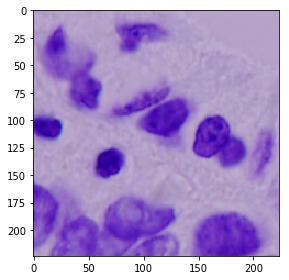

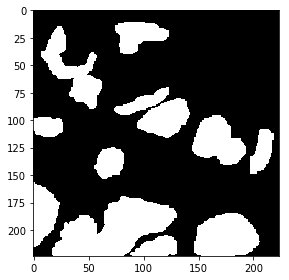

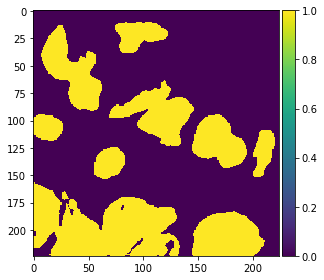

In [22]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [23]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [24]:
# RLEs and test ids

new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [25]:
# Create submission DataFrame

sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-stage1-ens0.csv', index=False)